In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from Environment import *
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
'''
Direction mapping:
0: left = [-1, 0]
1: right = [1, 0]
2: up = [0, -1]
3: down = [0, 1]
'''

class User_Agent:
    def __init__(self):
        #model
        #-----------------------------------------------------
        input_A = Input(shape = (4,))    #curr_x, curr_y, target_x, target_y
        x = Dense(32, activation = 'relu')(input_A)
        x = Dense(64, activation = 'relu')(x)
        x = Dense(32, activation = 'relu')(x)
        x = Dense(4)(x) #left, right, down, up
        
        self.model = Model(inputs = input_A, outputs = x)
        print(self.model.summary())
        #---------------------------------------------------
        
        self.target_model = tf.keras.models.clone_model(self.model)
        self.target_model.set_weights(self.model.get_weights())
        
        self.loss_fn = tf.keras.losses.mean_squared_error
        self.optimizer = tf.keras.optimizers.Adam(lr = 0.0001)
        self.batch_size = 128
        self.replay_buffer_size = 1024
        self.replay_buffer = Replay_Buffer(self.replay_buffer_size)
        self.epsilon = 1
        self.gamma = 0.9
        
    def exp_policy(self, state):
        if np.random.rand()<self.epsilon:
            return np.random.randint(4)
        else:
            state = np.array(state)[np.newaxis]
            Q_values = self.model(state)
            return np.argmax(Q_values[0])
            

    def play_one_step(self, env, state, mod_agent):
        action_user = self.exp_policy(state)
        action_user_one_hot = make_one_hot(action_user, 4)
        curr_loc = state[:2]
        target_loc = state[2:]
        action_user_one_hot.extend(curr_loc)
        mod_state = action_user_one_hot[:]
        mod_state = np.array(mod_state)
        new_loc, reward, done = mod_agent.play_one_step(env, mod_state, curr_loc, target_loc, self)
        next_state = [new_loc[0], new_loc[1], target_loc[0], target_loc[1]]
        self.replay_buffer.append(state, action_user, reward, next_state, done)
        
        return next_state, reward, done
    
    def sample_experience(self):
        indices = np.random.randint(len(self.replay_buffer.state_history), size = self.batch_size)
        
        states = np.array([self.replay_buffer.state_history[i] for i in indices])
        actions = np.array([self.replay_buffer.action_history[i] for i in indices])
        next_states = np.array([self.replay_buffer.next_state_history[i] for i in indices])
        rewards = np.array([self.replay_buffer.rewards_history[i] for i in indices])
        dones = np.array([self.replay_buffer.done_history[i] for i in indices])
        
        return states, actions, next_states, rewards, dones
    
    def train(self):
        states, actions, next_states, rewards, dones = self.sample_experience()
        next_Q_values = self.model(next_states)
        best_next_actions = np.argmax(next_Q_values, axis= 1)
        next_mask = tf.one_hot(best_next_actions, 4).numpy()
        max_next_Q_values = tf.reduce_sum(self.target_model(next_states)*next_mask, axis = 1, keepdims = True)
        target_Q_values = rewards + (1-dones)*self.gamma*max_next_Q_values
        
        mask = tf.one_hot(actions, 4)
        
        with tf.GradientTape() as tape:
            all_Q_values = self.model(states)
            Q_values = tf.reduce_sum(all_Q_values*mask, axis = 1, keepdims = True)
            loss = tf.reduce_mean(self.loss_fn(target_Q_values, Q_values))

        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

In [3]:
class Mod_Agent:
    def play_one_step(self, env, state, curr_loc, target_loc, user_agent):
        #Agent not aware of target location
        action_user = np.argmax(state[:4])
        action_mod = 1
        new_loc, reward_user, reward_mod, done = env.step(action_user, action_mod, target_loc, curr_loc)
        
        return new_loc, reward_user, done

In [4]:
env = Environment()
user_agent = User_Agent()
mod_agent = Mod_Agent()

Icon Locations:
[[0.2 0.4]
 [0.1 0.7]
 [0.8 0.4]
 [0.5 0.2]
 [0.  0.5]
 [0.1 0.7]]
Icon usage Probabilities
[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 32)                160       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 132       
Total params: 4,484
Trainable params: 4,484
Non-trainable params: 0
________

In [5]:
state = [0.1,0.1,0.3,0.3]
state = np.array(state)
next_state, reward, done = user_agent.play_one_step(env, state, mod_agent)
print(next_state, reward,done)

user_agent.replay_buffer.print()

print(user_agent.model(np.array([state])))

[0.0, 0.1, 0.3, 0.3] -1 0
deque([array([0.1, 0.1, 0.3, 0.3])], maxlen=1024)
deque([0], maxlen=1024)
deque([-1], maxlen=1024)
deque([[0.0, 0.1, 0.3, 0.3]], maxlen=1024)
deque([0], maxlen=1024)
tf.Tensor([[ 0.03000031  0.02881908 -0.0076917   0.01345752]], shape=(1, 4), dtype=float32)


  0%|                                                                             | 115/100000 [00:00<16:49, 98.97it/s]

Updated Weights
Mean Reward = -2.594059405940594
14


  0%|▏                                                                            | 215/100000 [00:02<20:10, 82.43it/s]

Updated Weights
Mean Reward = -2.58
11


  0%|▏                                                                            | 308/100000 [00:03<21:52, 75.98it/s]

Updated Weights
Mean Reward = -0.7
21


  0%|▎                                                                            | 411/100000 [00:04<24:57, 66.50it/s]

Updated Weights
Mean Reward = 1.53
24


  0%|▍                                                                            | 498/100000 [00:06<24:56, 66.50it/s]

Updated Weights
Mean Reward = -0.7
19


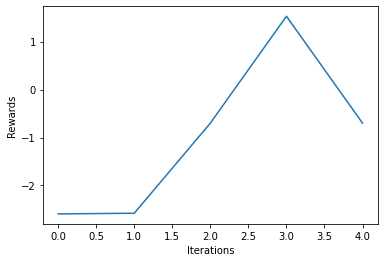

  1%|▍                                                                            | 604/100000 [00:08<31:28, 52.63it/s]

Updated Weights
Mean Reward = 1.37
20


  1%|▌                                                                            | 708/100000 [00:11<31:06, 53.19it/s]

Updated Weights
Mean Reward = 1.5
23


  1%|▌                                                                            | 809/100000 [00:13<36:17, 45.55it/s]

Updated Weights
Mean Reward = -0.37
21


  1%|▋                                                                            | 907/100000 [00:15<35:51, 46.05it/s]

Updated Weights
Mean Reward = 1.98
28


  1%|▊                                                                            | 999/100000 [00:18<53:44, 30.71it/s]

Updated Weights
Mean Reward = -0.07
23


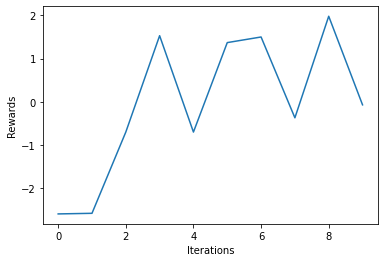

  1%|▊                                                                           | 1105/100000 [00:21<50:22, 32.72it/s]

Updated Weights
Mean Reward = 0.16
15


  1%|▉                                                                           | 1206/100000 [00:24<50:07, 32.85it/s]

Updated Weights
Mean Reward = -2.16
8


  1%|▉                                                                           | 1306/100000 [00:28<49:48, 33.02it/s]

Updated Weights
Mean Reward = 1.61
24


  1%|█                                                                           | 1406/100000 [00:31<52:42, 31.17it/s]

Updated Weights
Mean Reward = 0.79
19


  1%|█▏                                                                          | 1497/100000 [00:33<39:11, 41.88it/s]

Updated Weights
Mean Reward = -1.0
12


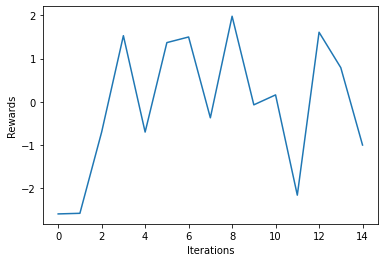

  2%|█▏                                                                          | 1606/100000 [00:36<41:12, 39.79it/s]

Updated Weights
Mean Reward = 1.0
23


  2%|█▎                                                                          | 1707/100000 [00:39<39:39, 41.31it/s]

Updated Weights
Mean Reward = 2.33
20


  2%|█▎                                                                          | 1808/100000 [00:41<42:07, 38.84it/s]

Updated Weights
Mean Reward = 1.61
23


  2%|█▍                                                                          | 1906/100000 [00:44<44:27, 36.78it/s]

Updated Weights
Mean Reward = -0.64
13


  2%|█▌                                                                          | 1998/100000 [00:46<45:08, 36.18it/s]

Updated Weights
Mean Reward = 0.84
14


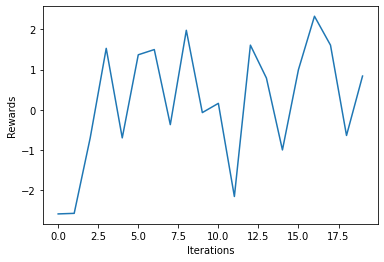

  2%|█▌                                                                          | 2107/100000 [00:50<50:23, 32.38it/s]

Updated Weights
Mean Reward = -0.62
10


  2%|█▋                                                                          | 2208/100000 [00:52<41:37, 39.16it/s]

Updated Weights
Mean Reward = 0.92
22


  2%|█▊                                                                          | 2304/100000 [00:55<46:10, 35.26it/s]

Updated Weights
Mean Reward = 1.75
23


  2%|█▊                                                                          | 2405/100000 [00:58<51:11, 31.77it/s]

Updated Weights
Mean Reward = 0.73
16


  2%|█▉                                                                          | 2497/100000 [01:01<53:36, 30.32it/s]

Updated Weights
Mean Reward = 2.24
9


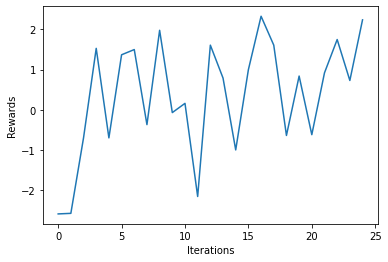

  3%|█▉                                                                          | 2603/100000 [01:05<55:11, 29.42it/s]

Updated Weights
Mean Reward = 2.0
13


  3%|██                                                                          | 2705/100000 [01:08<55:32, 29.19it/s]

Updated Weights
Mean Reward = 2.48
16


  3%|██▏                                                                         | 2803/100000 [01:12<56:59, 28.42it/s]

Updated Weights
Mean Reward = -0.39
15


  3%|██▏                                                                         | 2906/100000 [01:15<54:07, 29.90it/s]

Updated Weights
Mean Reward = 2.66
22


  3%|██▎                                                                         | 3000/100000 [01:18<44:30, 36.32it/s]

Updated Weights
Mean Reward = 3.28
19


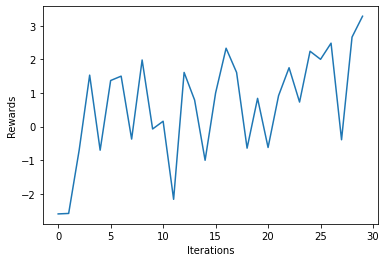

  3%|██▎                                                                         | 3108/100000 [01:22<48:42, 33.15it/s]

Updated Weights
Mean Reward = 1.35
22


  3%|██▍                                                                         | 3204/100000 [01:25<47:06, 34.25it/s]

Updated Weights
Mean Reward = 1.91
36


  3%|██▍                                                                       | 3305/100000 [01:29<1:06:45, 24.14it/s]

Updated Weights
Mean Reward = 3.34
18


  3%|██▌                                                                         | 3403/100000 [01:32<58:09, 27.68it/s]

Updated Weights
Mean Reward = 2.78
13


  3%|██▋                                                                         | 3497/100000 [01:35<50:02, 32.14it/s]

Updated Weights
Mean Reward = 3.07
17


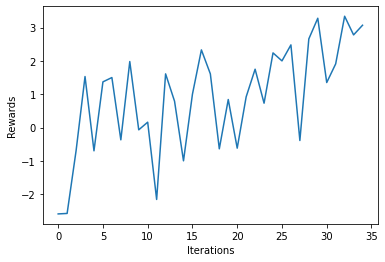

  4%|██▋                                                                         | 3604/100000 [01:39<57:54, 27.74it/s]

Updated Weights
Mean Reward = 3.25
19


  4%|██▊                                                                         | 3704/100000 [01:43<57:26, 27.94it/s]

Updated Weights
Mean Reward = 0.54
12


  4%|██▉                                                                         | 3804/100000 [01:47<47:51, 33.50it/s]

Updated Weights
Mean Reward = 2.39
26


  4%|██▉                                                                         | 3905/100000 [01:50<44:27, 36.03it/s]

Updated Weights
Mean Reward = 3.12
27


  4%|███                                                                         | 3998/100000 [01:53<53:58, 29.65it/s]

Updated Weights
Mean Reward = 2.83
25


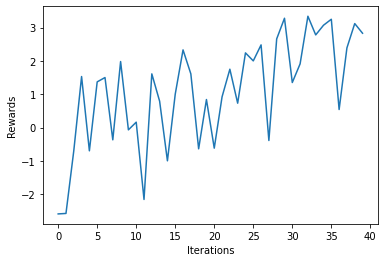

  4%|███                                                                         | 4103/100000 [01:57<52:14, 30.59it/s]

Updated Weights
Mean Reward = -1.92
24


  4%|███▏                                                                        | 4205/100000 [02:00<47:47, 33.41it/s]

Updated Weights
Mean Reward = 0.18
23


  4%|███▎                                                                        | 4305/100000 [02:04<55:54, 28.53it/s]

Updated Weights
Mean Reward = 4.45
21


  4%|███▎                                                                        | 4405/100000 [02:07<56:20, 28.28it/s]

Updated Weights
Mean Reward = 2.62
18


  4%|███▎                                                                      | 4500/100000 [02:11<1:02:12, 25.58it/s]

Updated Weights
Mean Reward = 5.89
28


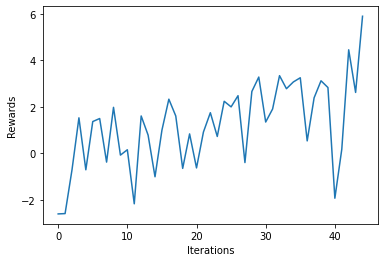

  5%|███▍                                                                        | 4602/100000 [02:14<51:25, 30.92it/s]

Updated Weights
Mean Reward = 4.72
24


  5%|███▌                                                                        | 4704/100000 [02:18<54:24, 29.19it/s]

Updated Weights
Mean Reward = 4.74
24


  5%|███▋                                                                        | 4804/100000 [02:21<59:43, 26.57it/s]

Updated Weights
Mean Reward = 3.67
20


  5%|███▋                                                                      | 4904/100000 [02:25<1:00:22, 26.25it/s]

Updated Weights
Mean Reward = 1.74
25


  5%|███▊                                                                        | 4999/100000 [02:28<58:00, 27.29it/s]

Updated Weights
Mean Reward = 3.24
20


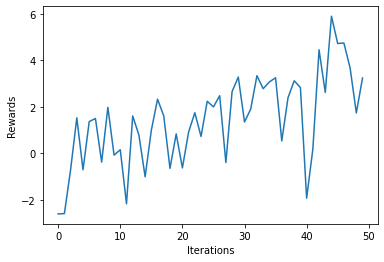

  5%|███▉                                                                        | 5107/100000 [02:32<54:23, 29.08it/s]

Updated Weights
Mean Reward = 3.58
26


  5%|███▉                                                                        | 5205/100000 [02:36<57:05, 27.67it/s]

Updated Weights
Mean Reward = 2.33
16


  5%|████                                                                        | 5303/100000 [02:39<53:08, 29.70it/s]

Updated Weights
Mean Reward = 2.58
24


  5%|███▉                                                                      | 5405/100000 [02:43<1:01:55, 25.46it/s]

Updated Weights
Mean Reward = 3.02
21


  6%|████▏                                                                       | 5500/100000 [02:46<56:02, 28.10it/s]

Updated Weights
Mean Reward = 1.96
28


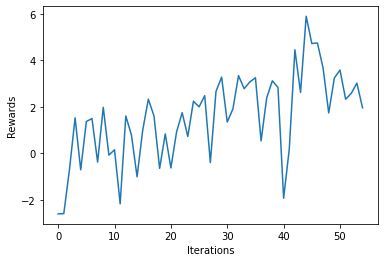

  6%|████▎                                                                       | 5604/100000 [02:50<53:47, 29.24it/s]

Updated Weights
Mean Reward = 3.33
24


  6%|████▎                                                                       | 5705/100000 [02:53<56:12, 27.96it/s]

Updated Weights
Mean Reward = 3.35
20


  6%|████▍                                                                       | 5808/100000 [02:57<46:35, 33.70it/s]

Updated Weights
Mean Reward = 2.85
16


  6%|████▍                                                                       | 5905/100000 [03:01<56:50, 27.59it/s]

Updated Weights
Mean Reward = 1.66
17


  6%|████▌                                                                       | 6000/100000 [03:04<58:23, 26.83it/s]

Updated Weights
Mean Reward = 1.35
13


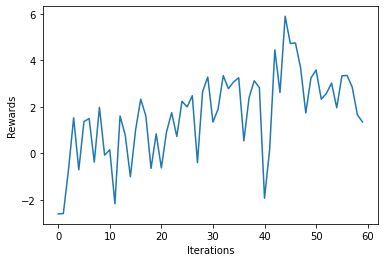

  6%|████▋                                                                       | 6106/100000 [03:08<53:53, 29.04it/s]

Updated Weights
Mean Reward = 0.71
19


  6%|████▋                                                                       | 6206/100000 [03:11<56:17, 27.77it/s]

Updated Weights
Mean Reward = 4.75
24


  6%|████▋                                                                     | 6306/100000 [03:15<1:00:53, 25.64it/s]

Updated Weights
Mean Reward = 2.93
12


  6%|████▊                                                                       | 6405/100000 [03:19<56:57, 27.38it/s]

Updated Weights
Mean Reward = 2.98
18


  6%|████▉                                                                       | 6499/100000 [03:22<59:53, 26.02it/s]

Updated Weights
Mean Reward = 2.86
17


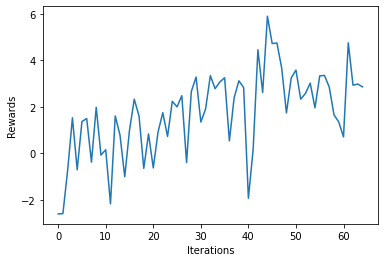

  7%|█████                                                                       | 6606/100000 [03:26<53:07, 29.30it/s]

Updated Weights
Mean Reward = 2.49
17


  7%|████▉                                                                     | 6702/100000 [03:30<1:05:32, 23.73it/s]

Updated Weights
Mean Reward = 2.32
10


  7%|█████▏                                                                      | 6805/100000 [03:34<59:10, 26.25it/s]

Updated Weights
Mean Reward = 3.57
13


  7%|█████▏                                                                      | 6905/100000 [03:37<58:22, 26.58it/s]

Updated Weights
Mean Reward = 3.45
12


  7%|█████▎                                                                      | 6999/100000 [03:41<51:27, 30.12it/s]

Updated Weights
Mean Reward = 4.75
24


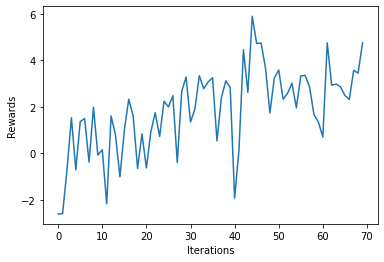

  7%|█████▍                                                                      | 7104/100000 [03:45<58:22, 26.53it/s]

Updated Weights
Mean Reward = 2.45
11


  7%|█████▎                                                                    | 7205/100000 [03:48<1:00:39, 25.50it/s]

Updated Weights
Mean Reward = 3.12
13


  7%|█████▌                                                                      | 7304/100000 [03:52<56:38, 27.27it/s]

Updated Weights
Mean Reward = 3.5
18


  7%|█████▋                                                                      | 7407/100000 [03:56<49:23, 31.25it/s]

Updated Weights
Mean Reward = 1.65
14


  8%|█████▋                                                                      | 7500/100000 [03:59<59:44, 25.81it/s]

Updated Weights
Mean Reward = 4.45
14


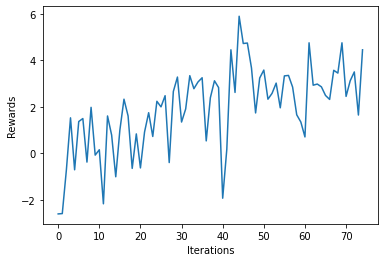

  8%|█████▋                                                                    | 7603/100000 [04:03<1:00:09, 25.60it/s]

Updated Weights
Mean Reward = 2.72
17


  8%|█████▋                                                                    | 7705/100000 [04:07<1:02:41, 24.54it/s]

Updated Weights
Mean Reward = 1.3
3


  8%|█████▉                                                                      | 7806/100000 [04:11<55:18, 27.79it/s]

Updated Weights
Mean Reward = 1.21
8


  8%|██████                                                                      | 7905/100000 [04:15<59:08, 25.95it/s]

Updated Weights
Mean Reward = 1.52
5


  8%|██████                                                                      | 8000/100000 [04:18<56:18, 27.23it/s]

Updated Weights
Mean Reward = 1.85
9


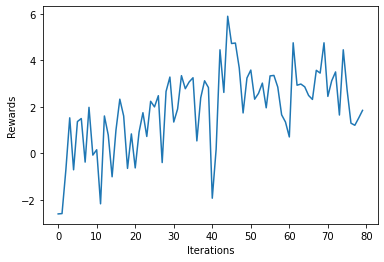

  8%|██████▏                                                                     | 8107/100000 [04:22<51:38, 29.66it/s]

Updated Weights
Mean Reward = 3.69
16


  8%|██████▏                                                                     | 8204/100000 [04:26<51:42, 29.59it/s]

Updated Weights
Mean Reward = 3.68
21


  8%|██████▎                                                                     | 8304/100000 [04:29<48:10, 31.73it/s]

Updated Weights
Mean Reward = 4.77
26


  8%|██████▍                                                                     | 8403/100000 [04:32<46:01, 33.17it/s]

Updated Weights
Mean Reward = 5.96
32


  8%|██████▍                                                                     | 8500/100000 [04:36<58:09, 26.22it/s]

Updated Weights
Mean Reward = 3.72
20


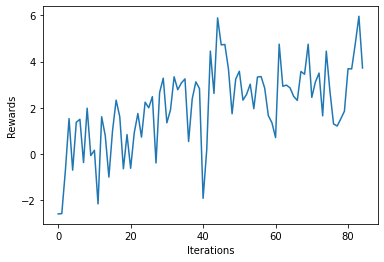

  9%|██████▎                                                                   | 8604/100000 [04:40<1:00:04, 25.36it/s]

Updated Weights
Mean Reward = -0.39
11


  9%|██████▍                                                                   | 8706/100000 [04:44<1:00:06, 25.31it/s]

Updated Weights
Mean Reward = 2.23
8


  9%|██████▋                                                                     | 8805/100000 [04:47<46:30, 32.69it/s]

Updated Weights
Mean Reward = 3.82
23


  9%|██████▊                                                                     | 8905/100000 [04:50<51:53, 29.26it/s]

Updated Weights
Mean Reward = 5.39
26


  9%|██████▊                                                                     | 9000/100000 [04:54<56:51, 26.67it/s]

Updated Weights
Mean Reward = 3.94
20


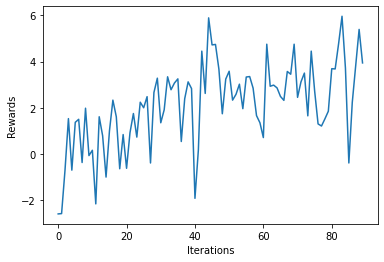

  9%|██████▋                                                                   | 9104/100000 [04:58<1:00:37, 24.99it/s]

Updated Weights
Mean Reward = 2.43
9


  9%|██████▊                                                                   | 9204/100000 [05:02<1:01:09, 24.74it/s]

Updated Weights
Mean Reward = 0.75
10


  9%|███████                                                                     | 9303/100000 [05:05<58:57, 25.64it/s]

Updated Weights
Mean Reward = 4.13
17


  9%|███████▏                                                                    | 9404/100000 [05:09<50:53, 29.67it/s]

Updated Weights
Mean Reward = 4.62
25


  9%|███████▏                                                                    | 9499/100000 [05:12<54:14, 27.80it/s]

Updated Weights
Mean Reward = 3.34
17


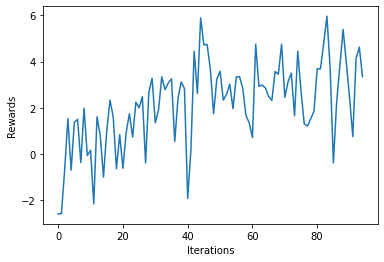

 10%|███████▎                                                                    | 9604/100000 [05:16<57:46, 26.08it/s]

Updated Weights
Mean Reward = 3.53
14


 10%|███████▍                                                                    | 9705/100000 [05:20<56:34, 26.60it/s]

Updated Weights
Mean Reward = 1.1
9


 10%|███████▎                                                                  | 9806/100000 [05:24<1:01:14, 24.55it/s]

Updated Weights
Mean Reward = 1.61
11


 10%|███████▌                                                                    | 9904/100000 [05:27<54:52, 27.37it/s]

Updated Weights
Mean Reward = 3.0
14


 10%|███████▌                                                                    | 9999/100000 [05:31<59:41, 25.13it/s]

Updated Weights
Mean Reward = 1.99
9


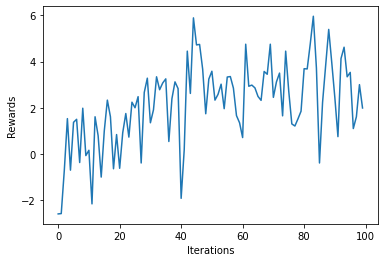

 10%|███████▌                                                                   | 10105/100000 [05:35<59:55, 25.00it/s]

Updated Weights
Mean Reward = 2.0
8


 10%|███████▋                                                                   | 10203/100000 [05:39<49:10, 30.43it/s]

Updated Weights
Mean Reward = 0.45
16


 10%|███████▋                                                                   | 10304/100000 [05:42<55:49, 26.78it/s]

Updated Weights
Mean Reward = -3.43
18


 10%|███████▊                                                                   | 10405/100000 [05:46<54:29, 27.40it/s]

Updated Weights
Mean Reward = 2.69
16


 10%|███████▉                                                                   | 10500/100000 [05:50<59:15, 25.17it/s]

Updated Weights
Mean Reward = 3.54
9


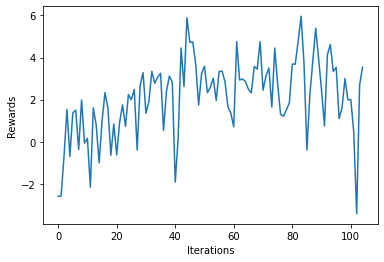

 11%|███████▉                                                                   | 10605/100000 [05:54<51:08, 29.13it/s]

Updated Weights
Mean Reward = 0.75
20


 11%|████████                                                                   | 10706/100000 [05:57<59:02, 25.21it/s]

Updated Weights
Mean Reward = 3.79
11


 11%|███████▉                                                                 | 10806/100000 [06:01<1:00:01, 24.76it/s]

Updated Weights
Mean Reward = 2.2
8


 11%|████████▏                                                                  | 10904/100000 [06:05<55:35, 26.71it/s]

Updated Weights
Mean Reward = 4.11
18


 11%|████████▏                                                                  | 10998/100000 [06:08<58:55, 25.17it/s]

Updated Weights
Mean Reward = 2.79
18


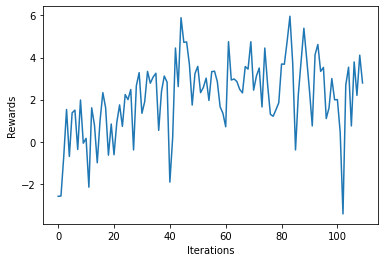

 11%|████████▎                                                                  | 11105/100000 [06:13<56:11, 26.37it/s]

Updated Weights
Mean Reward = 2.74
10


 11%|████████▍                                                                  | 11204/100000 [06:16<56:59, 25.97it/s]

Updated Weights
Mean Reward = 3.19
13


 11%|████████▍                                                                  | 11304/100000 [06:20<59:06, 25.01it/s]

Updated Weights
Mean Reward = 2.81
12


 11%|████████▌                                                                  | 11405/100000 [06:24<54:00, 27.34it/s]

Updated Weights
Mean Reward = 1.51
14


 11%|████████▌                                                                  | 11498/100000 [06:27<55:15, 26.69it/s]

Updated Weights
Mean Reward = 1.78
12


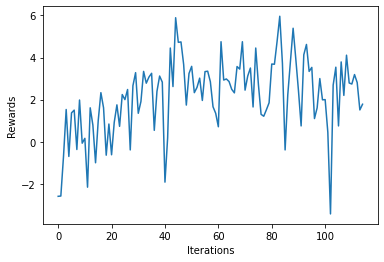

 12%|████████▋                                                                  | 11604/100000 [06:32<58:37, 25.13it/s]

Updated Weights
Mean Reward = 2.32
10


 12%|████████▊                                                                  | 11705/100000 [06:35<45:42, 32.19it/s]

Updated Weights
Mean Reward = 4.3
22


 12%|████████▊                                                                  | 11805/100000 [06:39<53:39, 27.39it/s]

Updated Weights
Mean Reward = 3.37
14


 12%|████████▉                                                                  | 11906/100000 [06:42<50:59, 28.80it/s]

Updated Weights
Mean Reward = 5.35
27


 12%|████████▉                                                                  | 11999/100000 [06:46<54:12, 27.05it/s]

Updated Weights
Mean Reward = 4.9
24


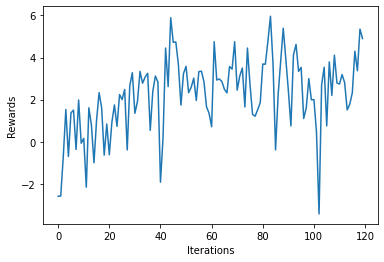

 12%|█████████                                                                  | 12103/100000 [06:50<53:35, 27.34it/s]

Updated Weights
Mean Reward = 5.46
22


 12%|█████████▏                                                                 | 12207/100000 [06:53<47:08, 31.04it/s]

Updated Weights
Mean Reward = 4.96
22


 12%|█████████▏                                                                 | 12303/100000 [06:56<47:12, 30.96it/s]

Updated Weights
Mean Reward = 6.23
33


 12%|█████████▎                                                                 | 12404/100000 [07:00<45:15, 32.26it/s]

Updated Weights
Mean Reward = 5.98
33


 12%|█████████▎                                                                 | 12498/100000 [07:03<58:01, 25.13it/s]

Updated Weights
Mean Reward = 3.2
17


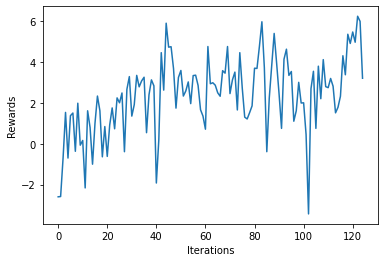

 13%|█████████▍                                                                 | 12604/100000 [07:08<57:21, 25.39it/s]

Updated Weights
Mean Reward = -0.84
3


 13%|█████████▌                                                                 | 12702/100000 [07:11<47:23, 30.70it/s]

Updated Weights
Mean Reward = 1.96
15


 13%|█████████▌                                                                 | 12807/100000 [07:15<51:49, 28.04it/s]

Updated Weights
Mean Reward = 3.03
12


 13%|█████████▋                                                                 | 12908/100000 [07:18<46:35, 31.16it/s]

Updated Weights
Mean Reward = 5.6
31


 13%|█████████▊                                                                 | 13000/100000 [07:22<49:04, 29.54it/s]

Updated Weights
Mean Reward = 4.82
23


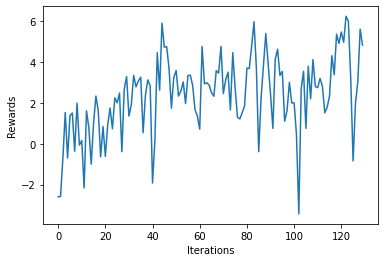

 13%|█████████▊                                                                 | 13105/100000 [07:25<44:47, 32.33it/s]

Updated Weights
Mean Reward = 3.44
29


 13%|█████████▉                                                                 | 13204/100000 [07:29<52:38, 27.48it/s]

Updated Weights
Mean Reward = 0.64
10


 13%|█████████▉                                                                 | 13305/100000 [07:33<58:32, 24.68it/s]

Updated Weights
Mean Reward = 1.34
12


 13%|██████████                                                                 | 13408/100000 [07:37<48:38, 29.67it/s]

Updated Weights
Mean Reward = 4.76
20


 14%|██████████▏                                                                | 13500/100000 [07:40<52:17, 27.57it/s]

Updated Weights
Mean Reward = 5.56
25


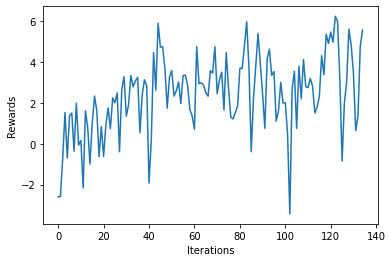

 14%|██████████▏                                                                | 13603/100000 [07:44<56:23, 25.54it/s]

Updated Weights
Mean Reward = 3.62
23


 14%|██████████▎                                                                | 13706/100000 [07:47<48:27, 29.68it/s]

Updated Weights
Mean Reward = 3.91
30


 14%|██████████▎                                                                | 13807/100000 [07:51<51:05, 28.12it/s]

Updated Weights
Mean Reward = 2.26
14


 14%|██████████▍                                                                | 13907/100000 [07:55<52:34, 27.30it/s]

Updated Weights
Mean Reward = 4.26
12


 14%|██████████▍                                                                | 13998/100000 [07:58<49:03, 29.21it/s]

Updated Weights
Mean Reward = 5.07
15


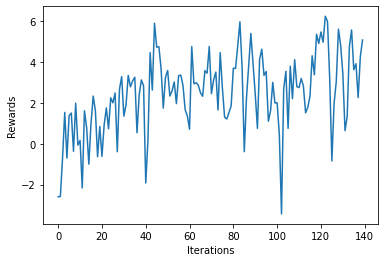

 14%|██████████▌                                                                | 14104/100000 [08:02<50:38, 28.27it/s]

Updated Weights
Mean Reward = 5.63
24


 14%|██████████▋                                                                | 14204/100000 [08:05<48:50, 29.28it/s]

Updated Weights
Mean Reward = 5.91
25


 14%|██████████▋                                                                | 14304/100000 [08:09<40:48, 35.00it/s]

Updated Weights
Mean Reward = 5.53
28


 14%|██████████▊                                                                | 14403/100000 [08:12<52:35, 27.13it/s]

Updated Weights
Mean Reward = 4.45
29


 14%|██████████▊                                                                | 14499/100000 [08:16<54:35, 26.10it/s]

Updated Weights
Mean Reward = 3.19
16


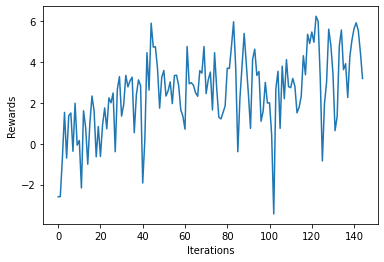

 15%|██████████▉                                                                | 14605/100000 [08:19<50:56, 27.94it/s]

Updated Weights
Mean Reward = 3.97
22


 15%|███████████                                                                | 14704/100000 [08:23<51:28, 27.62it/s]

Updated Weights
Mean Reward = 4.81
18


 15%|███████████                                                                | 14806/100000 [08:27<48:24, 29.33it/s]

Updated Weights
Mean Reward = 4.77
28


 15%|███████████▏                                                               | 14907/100000 [08:30<44:37, 31.78it/s]

Updated Weights
Mean Reward = 5.97
23


 15%|███████████▏                                                               | 14998/100000 [08:34<50:58, 27.80it/s]

Updated Weights
Mean Reward = 5.33
21


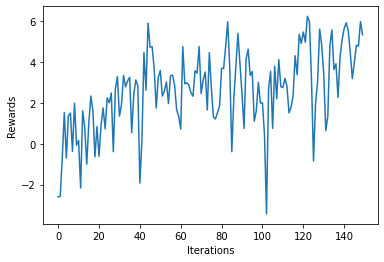

 15%|███████████▎                                                               | 15105/100000 [08:37<48:56, 28.91it/s]

Updated Weights
Mean Reward = 5.82
26


 15%|███████████▍                                                               | 15205/100000 [08:41<53:43, 26.31it/s]

Updated Weights
Mean Reward = 5.46
25


 15%|███████████▍                                                               | 15305/100000 [08:44<55:50, 25.28it/s]

Updated Weights
Mean Reward = 3.75
14


 15%|███████████▌                                                               | 15406/100000 [08:48<53:20, 26.43it/s]

Updated Weights
Mean Reward = 3.54
8


 15%|███████████▌                                                               | 15497/100000 [08:52<56:42, 24.83it/s]

Updated Weights
Mean Reward = 3.07
8


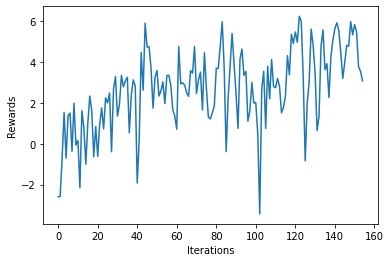

 16%|███████████▋                                                               | 15603/100000 [08:56<56:40, 24.82it/s]

Updated Weights
Mean Reward = 2.99
7


 16%|███████████▊                                                               | 15703/100000 [09:00<55:36, 25.26it/s]

Updated Weights
Mean Reward = 0.43
14


 16%|███████████▊                                                               | 15804/100000 [09:04<53:52, 26.04it/s]

Updated Weights
Mean Reward = 3.11
22


 16%|███████████▉                                                               | 15906/100000 [09:07<55:14, 25.37it/s]

Updated Weights
Mean Reward = 3.6
15


 16%|████████████                                                               | 16000/100000 [09:11<53:09, 26.33it/s]

Updated Weights
Mean Reward = 4.41
12


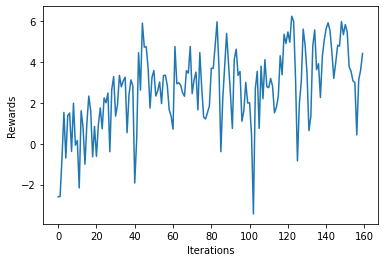

 16%|████████████                                                               | 16103/100000 [09:15<51:31, 27.13it/s]

Updated Weights
Mean Reward = 4.84
17


 16%|████████████▏                                                              | 16205/100000 [09:18<53:57, 25.88it/s]

Updated Weights
Mean Reward = 5.38
19


 16%|████████████▏                                                              | 16305/100000 [09:22<49:33, 28.15it/s]

Updated Weights
Mean Reward = 6.3
24


 16%|████████████▎                                                              | 16406/100000 [09:25<48:28, 28.74it/s]

Updated Weights
Mean Reward = 5.11
19


 16%|████████████▎                                                              | 16498/100000 [09:29<53:31, 26.00it/s]

Updated Weights
Mean Reward = 4.44
18


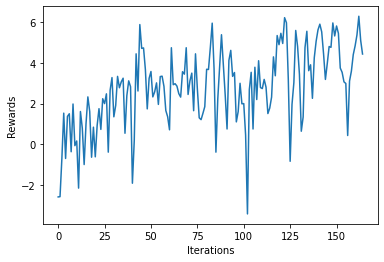

 17%|████████████▍                                                              | 16604/100000 [09:33<51:29, 27.00it/s]

Updated Weights
Mean Reward = 3.41
18


 17%|████████████▌                                                              | 16704/100000 [09:36<42:03, 33.01it/s]

Updated Weights
Mean Reward = 5.57
26


 17%|████████████▌                                                              | 16805/100000 [09:40<54:55, 25.24it/s]

Updated Weights
Mean Reward = 4.05
11


 17%|████████████▋                                                              | 16904/100000 [09:44<54:53, 25.23it/s]

Updated Weights
Mean Reward = 3.37
14


 17%|████████████▊                                                              | 17000/100000 [09:47<52:45, 26.22it/s]

Updated Weights
Mean Reward = 4.98
13


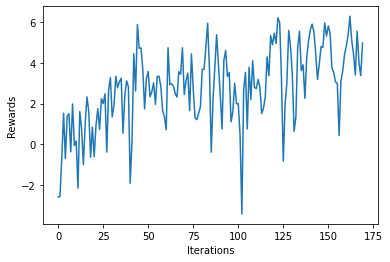

 17%|████████████▊                                                              | 17104/100000 [09:51<54:26, 25.38it/s]

Updated Weights
Mean Reward = 3.89
13


 17%|████████████▉                                                              | 17205/100000 [09:55<50:59, 27.06it/s]

Updated Weights
Mean Reward = 3.85
13


 17%|████████████▉                                                              | 17304/100000 [09:59<55:21, 24.90it/s]

Updated Weights
Mean Reward = 3.12
7


 17%|█████████████                                                              | 17407/100000 [10:03<47:07, 29.21it/s]

Updated Weights
Mean Reward = 4.34
10


 17%|█████████████                                                              | 17499/100000 [10:06<55:58, 24.56it/s]

Updated Weights
Mean Reward = 3.88
13


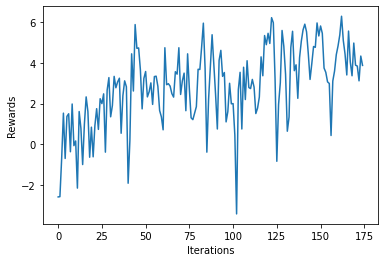

 18%|████████████▊                                                            | 17603/100000 [10:11<1:00:10, 22.82it/s]

Updated Weights
Mean Reward = 3.17
7


 18%|█████████████▎                                                             | 17703/100000 [10:15<51:30, 26.63it/s]

Updated Weights
Mean Reward = 3.55
17


 18%|█████████████▎                                                             | 17804/100000 [10:19<51:51, 26.41it/s]

Updated Weights
Mean Reward = 4.04
13


 18%|█████████████▍                                                             | 17905/100000 [10:23<51:58, 26.32it/s]

Updated Weights
Mean Reward = 1.51
10


 18%|█████████████▍                                                             | 17997/100000 [10:26<53:05, 25.75it/s]

Updated Weights
Mean Reward = 4.82
18


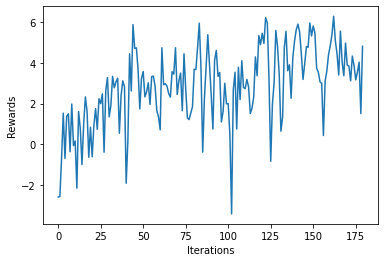

 18%|█████████████▌                                                             | 18105/100000 [10:30<48:44, 28.01it/s]

Updated Weights
Mean Reward = 4.38
15


 18%|█████████████▋                                                             | 18204/100000 [10:34<56:27, 24.14it/s]

Updated Weights
Mean Reward = 4.01
8


 18%|█████████████▋                                                             | 18304/100000 [10:38<51:01, 26.69it/s]

Updated Weights
Mean Reward = 3.82
17


 18%|█████████████▊                                                             | 18405/100000 [10:42<55:21, 24.57it/s]

Updated Weights
Mean Reward = 2.99
6


 18%|█████████████▊                                                             | 18498/100000 [10:45<43:06, 31.51it/s]

Updated Weights
Mean Reward = 4.99
18


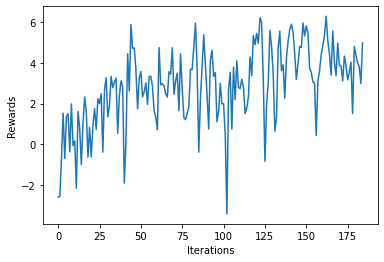

 19%|█████████████▉                                                             | 18604/100000 [10:49<54:21, 24.96it/s]

Updated Weights
Mean Reward = 3.4
14


 19%|██████████████                                                             | 18705/100000 [10:53<53:11, 25.47it/s]

Updated Weights
Mean Reward = 4.04
9


 19%|██████████████                                                             | 18805/100000 [10:57<49:26, 27.37it/s]

Updated Weights
Mean Reward = 3.94
11


 19%|██████████████▏                                                            | 18905/100000 [11:01<49:57, 27.06it/s]

Updated Weights
Mean Reward = 4.44
17


 19%|██████████████▎                                                            | 19000/100000 [11:04<49:05, 27.50it/s]

Updated Weights
Mean Reward = 5.37
17


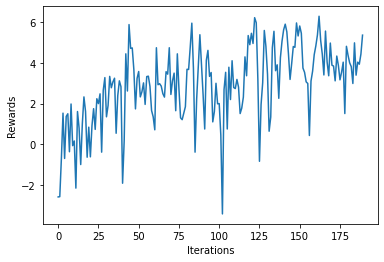

 19%|██████████████▎                                                            | 19104/100000 [11:08<51:39, 26.10it/s]

Updated Weights
Mean Reward = 4.61
16


 19%|██████████████▍                                                            | 19206/100000 [11:12<48:49, 27.58it/s]

Updated Weights
Mean Reward = 3.91
8


 19%|██████████████▍                                                            | 19303/100000 [11:16<52:53, 25.43it/s]

Updated Weights
Mean Reward = 4.27
16


 19%|██████████████▌                                                            | 19405/100000 [11:19<52:59, 25.35it/s]

Updated Weights
Mean Reward = 4.1
18


 19%|██████████████▌                                                            | 19499/100000 [11:23<51:07, 26.25it/s]

Updated Weights
Mean Reward = 5.41
20


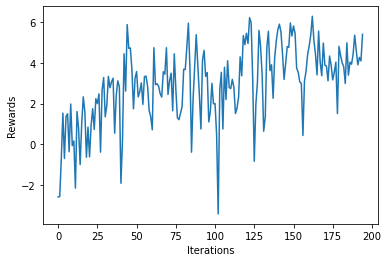

 20%|██████████████▋                                                            | 19605/100000 [11:27<53:11, 25.19it/s]

Updated Weights
Mean Reward = 3.84
7


 20%|██████████████▊                                                            | 19707/100000 [11:31<46:37, 28.71it/s]

Updated Weights
Mean Reward = 4.52
18


 20%|██████████████▊                                                            | 19807/100000 [11:34<47:13, 28.30it/s]

Updated Weights
Mean Reward = 4.85
19


 20%|██████████████▉                                                            | 19907/100000 [11:38<44:46, 29.82it/s]

Updated Weights
Mean Reward = 5.14
20


 20%|██████████████▉                                                            | 19998/100000 [11:41<52:58, 25.17it/s]

Updated Weights
Mean Reward = 3.69
8


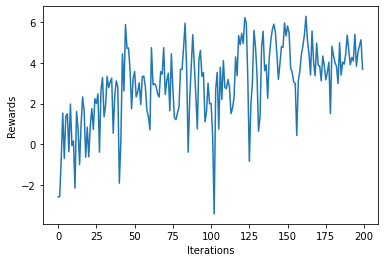

 20%|███████████████                                                            | 20106/100000 [11:45<47:03, 28.29it/s]

Updated Weights
Mean Reward = 4.46
11


 20%|███████████████▏                                                           | 20205/100000 [11:49<49:30, 26.86it/s]

Updated Weights
Mean Reward = 6.08
23


 20%|███████████████▏                                                           | 20306/100000 [11:53<45:56, 28.91it/s]

Updated Weights
Mean Reward = 4.3
8


 20%|███████████████▎                                                           | 20405/100000 [11:57<52:43, 25.16it/s]

Updated Weights
Mean Reward = 3.9
5


 20%|███████████████▎                                                           | 20500/100000 [12:00<49:16, 26.89it/s]

Updated Weights
Mean Reward = 4.29
13


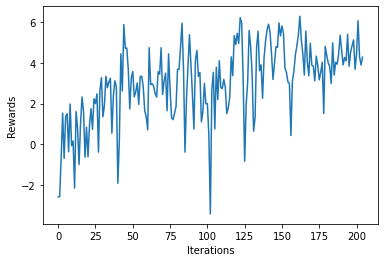

 21%|███████████████▍                                                           | 20606/100000 [12:04<48:41, 27.17it/s]

Updated Weights
Mean Reward = 4.64
18


 21%|███████████████▌                                                           | 20705/100000 [12:08<45:11, 29.25it/s]

Updated Weights
Mean Reward = 5.51
19


 21%|███████████████▌                                                           | 20803/100000 [12:12<52:53, 24.95it/s]

Updated Weights
Mean Reward = 3.76
11


 21%|███████████████▋                                                           | 20905/100000 [12:15<48:57, 26.93it/s]

Updated Weights
Mean Reward = 3.41
11


 21%|███████████████▋                                                           | 20999/100000 [12:19<51:03, 25.79it/s]

Updated Weights
Mean Reward = 4.1
13


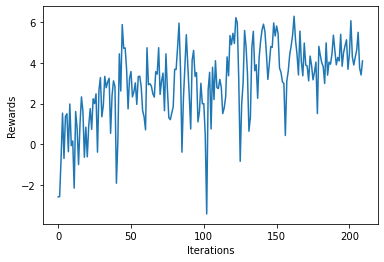

 21%|███████████████▊                                                           | 21106/100000 [12:23<49:28, 26.58it/s]

Updated Weights
Mean Reward = 3.97
11


 21%|███████████████▉                                                           | 21206/100000 [12:27<47:07, 27.87it/s]

Updated Weights
Mean Reward = 3.32
14


 21%|███████████████▉                                                           | 21305/100000 [12:31<53:47, 24.38it/s]

Updated Weights
Mean Reward = 4.25
12


 21%|███████████████▋                                                         | 21405/100000 [12:36<1:08:37, 19.09it/s]

Updated Weights
Mean Reward = 4.33
14


 21%|███████████████▋                                                         | 21499/100000 [12:41<1:14:40, 17.52it/s]

Updated Weights
Mean Reward = 2.96
6


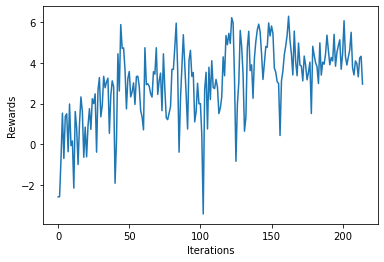

 22%|███████████████▊                                                         | 21604/100000 [12:47<1:12:31, 18.02it/s]

Updated Weights
Mean Reward = 4.53
11


 22%|███████████████▊                                                         | 21703/100000 [12:52<1:05:53, 19.80it/s]

Updated Weights
Mean Reward = 3.28
14


 22%|███████████████▉                                                         | 21804/100000 [12:57<1:04:28, 20.21it/s]

Updated Weights
Mean Reward = 3.92
16


 22%|███████████████▉                                                         | 21903/100000 [13:03<1:08:50, 18.91it/s]

Updated Weights
Mean Reward = 4.19
14


 22%|████████████████                                                         | 21999/100000 [13:08<1:17:36, 16.75it/s]

Updated Weights
Mean Reward = 4.61
16


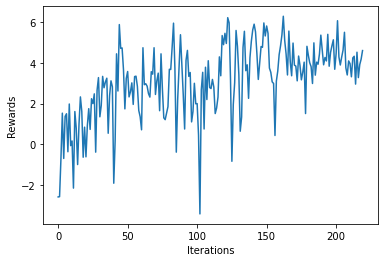

 22%|████████████████▏                                                        | 22102/100000 [13:14<1:20:16, 16.17it/s]

Updated Weights
Mean Reward = 4.91
22


 22%|████████████████▏                                                        | 22205/100000 [13:19<1:06:39, 19.45it/s]

Updated Weights
Mean Reward = 4.86
15


 22%|████████████████▎                                                        | 22304/100000 [13:24<1:08:18, 18.96it/s]

Updated Weights
Mean Reward = 5.72
24


 22%|████████████████▎                                                        | 22403/100000 [13:30<1:17:09, 16.76it/s]

Updated Weights
Mean Reward = 5.12
19


 22%|████████████████▍                                                        | 22498/100000 [13:35<1:00:09, 21.47it/s]

Updated Weights
Mean Reward = 4.19
19


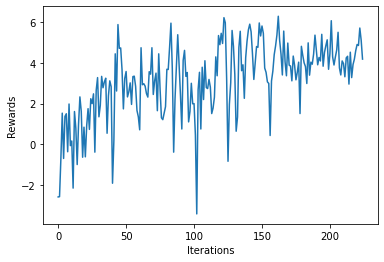

 23%|████████████████▌                                                        | 22604/100000 [13:41<1:14:06, 17.41it/s]

Updated Weights
Mean Reward = 4.29
18


 23%|████████████████▌                                                        | 22703/100000 [13:46<1:11:55, 17.91it/s]

Updated Weights
Mean Reward = 3.74
13


 23%|████████████████▋                                                        | 22804/100000 [13:51<1:07:35, 19.03it/s]

Updated Weights
Mean Reward = 4.8
14


 23%|████████████████▋                                                        | 22904/100000 [13:56<1:02:49, 20.45it/s]

Updated Weights
Mean Reward = 3.69
18


 23%|████████████████▊                                                        | 23000/100000 [14:01<1:09:43, 18.41it/s]

Updated Weights
Mean Reward = 4.52
9


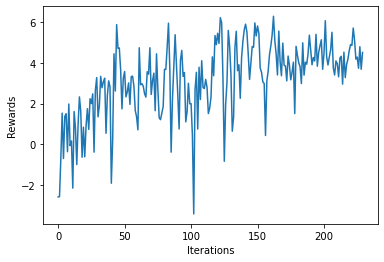

 23%|████████████████▊                                                        | 23103/100000 [14:07<1:03:16, 20.25it/s]

Updated Weights
Mean Reward = 3.73
14


 23%|████████████████▉                                                        | 23204/100000 [14:12<1:02:22, 20.52it/s]

Updated Weights
Mean Reward = 4.56
16


 23%|█████████████████                                                        | 23302/100000 [14:17<1:01:27, 20.80it/s]

Updated Weights
Mean Reward = 4.97
18


 23%|█████████████████                                                        | 23404/100000 [14:22<1:12:32, 17.60it/s]

Updated Weights
Mean Reward = 3.34
17


 24%|█████████████████▏                                                       | 23500/100000 [14:28<1:24:07, 15.16it/s]

Updated Weights
Mean Reward = 4.07
11


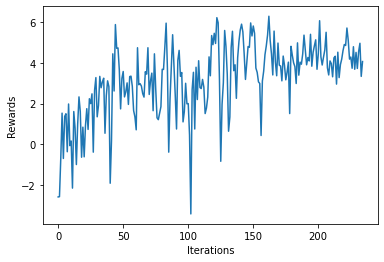

 24%|█████████████████▏                                                       | 23603/100000 [14:35<1:57:36, 10.83it/s]

Updated Weights
Mean Reward = 3.04
9


 24%|█████████████████▎                                                       | 23704/100000 [14:40<1:19:25, 16.01it/s]

Updated Weights
Mean Reward = 3.67
15


 24%|█████████████████▍                                                       | 23804/100000 [14:45<1:10:20, 18.05it/s]

Updated Weights
Mean Reward = 4.46
22


 24%|█████████████████▍                                                       | 23902/100000 [14:51<2:02:26, 10.36it/s]

Updated Weights
Mean Reward = 4.41
20


 24%|█████████████████▌                                                       | 24000/100000 [14:58<1:24:47, 14.94it/s]

Updated Weights
Mean Reward = 3.93
12


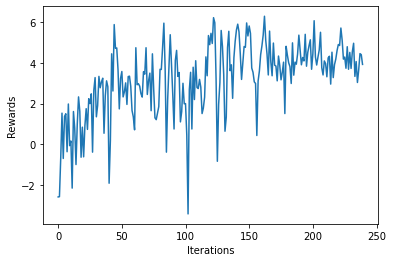

 24%|██████████████████                                                         | 24100/100000 [15:05<59:11, 21.37it/s]

Updated Weights
Mean Reward = 5.91
27


 24%|█████████████████▋                                                       | 24205/100000 [15:13<1:01:59, 20.38it/s]

Updated Weights
Mean Reward = 6.64
37


 24%|█████████████████▋                                                       | 24301/100000 [15:19<2:21:31,  8.92it/s]

Updated Weights
Mean Reward = 7.03
33


 24%|█████████████████▊                                                       | 24402/100000 [15:28<1:40:16, 12.56it/s]

Updated Weights
Mean Reward = 6.29
36


 24%|█████████████████▉                                                       | 24500/100000 [15:35<1:25:16, 14.76it/s]

Updated Weights
Mean Reward = 4.31
18


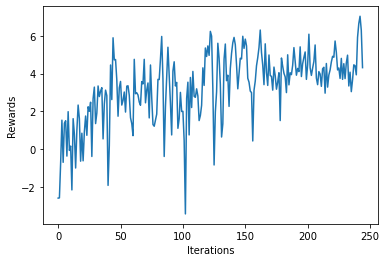

 25%|█████████████████▉                                                       | 24603/100000 [15:41<1:09:19, 18.13it/s]

Updated Weights
Mean Reward = 4.22
20


 25%|██████████████████                                                       | 24702/100000 [15:48<1:32:41, 13.54it/s]

Updated Weights
Mean Reward = 2.63
13


 25%|██████████████████                                                       | 24803/100000 [15:54<1:17:13, 16.23it/s]

Updated Weights
Mean Reward = 3.86
16


 25%|██████████████████▏                                                      | 24902/100000 [16:00<1:19:07, 15.82it/s]

Updated Weights
Mean Reward = 4.54
16


 25%|██████████████████▎                                                      | 25000/100000 [16:07<1:16:54, 16.25it/s]

Updated Weights
Mean Reward = 4.08
15


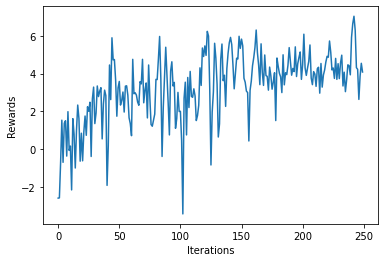

 25%|██████████████████▎                                                      | 25103/100000 [16:13<1:09:57, 17.84it/s]

Updated Weights
Mean Reward = 3.93
13


 25%|██████████████████▍                                                      | 25203/100000 [16:19<1:16:42, 16.25it/s]

Updated Weights
Mean Reward = 3.39
11


 25%|██████████████████▍                                                      | 25302/100000 [16:24<1:15:00, 16.60it/s]

Updated Weights
Mean Reward = 5.94
25


 25%|██████████████████▌                                                      | 25403/100000 [16:29<1:03:01, 19.73it/s]

Updated Weights
Mean Reward = 7.85
41


 25%|██████████████████▌                                                      | 25498/100000 [16:34<1:12:27, 17.14it/s]

Updated Weights
Mean Reward = 6.58
28


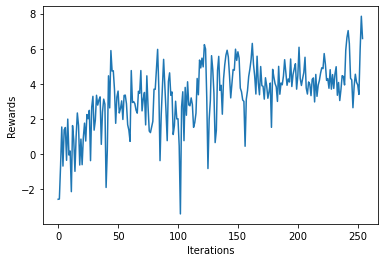

 26%|██████████████████▋                                                      | 25604/100000 [16:39<1:09:10, 17.93it/s]

Updated Weights
Mean Reward = 8.49
39


 26%|██████████████████▊                                                      | 25704/100000 [16:44<1:14:00, 16.73it/s]

Updated Weights
Mean Reward = 6.63
28


 26%|██████████████████▊                                                      | 25803/100000 [16:49<1:07:19, 18.37it/s]

Updated Weights
Mean Reward = 3.3
30


 26%|██████████████████▉                                                      | 25902/100000 [16:54<1:06:50, 18.47it/s]

Updated Weights
Mean Reward = 4.21
46


 26%|██████████████████▉                                                      | 25998/100000 [16:59<1:03:40, 19.37it/s]

Updated Weights
Mean Reward = 5.57
27


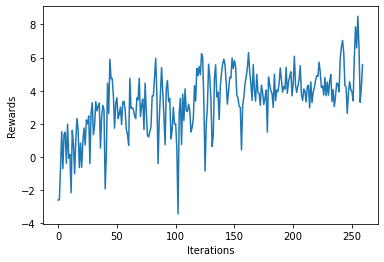

 26%|███████████████████                                                      | 26104/100000 [17:04<1:05:57, 18.67it/s]

Updated Weights
Mean Reward = 6.07
29


 26%|███████████████████▏                                                     | 26204/100000 [17:10<1:11:49, 17.12it/s]

Updated Weights
Mean Reward = 3.33
19


 26%|███████████████████▏                                                     | 26303/100000 [17:17<1:39:38, 12.33it/s]

Updated Weights
Mean Reward = 3.75
19


 26%|███████████████████▎                                                     | 26404/100000 [17:23<1:11:45, 17.09it/s]

Updated Weights
Mean Reward = 3.15
8


 26%|███████████████████▎                                                     | 26499/100000 [17:29<1:21:05, 15.11it/s]

Updated Weights
Mean Reward = 4.62
18


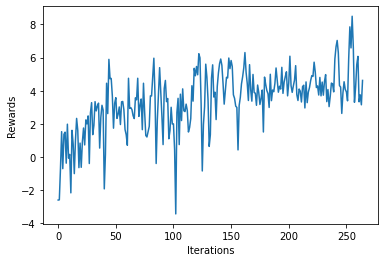

 27%|███████████████████▉                                                       | 26605/100000 [17:36<59:38, 20.51it/s]

Updated Weights
Mean Reward = 4.38
14


 27%|███████████████████▍                                                     | 26702/100000 [17:41<1:02:42, 19.48it/s]

Updated Weights
Mean Reward = 4.08
25


 27%|███████████████████▌                                                     | 26802/100000 [17:47<1:37:55, 12.46it/s]

Updated Weights
Mean Reward = 3.04
29


 27%|████████████████████▏                                                      | 26903/100000 [17:52<56:11, 21.68it/s]

Updated Weights
Mean Reward = 6.97
37


 27%|███████████████████▋                                                     | 27000/100000 [17:57<1:01:08, 19.90it/s]

Updated Weights
Mean Reward = 6.06
30


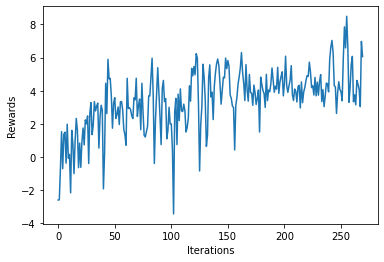

 27%|███████████████████▊                                                     | 27104/100000 [18:02<1:02:55, 19.31it/s]

Updated Weights
Mean Reward = 2.5
28


 27%|███████████████████▊                                                     | 27204/100000 [18:08<1:09:15, 17.52it/s]

Updated Weights
Mean Reward = 6.91
30


 27%|████████████████████▍                                                      | 27304/100000 [18:12<47:56, 25.27it/s]

Updated Weights
Mean Reward = 8.18
35


 27%|████████████████████                                                     | 27404/100000 [18:17<1:03:05, 19.18it/s]

Updated Weights
Mean Reward = 7.41
32


 28%|████████████████████                                                     | 27500/100000 [18:22<1:08:38, 17.60it/s]

Updated Weights
Mean Reward = 5.29
18


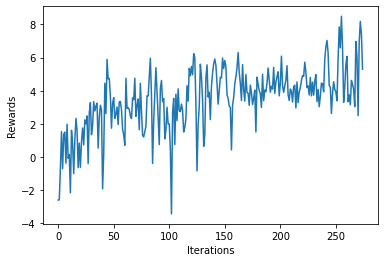

 28%|████████████████████▏                                                    | 27604/100000 [18:28<1:07:49, 17.79it/s]

Updated Weights
Mean Reward = 6.92
30


 28%|████████████████████▊                                                      | 27704/100000 [18:33<54:35, 22.07it/s]

Updated Weights
Mean Reward = 7.4
32


 28%|████████████████████▎                                                    | 27803/100000 [18:38<1:08:18, 17.61it/s]

Updated Weights
Mean Reward = 6.78
28


 28%|████████████████████▉                                                      | 27903/100000 [18:43<59:04, 20.34it/s]

Updated Weights
Mean Reward = 7.87
33


 28%|████████████████████▍                                                    | 28000/100000 [18:47<1:07:29, 17.78it/s]

Updated Weights
Mean Reward = 6.89
29


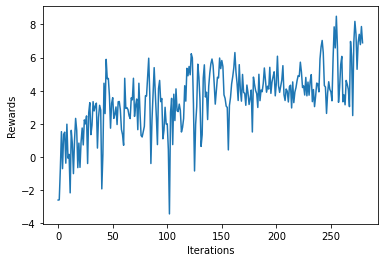

 28%|████████████████████▌                                                    | 28103/100000 [18:53<1:04:25, 18.60it/s]

Updated Weights
Mean Reward = 8.13
32


 28%|█████████████████████▏                                                     | 28204/100000 [18:58<59:24, 20.14it/s]

Updated Weights
Mean Reward = 6.37
35


 28%|█████████████████████▏                                                     | 28304/100000 [19:03<59:57, 19.93it/s]

Updated Weights
Mean Reward = 4.38
34


 28%|████████████████████▋                                                    | 28403/100000 [19:08<1:17:35, 15.38it/s]

Updated Weights
Mean Reward = 7.06
26


 28%|████████████████████▊                                                    | 28500/100000 [19:13<1:02:17, 19.13it/s]

Updated Weights
Mean Reward = 7.26
31


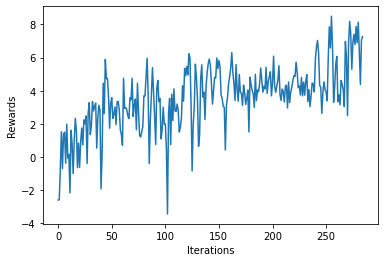

 29%|████████████████████▉                                                    | 28604/100000 [19:18<1:01:20, 19.40it/s]

Updated Weights
Mean Reward = 6.73
26


 29%|████████████████████▉                                                    | 28703/100000 [19:23<1:07:05, 17.71it/s]

Updated Weights
Mean Reward = 5.39
17


 29%|█████████████████████▌                                                     | 28805/100000 [19:28<49:27, 23.99it/s]

Updated Weights
Mean Reward = 5.33
26


 29%|█████████████████████                                                    | 28903/100000 [19:33<1:03:30, 18.66it/s]

Updated Weights
Mean Reward = 6.68
33


 29%|█████████████████████▊                                                     | 29000/100000 [19:38<56:18, 21.01it/s]

Updated Weights
Mean Reward = 6.5
28


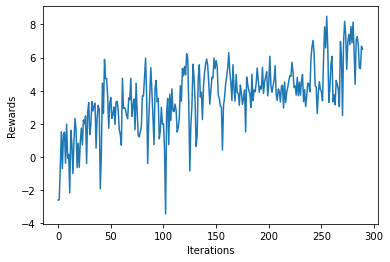

 29%|█████████████████████▏                                                   | 29104/100000 [19:43<1:12:12, 16.37it/s]

Updated Weights
Mean Reward = 5.1
19


 29%|█████████████████████▎                                                   | 29203/100000 [19:48<1:05:03, 18.14it/s]

Updated Weights
Mean Reward = 5.97
29


 29%|█████████████████████▉                                                     | 29302/100000 [19:53<54:53, 21.47it/s]

Updated Weights
Mean Reward = 7.04
40


 29%|█████████████████████▍                                                   | 29403/100000 [19:58<1:07:01, 17.56it/s]

Updated Weights
Mean Reward = 3.17
22


 30%|█████████████████████▌                                                   | 29500/100000 [20:03<1:07:12, 17.48it/s]

Updated Weights
Mean Reward = 4.18
17


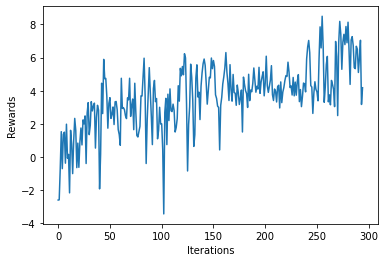

 30%|██████████████████████▏                                                    | 29605/100000 [20:09<59:33, 19.70it/s]

Updated Weights
Mean Reward = 5.2
25


 30%|█████████████████████▋                                                   | 29704/100000 [20:14<1:00:31, 19.36it/s]

Updated Weights
Mean Reward = 5.75
22


 30%|██████████████████████▎                                                    | 29805/100000 [20:19<55:15, 21.17it/s]

Updated Weights
Mean Reward = 6.65
29


 30%|█████████████████████▊                                                   | 29903/100000 [20:23<1:05:02, 17.96it/s]

Updated Weights
Mean Reward = 6.24
30


 30%|█████████████████████▉                                                   | 30000/100000 [20:28<1:00:28, 19.29it/s]

Updated Weights
Mean Reward = 5.99
28


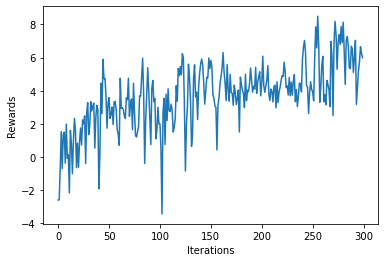

 30%|█████████████████████▉                                                   | 30104/100000 [20:34<1:08:44, 16.95it/s]

Updated Weights
Mean Reward = 4.25
16


 30%|██████████████████████▋                                                    | 30202/100000 [20:39<59:11, 19.65it/s]

Updated Weights
Mean Reward = 5.0
20


 30%|██████████████████████▋                                                    | 30305/100000 [20:44<50:42, 22.91it/s]

Updated Weights
Mean Reward = 6.98
31


 30%|██████████████████████▏                                                  | 30404/100000 [20:49<1:09:50, 16.61it/s]

Updated Weights
Mean Reward = 5.43
22


 30%|██████████████████████▎                                                  | 30500/100000 [20:55<1:06:36, 17.39it/s]

Updated Weights
Mean Reward = 5.14
20


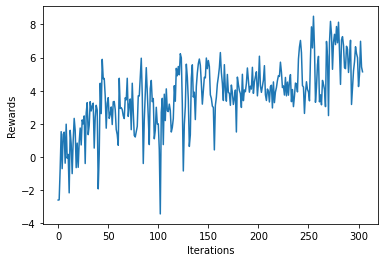

 31%|██████████████████████▉                                                    | 30606/100000 [21:00<53:21, 21.67it/s]

Updated Weights
Mean Reward = 5.9
20


 31%|██████████████████████▍                                                  | 30704/100000 [21:05<1:06:23, 17.40it/s]

Updated Weights
Mean Reward = 4.65
36


 31%|██████████████████████▍                                                  | 30804/100000 [21:10<1:02:56, 18.32it/s]

Updated Weights
Mean Reward = 2.81
12


 31%|██████████████████████▌                                                  | 30904/100000 [21:16<1:00:47, 18.94it/s]

Updated Weights
Mean Reward = 2.21
10


 31%|███████████████████████▏                                                   | 30998/100000 [21:21<58:15, 19.74it/s]

Updated Weights
Mean Reward = 3.54
15


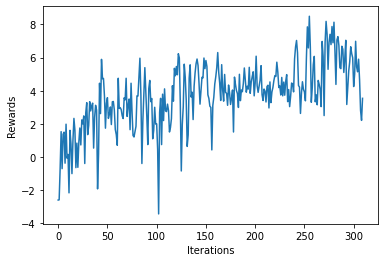

 31%|██████████████████████▋                                                  | 31104/100000 [21:27<1:09:05, 16.62it/s]

Updated Weights
Mean Reward = 3.61
22


 31%|██████████████████████▊                                                  | 31205/100000 [21:32<1:01:09, 18.75it/s]

Updated Weights
Mean Reward = 1.79
12


 31%|██████████████████████▊                                                  | 31304/100000 [21:37<1:07:23, 16.99it/s]

Updated Weights
Mean Reward = 4.36
19


 31%|██████████████████████▉                                                  | 31403/100000 [21:42<1:01:19, 18.64it/s]

Updated Weights
Mean Reward = 5.56
24


 31%|██████████████████████▉                                                  | 31499/100000 [21:47<1:01:50, 18.46it/s]

Updated Weights
Mean Reward = 4.42
23


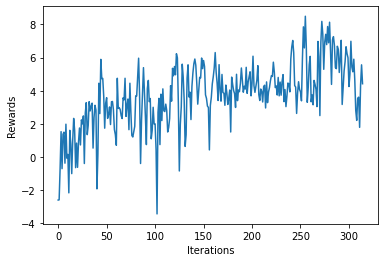

 32%|███████████████████████▋                                                   | 31601/100000 [21:53<51:00, 22.35it/s]

Updated Weights
Mean Reward = 5.03
24


 32%|███████████████████████▊                                                   | 31702/100000 [21:58<48:51, 23.30it/s]

Updated Weights
Mean Reward = 5.51
26


 32%|███████████████████████▊                                                   | 31804/100000 [22:03<52:22, 21.70it/s]

Updated Weights
Mean Reward = 7.42
31


 32%|███████████████████████▉                                                   | 31903/100000 [22:08<59:42, 19.01it/s]

Updated Weights
Mean Reward = 6.66
25


 32%|███████████████████████▉                                                   | 31998/100000 [22:13<53:05, 21.34it/s]

Updated Weights
Mean Reward = 8.0
32


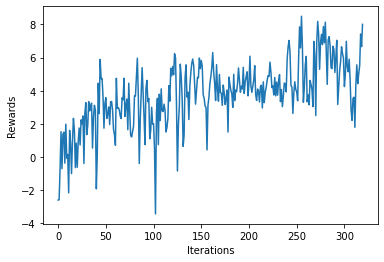

 32%|████████████████████████                                                   | 32103/100000 [22:18<50:29, 22.41it/s]

Updated Weights
Mean Reward = 6.78
23


 32%|████████████████████████▏                                                  | 32204/100000 [22:23<51:55, 21.76it/s]

Updated Weights
Mean Reward = 8.67
40


 32%|████████████████████████▏                                                  | 32304/100000 [22:28<54:01, 20.89it/s]

Updated Weights
Mean Reward = 6.96
35


 32%|███████████████████████▋                                                 | 32403/100000 [22:33<1:05:26, 17.22it/s]

Updated Weights
Mean Reward = 6.55
26


 32%|███████████████████████▋                                                 | 32500/100000 [22:38<1:01:41, 18.24it/s]

Updated Weights
Mean Reward = 6.36
31


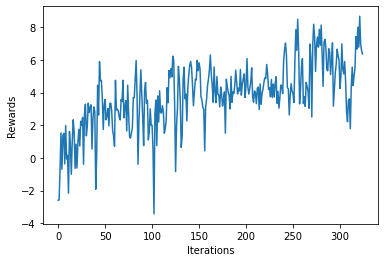

 33%|███████████████████████▊                                                 | 32604/100000 [22:44<1:04:59, 17.28it/s]

Updated Weights
Mean Reward = 4.27
27


 33%|███████████████████████▊                                                 | 32703/100000 [22:49<1:04:22, 17.42it/s]

Updated Weights
Mean Reward = 4.19
8


 33%|████████████████████████▌                                                  | 32805/100000 [22:54<50:48, 22.04it/s]

Updated Weights
Mean Reward = 5.92
20


 33%|████████████████████████▋                                                  | 32903/100000 [22:59<45:51, 24.38it/s]

Updated Weights
Mean Reward = 9.75
46


 33%|████████████████████████                                                 | 32999/100000 [23:03<1:00:58, 18.31it/s]

Updated Weights
Mean Reward = 8.36
38


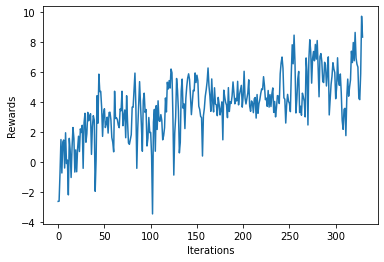

 33%|████████████████████████▏                                                | 33102/100000 [23:09<1:05:16, 17.08it/s]

Updated Weights
Mean Reward = 4.48
19


 33%|████████████████████████▉                                                  | 33204/100000 [23:14<50:36, 21.99it/s]

Updated Weights
Mean Reward = 7.38
32


 33%|████████████████████████▉                                                  | 33305/100000 [23:19<59:46, 18.60it/s]

Updated Weights
Mean Reward = 6.36
29


 33%|█████████████████████████                                                  | 33404/100000 [23:24<54:48, 20.25it/s]

Updated Weights
Mean Reward = 6.63
29


 34%|█████████████████████████▏                                                 | 33500/100000 [23:29<49:48, 22.25it/s]

Updated Weights
Mean Reward = 7.13
28


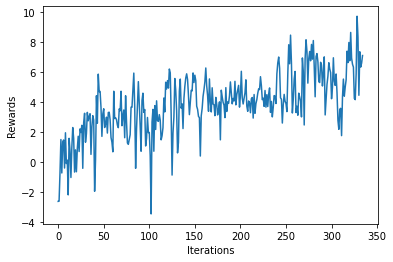

 34%|█████████████████████████▏                                                 | 33604/100000 [23:34<55:16, 20.02it/s]

Updated Weights
Mean Reward = 8.62
41


 34%|█████████████████████████▎                                                 | 33702/100000 [23:38<48:16, 22.89it/s]

Updated Weights
Mean Reward = 6.6
34


 34%|█████████████████████████▎                                                 | 33807/100000 [23:43<44:35, 24.74it/s]

Updated Weights
Mean Reward = 6.67
28


 34%|████████████████████████▋                                                | 33903/100000 [23:48<1:06:55, 16.46it/s]

Updated Weights
Mean Reward = 6.87
33


 34%|█████████████████████████▌                                                 | 34000/100000 [23:53<50:51, 21.63it/s]

Updated Weights
Mean Reward = 6.84
35


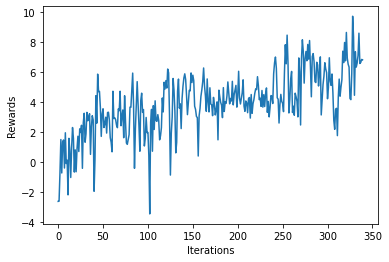

 34%|████████████████████████▉                                                | 34103/100000 [23:59<1:03:30, 17.29it/s]

Updated Weights
Mean Reward = 5.77
23


 34%|████████████████████████▉                                                | 34203/100000 [24:04<1:04:37, 16.97it/s]

Updated Weights
Mean Reward = 4.58
28


 34%|█████████████████████████                                                | 34303/100000 [24:10<1:07:49, 16.14it/s]

Updated Weights
Mean Reward = 5.0
20


 34%|█████████████████████████                                                | 34403/100000 [24:15<1:06:33, 16.42it/s]

Updated Weights
Mean Reward = 6.07
26


 34%|█████████████████████████▏                                               | 34499/100000 [24:20<1:03:27, 17.21it/s]

Updated Weights
Mean Reward = 6.47
26


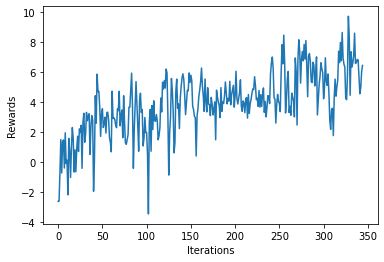

 35%|█████████████████████████▉                                                 | 34603/100000 [24:26<55:31, 19.63it/s]

Updated Weights
Mean Reward = 6.07
20


 35%|██████████████████████████                                                 | 34703/100000 [24:31<49:01, 22.20it/s]

Updated Weights
Mean Reward = 7.47
29


 35%|██████████████████████████                                                 | 34803/100000 [24:36<42:04, 25.82it/s]

Updated Weights
Mean Reward = 6.78
29


 35%|██████████████████████████▏                                                | 34903/100000 [24:40<46:55, 23.12it/s]

Updated Weights
Mean Reward = 8.13
44


 35%|██████████████████████████▏                                                | 34998/100000 [24:45<49:54, 21.71it/s]

Updated Weights
Mean Reward = 5.35
25


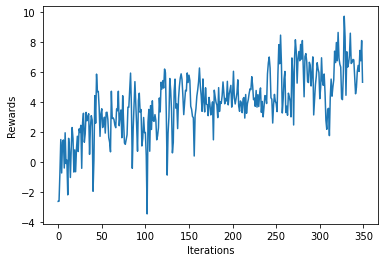

 35%|██████████████████████████▎                                                | 35105/100000 [24:51<50:45, 21.31it/s]

Updated Weights
Mean Reward = 6.61
28


 35%|██████████████████████████▍                                                | 35205/100000 [24:56<44:47, 24.11it/s]

Updated Weights
Mean Reward = 6.34
28


 35%|█████████████████████████▊                                               | 35304/100000 [25:01<1:07:08, 16.06it/s]

Updated Weights
Mean Reward = 5.3
22


 35%|██████████████████████████▌                                                | 35405/100000 [25:06<51:21, 20.96it/s]

Updated Weights
Mean Reward = 6.44
31


 35%|██████████████████████████▌                                                | 35497/100000 [25:11<44:41, 24.06it/s]

Updated Weights
Mean Reward = 7.3
35


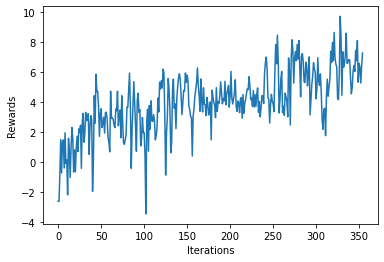

 36%|██████████████████████████▋                                                | 35603/100000 [25:16<57:52, 18.55it/s]

Updated Weights
Mean Reward = 5.83
34


 36%|██████████████████████████                                               | 35704/100000 [25:21<1:04:25, 16.63it/s]

Updated Weights
Mean Reward = 7.76
34


 36%|██████████████████████████▊                                                | 35803/100000 [25:25<50:55, 21.01it/s]

Updated Weights
Mean Reward = 8.41
37


 36%|██████████████████████████▉                                                | 35904/100000 [25:30<51:43, 20.66it/s]

Updated Weights
Mean Reward = 8.7
39


 36%|██████████████████████████▉                                                | 35999/100000 [25:35<49:47, 21.42it/s]

Updated Weights
Mean Reward = 8.38
36


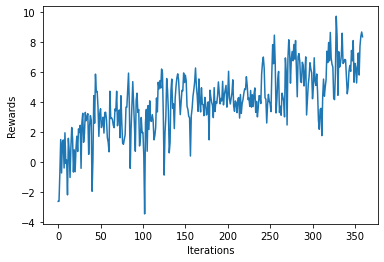

 36%|███████████████████████████                                                | 36103/100000 [25:40<47:41, 22.33it/s]

Updated Weights
Mean Reward = 7.19
30


 36%|███████████████████████████▏                                               | 36205/100000 [25:44<39:56, 26.62it/s]

Updated Weights
Mean Reward = 8.7
43


 36%|███████████████████████████▏                                               | 36302/100000 [25:49<50:21, 21.08it/s]

Updated Weights
Mean Reward = 7.8
40


 36%|██████████████████████████▌                                              | 36404/100000 [25:53<1:00:29, 17.52it/s]

Updated Weights
Mean Reward = 7.59
37


 36%|███████████████████████████▎                                               | 36497/100000 [25:58<44:28, 23.80it/s]

Updated Weights
Mean Reward = 7.03
39


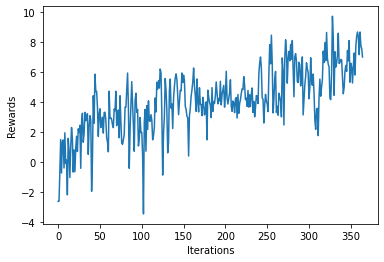

 37%|███████████████████████████▍                                               | 36603/100000 [26:02<39:04, 27.04it/s]

Updated Weights
Mean Reward = 8.85
44


 37%|███████████████████████████▌                                               | 36706/100000 [26:08<51:58, 20.29it/s]

Updated Weights
Mean Reward = 4.63
22


 37%|███████████████████████████▌                                               | 36803/100000 [26:12<44:53, 23.46it/s]

Updated Weights
Mean Reward = 8.88
41


 37%|███████████████████████████▋                                               | 36904/100000 [26:17<48:08, 21.85it/s]

Updated Weights
Mean Reward = 7.63
36


 37%|███████████████████████████▋                                               | 36999/100000 [26:21<55:16, 19.00it/s]

Updated Weights
Mean Reward = 7.25
31


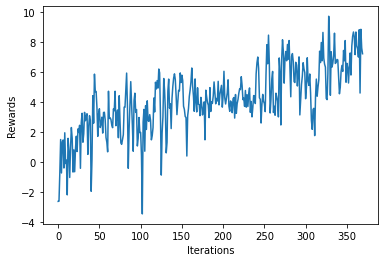

 37%|███████████████████████████▊                                               | 37103/100000 [26:26<48:47, 21.48it/s]

Updated Weights
Mean Reward = 7.43
33


 37%|███████████████████████████▉                                               | 37203/100000 [26:30<35:58, 29.09it/s]

Updated Weights
Mean Reward = 7.43
42


 37%|███████████████████████████▉                                               | 37304/100000 [26:35<52:44, 19.81it/s]

Updated Weights
Mean Reward = 4.01
43


 37%|████████████████████████████                                               | 37403/100000 [26:40<54:59, 18.97it/s]

Updated Weights
Mean Reward = 5.91
27


 37%|████████████████████████████                                               | 37499/100000 [26:44<56:46, 18.35it/s]

Updated Weights
Mean Reward = 6.1
38


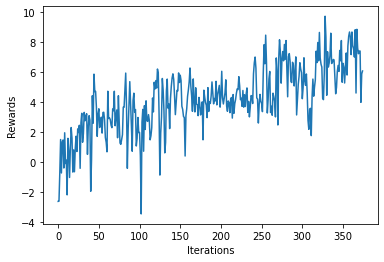

 38%|████████████████████████████▏                                              | 37606/100000 [26:50<49:53, 20.85it/s]

Updated Weights
Mean Reward = 6.17
24


 38%|████████████████████████████▎                                              | 37706/100000 [26:53<40:54, 25.38it/s]

Updated Weights
Mean Reward = 6.19
36


 38%|████████████████████████████▎                                              | 37804/100000 [26:57<38:13, 27.12it/s]

Updated Weights
Mean Reward = 5.24
26


 38%|████████████████████████████▍                                              | 37904/100000 [27:01<39:03, 26.49it/s]

Updated Weights
Mean Reward = 5.72
28


 38%|████████████████████████████▍                                              | 37997/100000 [27:04<39:35, 26.11it/s]

Updated Weights
Mean Reward = 6.39
29


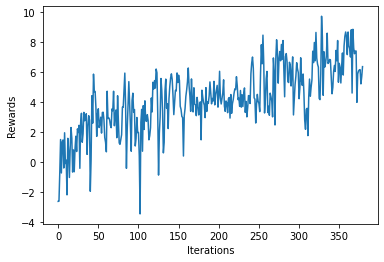

 38%|████████████████████████████▌                                              | 38103/100000 [27:08<40:22, 25.55it/s]

Updated Weights
Mean Reward = 8.18
33


 38%|████████████████████████████▋                                              | 38202/100000 [27:11<35:32, 28.98it/s]

Updated Weights
Mean Reward = 7.14
31


 38%|████████████████████████████▋                                              | 38306/100000 [27:15<35:52, 28.66it/s]

Updated Weights
Mean Reward = 5.93
33


 38%|████████████████████████████▊                                              | 38404/100000 [27:18<38:22, 26.75it/s]

Updated Weights
Mean Reward = 5.88
27


 38%|████████████████████████████▉                                              | 38500/100000 [27:22<42:39, 24.03it/s]

Updated Weights
Mean Reward = 5.35
18


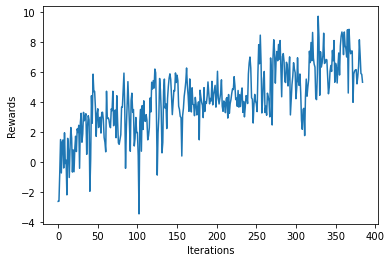

 39%|████████████████████████████▉                                              | 38603/100000 [27:26<36:15, 28.22it/s]

Updated Weights
Mean Reward = 6.59
29


 39%|█████████████████████████████                                              | 38706/100000 [27:30<35:26, 28.82it/s]

Updated Weights
Mean Reward = 7.16
29


 39%|█████████████████████████████                                              | 38803/100000 [27:33<39:04, 26.10it/s]

Updated Weights
Mean Reward = 6.94
25


 39%|█████████████████████████████▏                                             | 38906/100000 [27:36<36:34, 27.84it/s]

Updated Weights
Mean Reward = 6.27
32


 39%|█████████████████████████████▎                                             | 39000/100000 [27:40<34:01, 29.88it/s]

Updated Weights
Mean Reward = 5.74
24


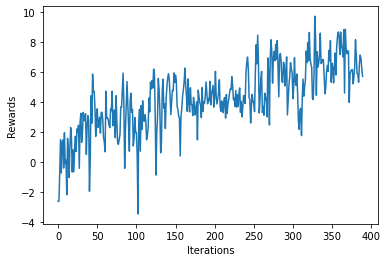

 39%|█████████████████████████████▎                                             | 39108/100000 [27:44<33:07, 30.63it/s]

Updated Weights
Mean Reward = 6.18
23


 39%|█████████████████████████████▍                                             | 39204/100000 [27:48<38:21, 26.41it/s]

Updated Weights
Mean Reward = 7.32
29


 39%|█████████████████████████████▍                                             | 39304/100000 [27:51<36:38, 27.61it/s]

Updated Weights
Mean Reward = 7.09
33


 39%|█████████████████████████████▌                                             | 39402/100000 [27:55<33:46, 29.90it/s]

Updated Weights
Mean Reward = 8.56
39


 39%|█████████████████████████████▌                                             | 39497/100000 [27:59<36:58, 27.27it/s]

Updated Weights
Mean Reward = 6.65
24


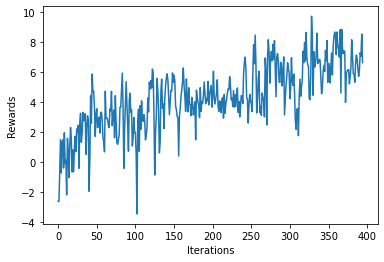

 40%|█████████████████████████████▋                                             | 39606/100000 [28:03<31:34, 31.87it/s]

Updated Weights
Mean Reward = 7.51
33


 40%|█████████████████████████████▊                                             | 39706/100000 [28:06<35:08, 28.60it/s]

Updated Weights
Mean Reward = 7.73
37


 40%|█████████████████████████████▊                                             | 39805/100000 [28:09<36:17, 27.64it/s]

Updated Weights
Mean Reward = 7.55
37


 40%|█████████████████████████████▉                                             | 39905/100000 [28:13<33:49, 29.61it/s]

Updated Weights
Mean Reward = 8.43
40


 40%|█████████████████████████████▉                                             | 39997/100000 [28:16<32:04, 31.18it/s]

Updated Weights
Mean Reward = 8.21
40


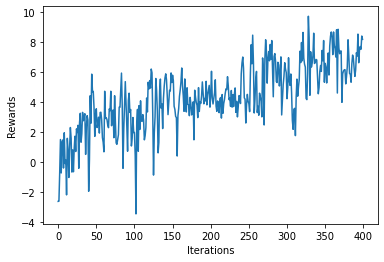

 40%|██████████████████████████████                                             | 40103/100000 [28:19<33:12, 30.06it/s]

Updated Weights
Mean Reward = 6.57
42


 40%|██████████████████████████████▏                                            | 40206/100000 [28:23<38:30, 25.88it/s]

Updated Weights
Mean Reward = 3.55
16


 40%|██████████████████████████████▏                                            | 40303/100000 [28:27<35:18, 28.18it/s]

Updated Weights
Mean Reward = 6.42
23


 40%|██████████████████████████████▎                                            | 40405/100000 [28:31<34:02, 29.17it/s]

Updated Weights
Mean Reward = 7.74
34


 40%|██████████████████████████████▎                                            | 40499/100000 [28:34<35:24, 28.00it/s]

Updated Weights
Mean Reward = 7.68
31


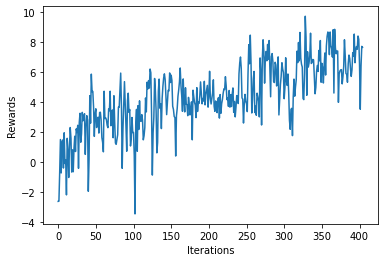

 41%|██████████████████████████████▍                                            | 40605/100000 [28:37<31:37, 31.29it/s]

Updated Weights
Mean Reward = 7.52
40


 41%|██████████████████████████████▌                                            | 40706/100000 [28:41<29:51, 33.09it/s]

Updated Weights
Mean Reward = 4.13
23


 41%|██████████████████████████████▌                                            | 40804/100000 [28:44<31:08, 31.69it/s]

Updated Weights
Mean Reward = 6.88
40


 41%|██████████████████████████████▋                                            | 40903/100000 [28:48<37:53, 25.99it/s]

Updated Weights
Mean Reward = 4.78
20


 41%|██████████████████████████████▋                                            | 40998/100000 [28:51<30:26, 32.30it/s]

Updated Weights
Mean Reward = 6.68
31


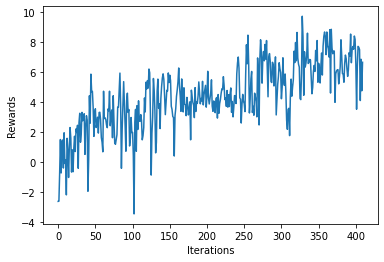

 41%|██████████████████████████████▊                                            | 41106/100000 [28:55<35:55, 27.32it/s]

Updated Weights
Mean Reward = 6.01
24


 41%|██████████████████████████████▉                                            | 41203/100000 [28:59<45:07, 21.72it/s]

Updated Weights
Mean Reward = 8.45
42


 41%|██████████████████████████████▉                                            | 41305/100000 [29:04<40:36, 24.09it/s]

Updated Weights
Mean Reward = 6.54
29


 41%|███████████████████████████████                                            | 41403/100000 [29:08<44:47, 21.81it/s]

Updated Weights
Mean Reward = 9.46
47


 42%|███████████████████████████████▏                                           | 41500/100000 [29:12<38:49, 25.12it/s]

Updated Weights
Mean Reward = 8.56
43


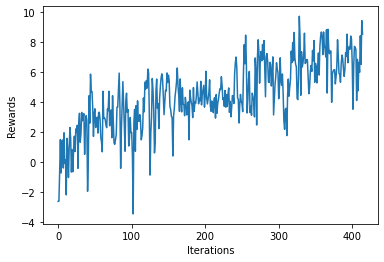

 42%|███████████████████████████████▏                                           | 41604/100000 [29:17<45:54, 21.20it/s]

Updated Weights
Mean Reward = 3.2
31


 42%|███████████████████████████████▎                                           | 41705/100000 [29:23<52:44, 18.42it/s]

Updated Weights
Mean Reward = 2.57
8


 42%|███████████████████████████████▎                                           | 41805/100000 [29:28<49:38, 19.54it/s]

Updated Weights
Mean Reward = 5.61
23


 42%|███████████████████████████████▍                                           | 41906/100000 [29:33<36:43, 26.36it/s]

Updated Weights
Mean Reward = 6.51
34


 42%|███████████████████████████████▍                                           | 41998/100000 [29:37<41:11, 23.47it/s]

Updated Weights
Mean Reward = 6.94
31


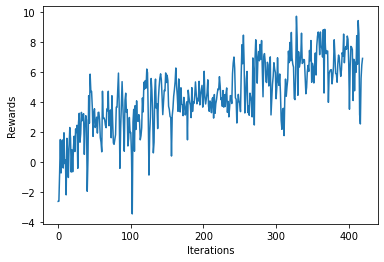

 42%|███████████████████████████████▌                                           | 42105/100000 [29:42<39:14, 24.59it/s]

Updated Weights
Mean Reward = 8.23
42


 42%|███████████████████████████████▋                                           | 42203/100000 [29:47<50:50, 18.95it/s]

Updated Weights
Mean Reward = 7.88
38


 42%|███████████████████████████████▋                                           | 42302/100000 [29:51<47:03, 20.44it/s]

Updated Weights
Mean Reward = 6.95
35


 42%|███████████████████████████████▊                                           | 42404/100000 [29:56<41:58, 22.87it/s]

Updated Weights
Mean Reward = 6.69
45


 42%|███████████████████████████████▊                                           | 42497/100000 [30:00<31:29, 30.43it/s]

Updated Weights
Mean Reward = 8.8
47


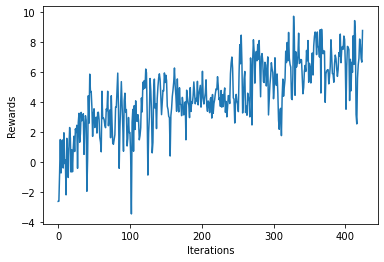

 43%|███████████████████████████████▉                                           | 42602/100000 [30:04<44:57, 21.28it/s]

Updated Weights
Mean Reward = 7.59
45


 43%|████████████████████████████████                                           | 42704/100000 [30:09<52:37, 18.15it/s]

Updated Weights
Mean Reward = 2.37
21


 43%|████████████████████████████████                                           | 42802/100000 [30:14<45:15, 21.07it/s]

Updated Weights
Mean Reward = 3.51
20


 43%|████████████████████████████████▏                                          | 42902/100000 [30:19<46:55, 20.28it/s]

Updated Weights
Mean Reward = 7.08
32


 43%|████████████████████████████████▏                                          | 42998/100000 [30:24<43:30, 21.84it/s]

Updated Weights
Mean Reward = 5.19
24


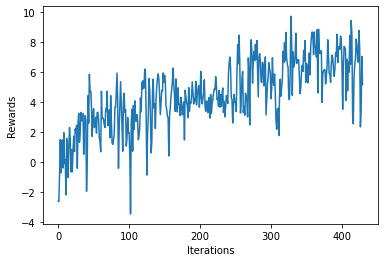

 43%|████████████████████████████████▎                                          | 43105/100000 [30:29<41:30, 22.84it/s]

Updated Weights
Mean Reward = 8.29
37


 43%|████████████████████████████████▍                                          | 43203/100000 [30:33<35:53, 26.38it/s]

Updated Weights
Mean Reward = 8.25
40


 43%|████████████████████████████████▍                                          | 43305/100000 [30:38<44:27, 21.26it/s]

Updated Weights
Mean Reward = 7.85
36


 43%|████████████████████████████████▌                                          | 43404/100000 [30:42<44:19, 21.28it/s]

Updated Weights
Mean Reward = 7.68
38


 43%|████████████████████████████████▌                                          | 43499/100000 [30:47<46:45, 20.14it/s]

Updated Weights
Mean Reward = 7.72
37


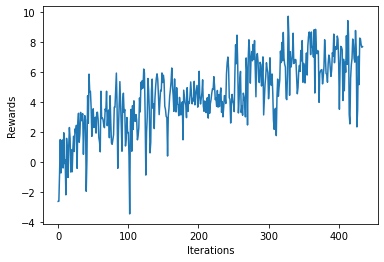

 44%|████████████████████████████████▋                                          | 43605/100000 [30:52<40:09, 23.41it/s]

Updated Weights
Mean Reward = 7.46
35


 44%|████████████████████████████████▊                                          | 43704/100000 [30:56<42:51, 21.89it/s]

Updated Weights
Mean Reward = 9.17
49


 44%|████████████████████████████████▊                                          | 43804/100000 [31:00<31:07, 30.10it/s]

Updated Weights
Mean Reward = 7.09
44


 44%|████████████████████████████████▉                                          | 43903/100000 [31:04<37:00, 25.27it/s]

Updated Weights
Mean Reward = 7.68
49


 44%|████████████████████████████████▉                                          | 43998/100000 [31:08<47:14, 19.75it/s]

Updated Weights
Mean Reward = 9.09
47


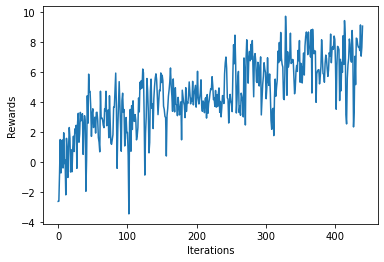

 44%|█████████████████████████████████                                          | 44103/100000 [31:14<50:04, 18.60it/s]

Updated Weights
Mean Reward = 3.92
20


 44%|█████████████████████████████████▏                                         | 44204/100000 [31:19<40:15, 23.10it/s]

Updated Weights
Mean Reward = 5.65
27


 44%|█████████████████████████████████▏                                         | 44303/100000 [31:24<49:04, 18.91it/s]

Updated Weights
Mean Reward = 8.03
36


 44%|█████████████████████████████████▎                                         | 44404/100000 [31:29<44:05, 21.01it/s]

Updated Weights
Mean Reward = 6.33
28


 44%|█████████████████████████████████▎                                         | 44499/100000 [31:33<42:56, 21.54it/s]

Updated Weights
Mean Reward = 7.88
35


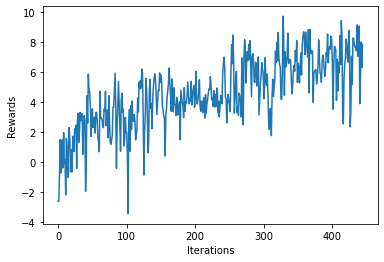

 45%|█████████████████████████████████▍                                         | 44605/100000 [31:38<42:03, 21.95it/s]

Updated Weights
Mean Reward = 5.58
41


 45%|█████████████████████████████████▌                                         | 44703/100000 [31:43<44:45, 20.59it/s]

Updated Weights
Mean Reward = 5.25
22


 45%|█████████████████████████████████▌                                         | 44802/100000 [31:48<44:36, 20.62it/s]

Updated Weights
Mean Reward = 7.92
33


 45%|█████████████████████████████████▋                                         | 44902/100000 [31:52<53:37, 17.13it/s]

Updated Weights
Mean Reward = 7.98
37


 45%|█████████████████████████████████▊                                         | 45000/100000 [31:57<36:13, 25.31it/s]

Updated Weights
Mean Reward = 7.69
39


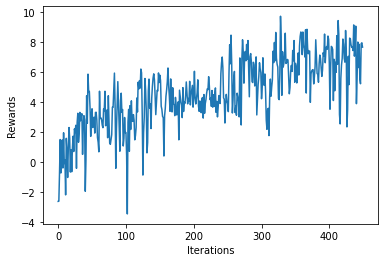

 45%|█████████████████████████████████▊                                         | 45105/100000 [32:02<40:42, 22.48it/s]

Updated Weights
Mean Reward = 7.02
32


 45%|█████████████████████████████████▉                                         | 45204/100000 [32:06<32:45, 27.88it/s]

Updated Weights
Mean Reward = 8.64
44


 45%|█████████████████████████████████▉                                         | 45303/100000 [32:11<44:25, 20.52it/s]

Updated Weights
Mean Reward = 7.3
35


 45%|██████████████████████████████████                                         | 45405/100000 [32:15<31:47, 28.62it/s]

Updated Weights
Mean Reward = 8.94
47


 46%|██████████████████████████████████▏                                        | 45500/100000 [32:19<42:23, 21.43it/s]

Updated Weights
Mean Reward = 7.95
47


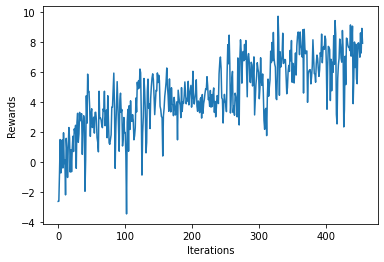

 46%|██████████████████████████████████▏                                        | 45603/100000 [32:24<40:44, 22.26it/s]

Updated Weights
Mean Reward = 6.16
38


 46%|██████████████████████████████████▎                                        | 45703/100000 [32:29<51:00, 17.74it/s]

Updated Weights
Mean Reward = 2.73
32


 46%|██████████████████████████████████▎                                        | 45803/100000 [32:35<48:40, 18.56it/s]

Updated Weights
Mean Reward = 6.08
28


 46%|██████████████████████████████████▍                                        | 45903/100000 [32:40<51:22, 17.55it/s]

Updated Weights
Mean Reward = 6.6
28


 46%|██████████████████████████████████▌                                        | 46000/100000 [32:45<44:14, 20.34it/s]

Updated Weights
Mean Reward = 7.23
35


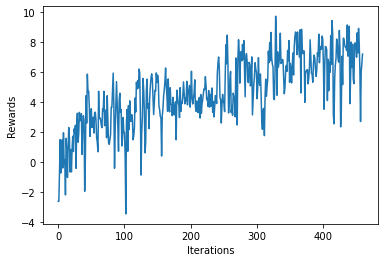

 46%|██████████████████████████████████▌                                        | 46104/100000 [32:50<41:53, 21.44it/s]

Updated Weights
Mean Reward = 7.0
31


 46%|██████████████████████████████████▋                                        | 46202/100000 [32:54<52:23, 17.11it/s]

Updated Weights
Mean Reward = 6.25
26


 46%|██████████████████████████████████▋                                        | 46305/100000 [32:59<46:44, 19.15it/s]

Updated Weights
Mean Reward = 5.33
26


 46%|██████████████████████████████████▊                                        | 46402/100000 [33:04<46:43, 19.12it/s]

Updated Weights
Mean Reward = 6.33
26


 46%|██████████████████████████████████▉                                        | 46500/100000 [33:09<51:01, 17.47it/s]

Updated Weights
Mean Reward = 5.29
30


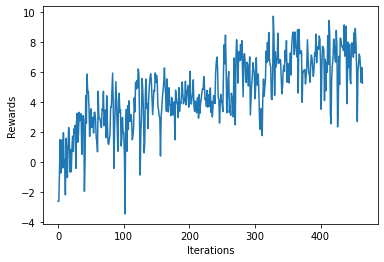

 47%|██████████████████████████████████▉                                        | 46604/100000 [33:15<50:47, 17.52it/s]

Updated Weights
Mean Reward = 6.08
23


 47%|███████████████████████████████████                                        | 46705/100000 [33:20<44:30, 19.96it/s]

Updated Weights
Mean Reward = 6.3
26


 47%|███████████████████████████████████                                        | 46802/100000 [33:25<38:09, 23.23it/s]

Updated Weights
Mean Reward = 7.12
32


 47%|███████████████████████████████████▏                                       | 46905/100000 [33:30<42:30, 20.82it/s]

Updated Weights
Mean Reward = 6.42
28


 47%|███████████████████████████████████▏                                       | 46998/100000 [33:34<43:47, 20.17it/s]

Updated Weights
Mean Reward = 6.55
28


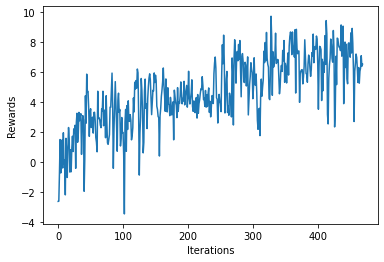

 47%|███████████████████████████████████▎                                       | 47103/100000 [33:39<39:05, 22.55it/s]

Updated Weights
Mean Reward = 7.95
36


 47%|███████████████████████████████████▍                                       | 47204/100000 [33:44<35:43, 24.64it/s]

Updated Weights
Mean Reward = 7.4
31


 47%|███████████████████████████████████▍                                       | 47303/100000 [33:49<40:34, 21.64it/s]

Updated Weights
Mean Reward = 7.23
34


 47%|███████████████████████████████████▌                                       | 47404/100000 [33:54<35:50, 24.46it/s]

Updated Weights
Mean Reward = 6.44
27


 48%|███████████████████████████████████▋                                       | 47500/100000 [33:58<40:35, 21.55it/s]

Updated Weights
Mean Reward = 8.58
39


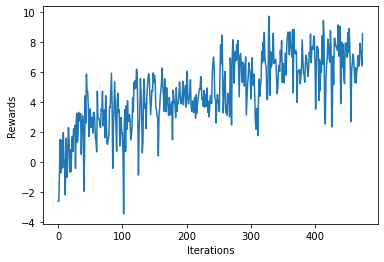

 48%|███████████████████████████████████▋                                       | 47605/100000 [34:03<33:08, 26.35it/s]

Updated Weights
Mean Reward = 7.51
36


 48%|███████████████████████████████████▊                                       | 47703/100000 [34:08<40:28, 21.53it/s]

Updated Weights
Mean Reward = 7.18
32


 48%|███████████████████████████████████▊                                       | 47804/100000 [34:12<39:05, 22.25it/s]

Updated Weights
Mean Reward = 7.18
35


 48%|███████████████████████████████████▉                                       | 47905/100000 [34:17<33:39, 25.79it/s]

Updated Weights
Mean Reward = 8.24
46


 48%|███████████████████████████████████▉                                       | 47998/100000 [34:21<37:07, 23.35it/s]

Updated Weights
Mean Reward = 6.42
43


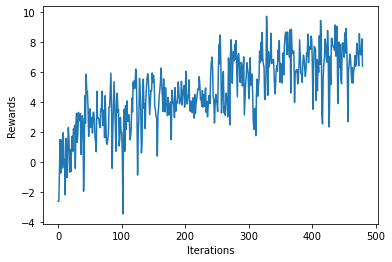

 48%|████████████████████████████████████                                       | 48104/100000 [34:26<35:15, 24.53it/s]

Updated Weights
Mean Reward = 7.49
39


 48%|████████████████████████████████████▏                                      | 48205/100000 [34:30<36:55, 23.38it/s]

Updated Weights
Mean Reward = 7.54
39


 48%|████████████████████████████████████▏                                      | 48307/100000 [34:34<35:00, 24.61it/s]

Updated Weights
Mean Reward = 7.3
43


 48%|████████████████████████████████████▎                                      | 48404/100000 [34:39<42:55, 20.03it/s]

Updated Weights
Mean Reward = 7.01
40


 48%|████████████████████████████████████▎                                      | 48498/100000 [34:43<46:17, 18.54it/s]

Updated Weights
Mean Reward = 5.32
32


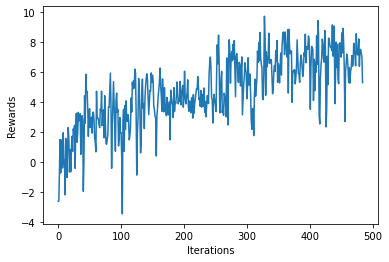

 49%|████████████████████████████████████▍                                      | 48604/100000 [34:49<44:35, 19.21it/s]

Updated Weights
Mean Reward = 5.88
25


 49%|████████████████████████████████████▌                                      | 48704/100000 [34:54<37:56, 22.53it/s]

Updated Weights
Mean Reward = 5.89
29


 49%|████████████████████████████████████▌                                      | 48804/100000 [34:59<39:39, 21.52it/s]

Updated Weights
Mean Reward = 5.42
25


 49%|████████████████████████████████████▋                                      | 48904/100000 [35:04<37:08, 22.93it/s]

Updated Weights
Mean Reward = 7.4
33


 49%|████████████████████████████████████▊                                      | 49000/100000 [35:08<39:38, 21.44it/s]

Updated Weights
Mean Reward = 6.93
30


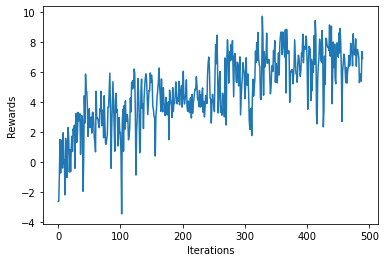

 49%|████████████████████████████████████▊                                      | 49103/100000 [35:13<42:11, 20.11it/s]

Updated Weights
Mean Reward = 8.39
39


 49%|████████████████████████████████████▉                                      | 49203/100000 [35:18<50:10, 16.87it/s]

Updated Weights
Mean Reward = 5.67
35


 49%|████████████████████████████████████▉                                      | 49302/100000 [35:23<42:50, 19.72it/s]

Updated Weights
Mean Reward = 7.06
39


 49%|█████████████████████████████████████                                      | 49403/100000 [35:28<47:50, 17.63it/s]

Updated Weights
Mean Reward = 5.99
34


 50%|█████████████████████████████████████▏                                     | 49500/100000 [35:32<47:06, 17.87it/s]

Updated Weights
Mean Reward = 5.77
28


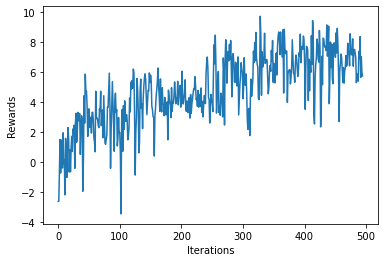

 50%|█████████████████████████████████████▏                                     | 49605/100000 [35:37<29:38, 28.33it/s]

Updated Weights
Mean Reward = 9.43
45


 50%|█████████████████████████████████████▎                                     | 49704/100000 [35:42<40:08, 20.88it/s]

Updated Weights
Mean Reward = 4.3
38


 50%|█████████████████████████████████████▎                                     | 49804/100000 [35:47<43:41, 19.15it/s]

Updated Weights
Mean Reward = 3.25
23


 50%|█████████████████████████████████████▍                                     | 49903/100000 [35:52<45:33, 18.33it/s]

Updated Weights
Mean Reward = 6.57
27


 50%|█████████████████████████████████████▌                                     | 50000/100000 [35:57<43:57, 18.96it/s]

Updated Weights
Mean Reward = 4.94
21


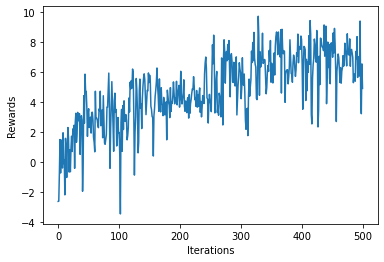

 50%|█████████████████████████████████████▌                                     | 50105/100000 [36:02<40:23, 20.59it/s]

Updated Weights
Mean Reward = 6.72
27


 50%|█████████████████████████████████████▋                                     | 50203/100000 [36:07<41:00, 20.24it/s]

Updated Weights
Mean Reward = 5.85
28


 50%|█████████████████████████████████████▋                                     | 50306/100000 [36:11<34:42, 23.87it/s]

Updated Weights
Mean Reward = 1.67
32


 50%|█████████████████████████████████████▊                                     | 50403/100000 [36:16<34:56, 23.65it/s]

Updated Weights
Mean Reward = 9.85
49


 50%|█████████████████████████████████████▊                                     | 50499/100000 [36:20<40:41, 20.28it/s]

Updated Weights
Mean Reward = 7.31
33


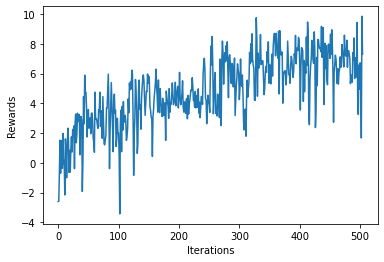

 51%|█████████████████████████████████████▉                                     | 50604/100000 [36:25<40:29, 20.33it/s]

Updated Weights
Mean Reward = 7.34
34


 51%|██████████████████████████████████████                                     | 50704/100000 [36:30<36:26, 22.55it/s]

Updated Weights
Mean Reward = 6.87
31


 51%|██████████████████████████████████████                                     | 50802/100000 [36:34<31:18, 26.19it/s]

Updated Weights
Mean Reward = 8.7
41


 51%|██████████████████████████████████████▏                                    | 50906/100000 [36:39<33:32, 24.40it/s]

Updated Weights
Mean Reward = 7.86
37


 51%|██████████████████████████████████████▏                                    | 50998/100000 [36:43<42:53, 19.04it/s]

Updated Weights
Mean Reward = 5.77
32


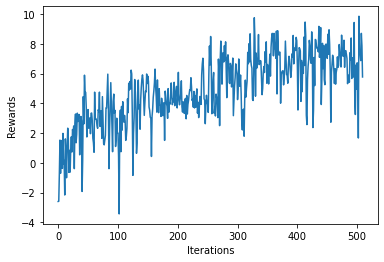

 51%|██████████████████████████████████████▎                                    | 51105/100000 [36:49<38:21, 21.24it/s]

Updated Weights
Mean Reward = 6.3
27


 51%|██████████████████████████████████████▍                                    | 51204/100000 [36:53<38:39, 21.04it/s]

Updated Weights
Mean Reward = 7.38
38


 51%|██████████████████████████████████████▍                                    | 51304/100000 [36:57<34:21, 23.62it/s]

Updated Weights
Mean Reward = 8.36
43


 51%|██████████████████████████████████████▌                                    | 51403/100000 [37:01<31:41, 25.56it/s]

Updated Weights
Mean Reward = 7.9
51


 52%|██████████████████████████████████████▋                                    | 51500/100000 [37:05<34:54, 23.15it/s]

Updated Weights
Mean Reward = 7.45
47


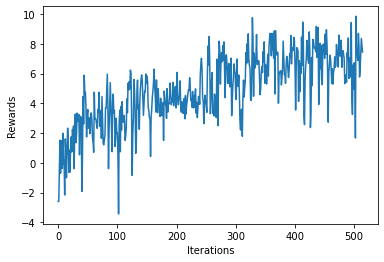

 52%|██████████████████████████████████████▋                                    | 51605/100000 [37:10<38:04, 21.18it/s]

Updated Weights
Mean Reward = 9.12
47


 52%|██████████████████████████████████████▊                                    | 51704/100000 [37:15<42:32, 18.92it/s]

Updated Weights
Mean Reward = 6.85
31


 52%|██████████████████████████████████████▊                                    | 51801/100000 [37:19<37:28, 21.44it/s]

Updated Weights
Mean Reward = 6.74
47


 52%|██████████████████████████████████████▉                                    | 51906/100000 [37:24<35:36, 22.51it/s]

Updated Weights
Mean Reward = 7.22
38


 52%|██████████████████████████████████████▉                                    | 51998/100000 [37:28<36:15, 22.06it/s]

Updated Weights
Mean Reward = 4.95
40


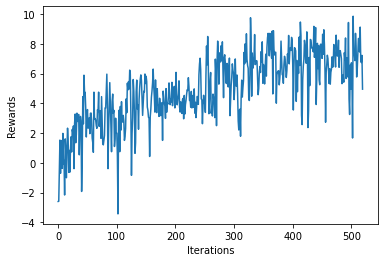

 52%|███████████████████████████████████████                                    | 52103/100000 [37:33<42:53, 18.61it/s]

Updated Weights
Mean Reward = 6.79
40


 52%|███████████████████████████████████████▏                                   | 52203/100000 [37:37<36:30, 21.82it/s]

Updated Weights
Mean Reward = 8.37
39


 52%|███████████████████████████████████████▏                                   | 52304/100000 [37:42<37:37, 21.13it/s]

Updated Weights
Mean Reward = 7.81
38


 52%|███████████████████████████████████████▎                                   | 52406/100000 [37:46<31:24, 25.25it/s]

Updated Weights
Mean Reward = 7.71
43


 52%|███████████████████████████████████████▍                                   | 52500/100000 [37:50<33:51, 23.38it/s]

Updated Weights
Mean Reward = 7.34
49


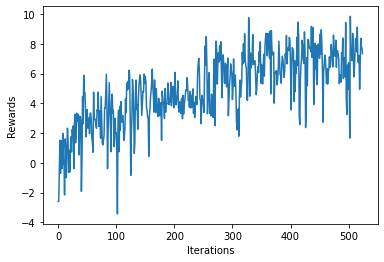

 53%|███████████████████████████████████████▍                                   | 52605/100000 [37:55<35:53, 22.01it/s]

Updated Weights
Mean Reward = 7.43
50


 53%|███████████████████████████████████████▌                                   | 52706/100000 [37:59<32:34, 24.19it/s]

Updated Weights
Mean Reward = 9.09
45


 53%|███████████████████████████████████████▌                                   | 52805/100000 [38:03<28:53, 27.23it/s]

Updated Weights
Mean Reward = 7.78
45


 53%|███████████████████████████████████████▋                                   | 52903/100000 [38:07<34:08, 22.99it/s]

Updated Weights
Mean Reward = 7.2
56


 53%|███████████████████████████████████████▋                                   | 52999/100000 [38:12<39:40, 19.75it/s]

Updated Weights
Mean Reward = 4.03
18


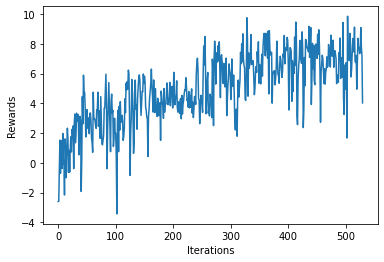

 53%|███████████████████████████████████████▊                                   | 53102/100000 [38:17<37:32, 20.82it/s]

Updated Weights
Mean Reward = 7.23
32


 53%|███████████████████████████████████████▉                                   | 53206/100000 [38:22<30:20, 25.70it/s]

Updated Weights
Mean Reward = 7.69
36


 53%|███████████████████████████████████████▉                                   | 53303/100000 [38:26<37:16, 20.88it/s]

Updated Weights
Mean Reward = 7.63
43


 53%|████████████████████████████████████████                                   | 53403/100000 [38:31<38:19, 20.27it/s]

Updated Weights
Mean Reward = 4.96
38


 53%|████████████████████████████████████████                                   | 53498/100000 [38:35<31:38, 24.49it/s]

Updated Weights
Mean Reward = 3.51
25


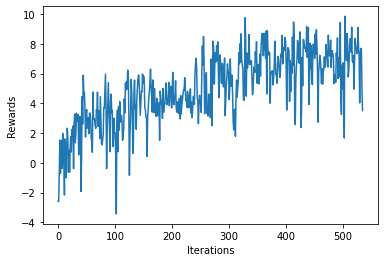

 54%|████████████████████████████████████████▏                                  | 53605/100000 [38:40<40:33, 19.07it/s]

Updated Weights
Mean Reward = 7.81
39


 54%|████████████████████████████████████████▎                                  | 53703/100000 [38:45<33:04, 23.33it/s]

Updated Weights
Mean Reward = 9.09
45


 54%|████████████████████████████████████████▎                                  | 53806/100000 [38:49<30:52, 24.94it/s]

Updated Weights
Mean Reward = 5.11
32


 54%|████████████████████████████████████████▍                                  | 53903/100000 [38:53<28:11, 27.25it/s]

Updated Weights
Mean Reward = 10.05
56


 54%|████████████████████████████████████████▍                                  | 53999/100000 [38:57<30:42, 24.96it/s]

Updated Weights
Mean Reward = 9.86
50


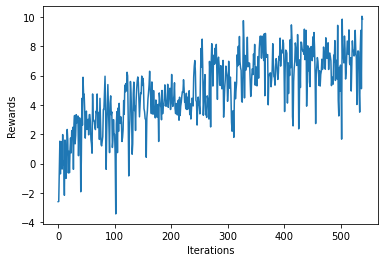

 54%|████████████████████████████████████████▌                                  | 54106/100000 [39:02<35:08, 21.77it/s]

Updated Weights
Mean Reward = 7.39
32


 54%|████████████████████████████████████████▋                                  | 54204/100000 [39:07<33:51, 22.54it/s]

Updated Weights
Mean Reward = 8.48
44


 54%|████████████████████████████████████████▋                                  | 54304/100000 [39:11<34:57, 21.79it/s]

Updated Weights
Mean Reward = 6.95
37


 54%|████████████████████████████████████████▊                                  | 54405/100000 [39:16<32:30, 23.37it/s]

Updated Weights
Mean Reward = 7.13
39


 54%|████████████████████████████████████████▊                                  | 54499/100000 [39:20<32:40, 23.21it/s]

Updated Weights
Mean Reward = 8.73
44


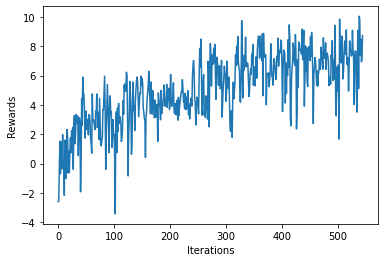

 55%|████████████████████████████████████████▉                                  | 54603/100000 [39:25<30:22, 24.90it/s]

Updated Weights
Mean Reward = 6.54
25


 55%|█████████████████████████████████████████                                  | 54705/100000 [39:30<36:28, 20.70it/s]

Updated Weights
Mean Reward = 8.12
38


 55%|█████████████████████████████████████████                                  | 54805/100000 [39:34<34:22, 21.91it/s]

Updated Weights
Mean Reward = 9.13
44


 55%|█████████████████████████████████████████▏                                 | 54905/100000 [39:38<32:26, 23.17it/s]

Updated Weights
Mean Reward = 8.33
46


 55%|█████████████████████████████████████████▏                                 | 54998/100000 [39:42<24:59, 30.00it/s]

Updated Weights
Mean Reward = 7.59
37


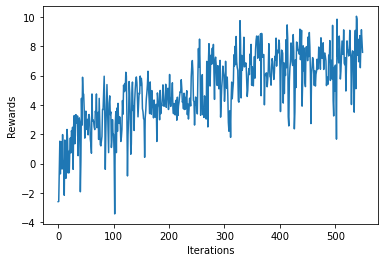

 55%|█████████████████████████████████████████▎                                 | 55105/100000 [39:46<29:16, 25.56it/s]

Updated Weights
Mean Reward = 5.33
24


 55%|█████████████████████████████████████████▍                                 | 55203/100000 [39:49<25:42, 29.04it/s]

Updated Weights
Mean Reward = 7.46
40


 55%|█████████████████████████████████████████▍                                 | 55303/100000 [39:53<31:30, 23.64it/s]

Updated Weights
Mean Reward = 5.54
24


 55%|█████████████████████████████████████████▌                                 | 55406/100000 [39:56<24:54, 29.84it/s]

Updated Weights
Mean Reward = 5.28
25


 55%|█████████████████████████████████████████▌                                 | 55497/100000 [40:00<22:09, 33.46it/s]

Updated Weights
Mean Reward = 5.0
26


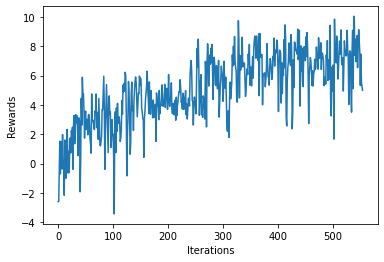

 56%|█████████████████████████████████████████▋                                 | 55605/100000 [40:03<23:51, 31.02it/s]

Updated Weights
Mean Reward = 9.04
50


 56%|█████████████████████████████████████████▊                                 | 55702/100000 [40:06<26:22, 27.99it/s]

Updated Weights
Mean Reward = 6.85
37


 56%|█████████████████████████████████████████▊                                 | 55804/100000 [40:10<28:19, 26.01it/s]

Updated Weights
Mean Reward = 5.46
26


 56%|█████████████████████████████████████████▉                                 | 55910/100000 [40:13<19:38, 37.40it/s]

Updated Weights
Mean Reward = 6.81
38


 56%|██████████████████████████████████████████                                 | 56000/100000 [40:16<24:22, 30.09it/s]

Updated Weights
Mean Reward = 10.08
59


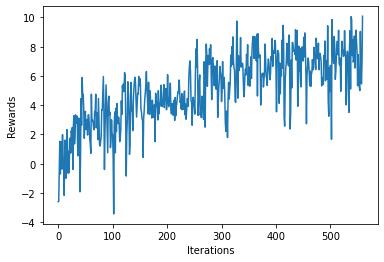

 56%|██████████████████████████████████████████                                 | 56105/100000 [40:20<27:12, 26.89it/s]

Updated Weights
Mean Reward = 4.25
18


 56%|██████████████████████████████████████████▏                                | 56206/100000 [40:23<23:10, 31.50it/s]

Updated Weights
Mean Reward = 9.1
50


 56%|██████████████████████████████████████████▏                                | 56306/100000 [40:26<21:13, 34.31it/s]

Updated Weights
Mean Reward = 7.65
38


 56%|██████████████████████████████████████████▎                                | 56403/100000 [40:29<23:40, 30.70it/s]

Updated Weights
Mean Reward = 7.65
44


 56%|██████████████████████████████████████████▎                                | 56499/100000 [40:32<21:28, 33.76it/s]

Updated Weights
Mean Reward = 9.53
49


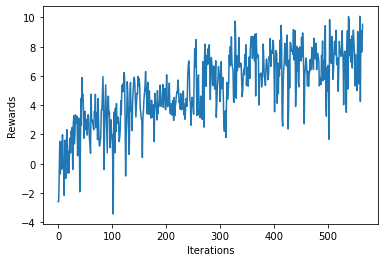

 57%|██████████████████████████████████████████▍                                | 56605/100000 [40:36<25:09, 28.74it/s]

Updated Weights
Mean Reward = 4.53
29


 57%|██████████████████████████████████████████▌                                | 56706/100000 [40:39<29:11, 24.72it/s]

Updated Weights
Mean Reward = 4.39
26


 57%|██████████████████████████████████████████▌                                | 56806/100000 [40:42<23:07, 31.14it/s]

Updated Weights
Mean Reward = 8.87
40


 57%|██████████████████████████████████████████▋                                | 56906/100000 [40:46<19:56, 36.00it/s]

Updated Weights
Mean Reward = 8.87
44


 57%|██████████████████████████████████████████▋                                | 57000/100000 [40:49<23:56, 29.94it/s]

Updated Weights
Mean Reward = 7.1
30


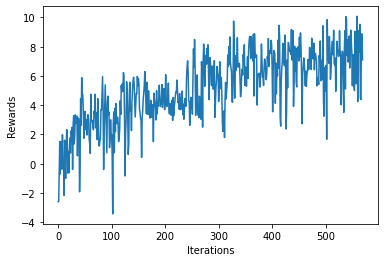

 57%|██████████████████████████████████████████▊                                | 57106/100000 [40:52<22:51, 31.27it/s]

Updated Weights
Mean Reward = 7.92
39


 57%|██████████████████████████████████████████▉                                | 57204/100000 [40:56<28:20, 25.17it/s]

Updated Weights
Mean Reward = 6.37
28


 57%|██████████████████████████████████████████▉                                | 57308/100000 [41:00<21:56, 32.44it/s]

Updated Weights
Mean Reward = 6.06
23


 57%|███████████████████████████████████████████                                | 57406/100000 [41:03<25:02, 28.35it/s]

Updated Weights
Mean Reward = 6.11
31


 57%|███████████████████████████████████████████                                | 57497/100000 [41:06<24:12, 29.26it/s]

Updated Weights
Mean Reward = 6.07
27


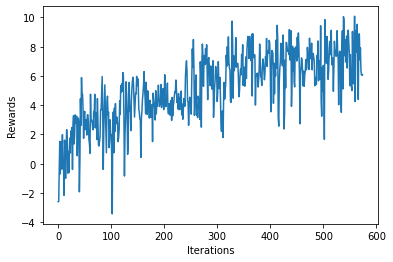

 58%|███████████████████████████████████████████▏                               | 57606/100000 [41:10<25:41, 27.51it/s]

Updated Weights
Mean Reward = 7.95
34


 58%|███████████████████████████████████████████▎                               | 57705/100000 [41:13<23:04, 30.56it/s]

Updated Weights
Mean Reward = 7.89
40


 58%|███████████████████████████████████████████▎                               | 57803/100000 [41:17<28:29, 24.69it/s]

Updated Weights
Mean Reward = 6.0
26


 58%|███████████████████████████████████████████▍                               | 57903/100000 [41:21<37:03, 18.93it/s]

Updated Weights
Mean Reward = 4.52
29


 58%|███████████████████████████████████████████▍                               | 57998/100000 [41:26<33:06, 21.15it/s]

Updated Weights
Mean Reward = 6.43
30


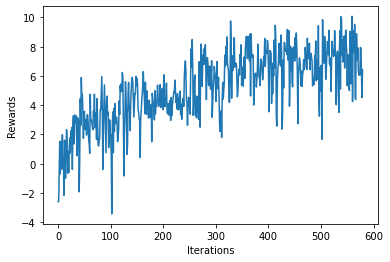

 58%|███████████████████████████████████████████▌                               | 58102/100000 [41:31<33:46, 20.67it/s]

Updated Weights
Mean Reward = 5.99
30


 58%|███████████████████████████████████████████▋                               | 58204/100000 [41:36<34:30, 20.19it/s]

Updated Weights
Mean Reward = 6.53
29


 58%|███████████████████████████████████████████▋                               | 58305/100000 [41:40<26:23, 26.33it/s]

Updated Weights
Mean Reward = 7.07
39


 58%|███████████████████████████████████████████▊                               | 58405/100000 [41:45<33:06, 20.93it/s]

Updated Weights
Mean Reward = 4.54
37


 58%|███████████████████████████████████████████▊                               | 58498/100000 [41:49<38:45, 17.85it/s]

Updated Weights
Mean Reward = 3.43
29


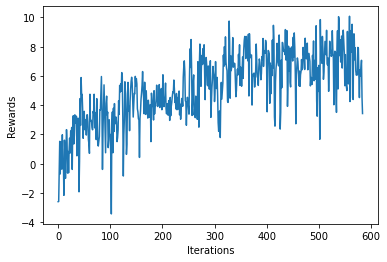

 59%|███████████████████████████████████████████▉                               | 58604/100000 [41:54<33:59, 20.30it/s]

Updated Weights
Mean Reward = 7.54
38


 59%|████████████████████████████████████████████                               | 58703/100000 [41:59<30:05, 22.87it/s]

Updated Weights
Mean Reward = 7.46
35


 59%|████████████████████████████████████████████                               | 58802/100000 [42:04<32:18, 21.25it/s]

Updated Weights
Mean Reward = 7.81
38


 59%|████████████████████████████████████████████▏                              | 58904/100000 [42:08<26:28, 25.87it/s]

Updated Weights
Mean Reward = 8.27
43


 59%|████████████████████████████████████████████▏                              | 58998/100000 [42:12<28:15, 24.18it/s]

Updated Weights
Mean Reward = 8.52
44


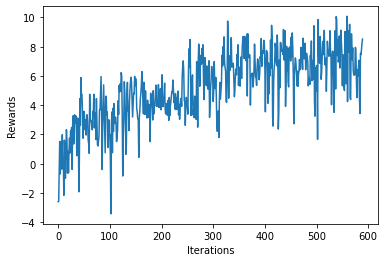

 59%|████████████████████████████████████████████▎                              | 59103/100000 [42:18<33:11, 20.54it/s]

Updated Weights
Mean Reward = 5.99
33


 59%|████████████████████████████████████████████▍                              | 59204/100000 [42:22<30:09, 22.54it/s]

Updated Weights
Mean Reward = 7.48
42


 59%|████████████████████████████████████████████▍                              | 59306/100000 [42:27<28:06, 24.12it/s]

Updated Weights
Mean Reward = 7.49
40


 59%|████████████████████████████████████████████▌                              | 59404/100000 [42:32<35:58, 18.81it/s]

Updated Weights
Mean Reward = 6.42
27


 59%|████████████████████████████████████████████▌                              | 59498/100000 [42:36<27:43, 24.34it/s]

Updated Weights
Mean Reward = 8.31
42


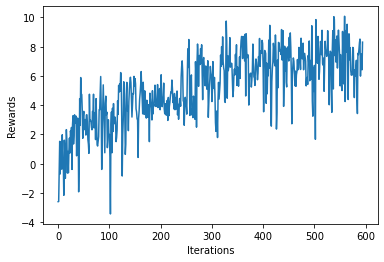

 60%|████████████████████████████████████████████▋                              | 59604/100000 [42:40<28:08, 23.93it/s]

Updated Weights
Mean Reward = 8.34
47


 60%|████████████████████████████████████████████▊                              | 59703/100000 [42:45<27:53, 24.07it/s]

Updated Weights
Mean Reward = 8.39
44


 60%|████████████████████████████████████████████▊                              | 59803/100000 [42:49<24:00, 27.90it/s]

Updated Weights
Mean Reward = 7.66
45


 60%|████████████████████████████████████████████▉                              | 59903/100000 [42:53<23:19, 28.65it/s]

Updated Weights
Mean Reward = 9.15
56


 60%|████████████████████████████████████████████▉                              | 59999/100000 [42:57<31:00, 21.50it/s]

Updated Weights
Mean Reward = 8.69
54


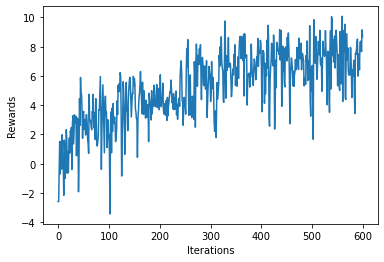

 60%|█████████████████████████████████████████████                              | 60103/100000 [43:01<30:39, 21.69it/s]

Updated Weights
Mean Reward = 8.94
47


 60%|█████████████████████████████████████████████▏                             | 60203/100000 [43:06<35:21, 18.76it/s]

Updated Weights
Mean Reward = 5.55
29


 60%|█████████████████████████████████████████████▏                             | 60304/100000 [43:12<36:03, 18.35it/s]

Updated Weights
Mean Reward = 4.29
25


 60%|█████████████████████████████████████████████▎                             | 60403/100000 [43:16<24:52, 26.53it/s]

Updated Weights
Mean Reward = 9.34
50


 60%|█████████████████████████████████████████████▎                             | 60499/100000 [43:21<39:06, 16.83it/s]

Updated Weights
Mean Reward = 5.86
32


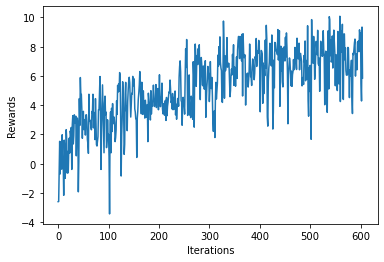

 61%|█████████████████████████████████████████████▍                             | 60604/100000 [43:26<30:56, 21.22it/s]

Updated Weights
Mean Reward = 8.92
44


 61%|█████████████████████████████████████████████▌                             | 60705/100000 [43:30<26:31, 24.70it/s]

Updated Weights
Mean Reward = 8.56
46


 61%|█████████████████████████████████████████████▌                             | 60806/100000 [43:34<27:56, 23.38it/s]

Updated Weights
Mean Reward = 8.9
47


 61%|█████████████████████████████████████████████▋                             | 60904/100000 [43:38<29:37, 22.00it/s]

Updated Weights
Mean Reward = 7.85
40


 61%|█████████████████████████████████████████████▋                             | 60999/100000 [43:43<31:03, 20.92it/s]

Updated Weights
Mean Reward = 6.79
40


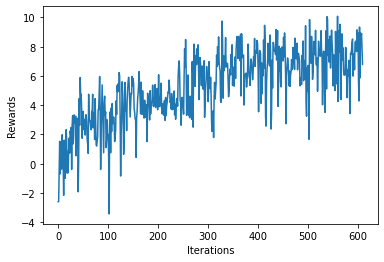

 61%|█████████████████████████████████████████████▊                             | 61107/100000 [43:47<20:35, 31.48it/s]

Updated Weights
Mean Reward = 6.91
45


 61%|█████████████████████████████████████████████▉                             | 61203/100000 [43:51<28:05, 23.02it/s]

Updated Weights
Mean Reward = 10.1
54


 61%|█████████████████████████████████████████████▉                             | 61305/100000 [43:55<24:20, 26.49it/s]

Updated Weights
Mean Reward = 8.85
44


 61%|██████████████████████████████████████████████                             | 61404/100000 [44:00<29:27, 21.84it/s]

Updated Weights
Mean Reward = 7.27
44


 62%|██████████████████████████████████████████████▏                            | 61500/100000 [44:03<23:58, 26.76it/s]

Updated Weights
Mean Reward = 9.88
55


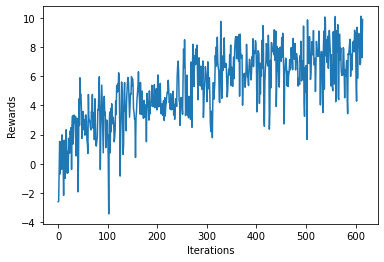

 62%|██████████████████████████████████████████████▏                            | 61605/100000 [44:08<25:36, 24.98it/s]

Updated Weights
Mean Reward = 8.18
44


 62%|██████████████████████████████████████████████▎                            | 61706/100000 [44:12<26:42, 23.90it/s]

Updated Weights
Mean Reward = 8.62
52


 62%|██████████████████████████████████████████████▎                            | 61801/100000 [44:17<31:02, 20.51it/s]

Updated Weights
Mean Reward = 8.18
44


 62%|██████████████████████████████████████████████▍                            | 61903/100000 [44:21<30:56, 20.53it/s]

Updated Weights
Mean Reward = 8.88
47


 62%|██████████████████████████████████████████████▍                            | 61998/100000 [44:25<17:23, 36.40it/s]

Updated Weights
Mean Reward = 8.5
46


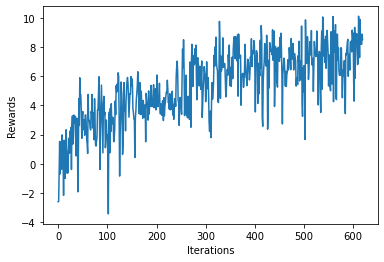

 62%|██████████████████████████████████████████████▌                            | 62103/100000 [44:29<24:34, 25.71it/s]

Updated Weights
Mean Reward = 7.21
40


 62%|██████████████████████████████████████████████▋                            | 62206/100000 [44:32<16:46, 37.57it/s]

Updated Weights
Mean Reward = 7.3
37


 62%|██████████████████████████████████████████████▋                            | 62305/100000 [44:35<19:44, 31.83it/s]

Updated Weights
Mean Reward = 10.22
53


 62%|██████████████████████████████████████████████▊                            | 62404/100000 [44:38<16:43, 37.45it/s]

Updated Weights
Mean Reward = 9.92
52


 62%|██████████████████████████████████████████████▊                            | 62498/100000 [44:41<18:54, 33.07it/s]

Updated Weights
Mean Reward = 8.98
43


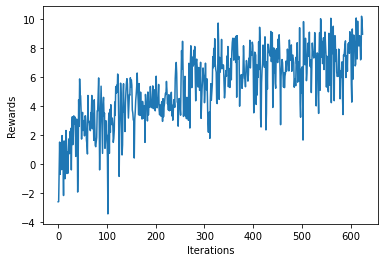

 63%|██████████████████████████████████████████████▉                            | 62608/100000 [44:44<18:58, 32.84it/s]

Updated Weights
Mean Reward = 9.0
51


 63%|███████████████████████████████████████████████                            | 62703/100000 [44:47<21:50, 28.46it/s]

Updated Weights
Mean Reward = 7.72
42


 63%|███████████████████████████████████████████████                            | 62805/100000 [44:50<21:15, 29.17it/s]

Updated Weights
Mean Reward = 6.26
47


 63%|███████████████████████████████████████████████▏                           | 62906/100000 [44:54<24:58, 24.75it/s]

Updated Weights
Mean Reward = 6.75
32


 63%|███████████████████████████████████████████████▏                           | 62999/100000 [44:57<21:24, 28.81it/s]

Updated Weights
Mean Reward = 6.73
31


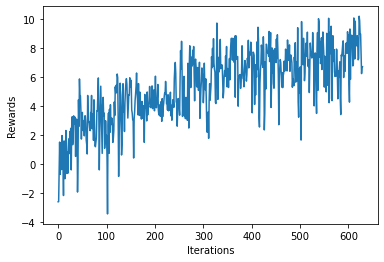

 63%|███████████████████████████████████████████████▎                           | 63105/100000 [45:01<19:00, 32.35it/s]

Updated Weights
Mean Reward = 9.94
52


 63%|███████████████████████████████████████████████▍                           | 63203/100000 [45:04<22:08, 27.71it/s]

Updated Weights
Mean Reward = 7.67
35


 63%|███████████████████████████████████████████████▍                           | 63305/100000 [45:07<16:29, 37.07it/s]

Updated Weights
Mean Reward = 9.85
51


 63%|███████████████████████████████████████████████▌                           | 63405/100000 [45:11<22:34, 27.01it/s]

Updated Weights
Mean Reward = 7.85
46


 63%|███████████████████████████████████████████████▌                           | 63498/100000 [45:14<19:58, 30.47it/s]

Updated Weights
Mean Reward = 9.74
53


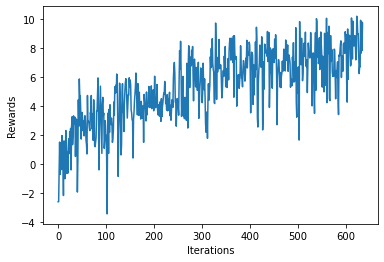

 64%|███████████████████████████████████████████████▋                           | 63603/100000 [45:17<22:02, 27.52it/s]

Updated Weights
Mean Reward = 8.63
51


 64%|███████████████████████████████████████████████▊                           | 63702/100000 [45:21<20:14, 29.88it/s]

Updated Weights
Mean Reward = 9.58
56


 64%|███████████████████████████████████████████████▊                           | 63805/100000 [45:25<25:17, 23.85it/s]

Updated Weights
Mean Reward = 9.91
57


 64%|███████████████████████████████████████████████▉                           | 63904/100000 [45:29<26:41, 22.54it/s]

Updated Weights
Mean Reward = 7.9
49


 64%|███████████████████████████████████████████████▉                           | 63999/100000 [45:33<34:01, 17.63it/s]

Updated Weights
Mean Reward = 8.76
50


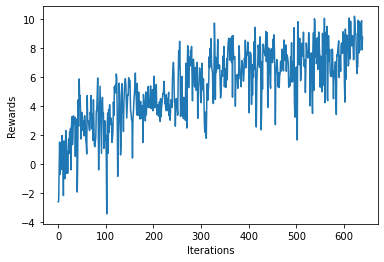

 64%|████████████████████████████████████████████████                           | 64104/100000 [45:38<23:23, 25.58it/s]

Updated Weights
Mean Reward = 8.51
47


 64%|████████████████████████████████████████████████▏                          | 64204/100000 [45:43<26:44, 22.31it/s]

Updated Weights
Mean Reward = 8.13
45


 64%|████████████████████████████████████████████████▏                          | 64303/100000 [45:47<31:04, 19.15it/s]

Updated Weights
Mean Reward = 9.5
51


 64%|████████████████████████████████████████████████▎                          | 64404/100000 [45:52<31:23, 18.90it/s]

Updated Weights
Mean Reward = 3.12
22


 64%|████████████████████████████████████████████████▎                          | 64499/100000 [45:56<26:57, 21.95it/s]

Updated Weights
Mean Reward = 6.79
38


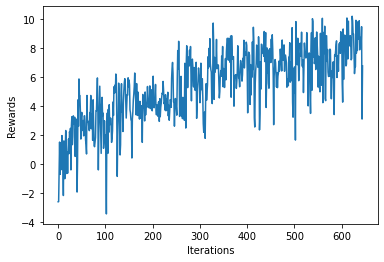

 65%|████████████████████████████████████████████████▍                          | 64603/100000 [46:01<23:02, 25.60it/s]

Updated Weights
Mean Reward = 4.66
30


 65%|████████████████████████████████████████████████▌                          | 64704/100000 [46:06<27:16, 21.57it/s]

Updated Weights
Mean Reward = 2.73
36


 65%|████████████████████████████████████████████████▌                          | 64805/100000 [46:10<23:13, 25.26it/s]

Updated Weights
Mean Reward = 3.36
40


 65%|████████████████████████████████████████████████▋                          | 64903/100000 [46:15<30:17, 19.31it/s]

Updated Weights
Mean Reward = 6.04
38


 65%|████████████████████████████████████████████████▋                          | 64998/100000 [46:19<30:20, 19.23it/s]

Updated Weights
Mean Reward = 7.59
37


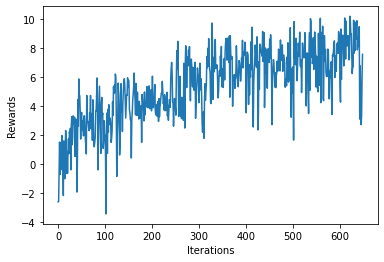

 65%|████████████████████████████████████████████████▊                          | 65104/100000 [46:25<30:17, 19.20it/s]

Updated Weights
Mean Reward = 6.37
28


 65%|████████████████████████████████████████████████▉                          | 65206/100000 [46:30<25:44, 22.53it/s]

Updated Weights
Mean Reward = 4.55
31


 65%|████████████████████████████████████████████████▉                          | 65305/100000 [46:34<26:55, 21.48it/s]

Updated Weights
Mean Reward = 8.08
41


 65%|█████████████████████████████████████████████████                          | 65405/100000 [46:39<26:33, 21.71it/s]

Updated Weights
Mean Reward = 6.72
32


 65%|█████████████████████████████████████████████████                          | 65498/100000 [46:43<26:57, 21.33it/s]

Updated Weights
Mean Reward = 8.11
35


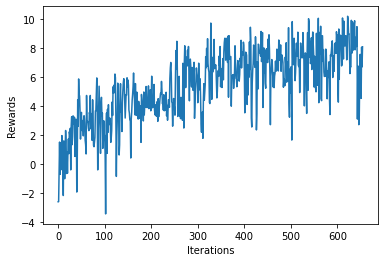

 66%|█████████████████████████████████████████████████▏                         | 65606/100000 [46:49<26:55, 21.30it/s]

Updated Weights
Mean Reward = 6.54
41


 66%|█████████████████████████████████████████████████▎                         | 65705/100000 [46:53<27:00, 21.16it/s]

Updated Weights
Mean Reward = 7.5
36


 66%|█████████████████████████████████████████████████▎                         | 65802/100000 [46:58<31:15, 18.24it/s]

Updated Weights
Mean Reward = 7.35
32


 66%|█████████████████████████████████████████████████▍                         | 65906/100000 [47:03<23:48, 23.86it/s]

Updated Weights
Mean Reward = 6.98
34


 66%|█████████████████████████████████████████████████▍                         | 65998/100000 [47:06<18:10, 31.18it/s]

Updated Weights
Mean Reward = 8.37
40


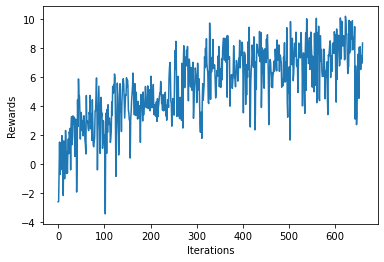

 66%|█████████████████████████████████████████████████▌                         | 66103/100000 [47:10<19:11, 29.45it/s]

Updated Weights
Mean Reward = 5.07
34


 66%|█████████████████████████████████████████████████▋                         | 66205/100000 [47:13<19:18, 29.18it/s]

Updated Weights
Mean Reward = 5.82
24


 66%|█████████████████████████████████████████████████▋                         | 66303/100000 [47:16<19:47, 28.37it/s]

Updated Weights
Mean Reward = 7.17
38


 66%|█████████████████████████████████████████████████▊                         | 66403/100000 [47:20<20:56, 26.73it/s]

Updated Weights
Mean Reward = 7.33
37


 66%|█████████████████████████████████████████████████▊                         | 66498/100000 [47:23<20:15, 27.57it/s]

Updated Weights
Mean Reward = 6.3
30


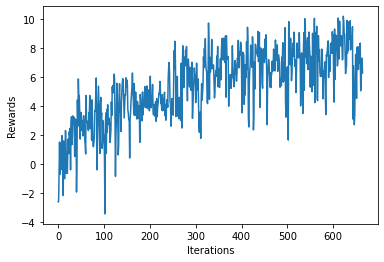

 67%|█████████████████████████████████████████████████▉                         | 66605/100000 [47:27<20:55, 26.61it/s]

Updated Weights
Mean Reward = 6.51
29


 67%|██████████████████████████████████████████████████                         | 66705/100000 [47:31<20:00, 27.74it/s]

Updated Weights
Mean Reward = 5.22
33


 67%|██████████████████████████████████████████████████                         | 66806/100000 [47:34<19:23, 28.54it/s]

Updated Weights
Mean Reward = 5.92
23


 67%|██████████████████████████████████████████████████▏                        | 66904/100000 [47:38<22:12, 24.83it/s]

Updated Weights
Mean Reward = 6.26
26


 67%|██████████████████████████████████████████████████▎                        | 67000/100000 [47:41<20:33, 26.75it/s]

Updated Weights
Mean Reward = 6.23
28


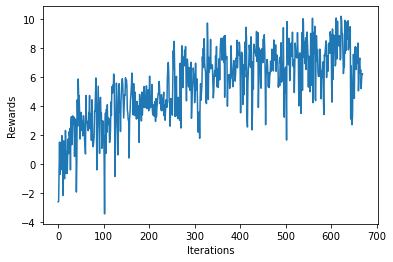

 67%|██████████████████████████████████████████████████▎                        | 67107/100000 [47:45<19:17, 28.42it/s]

Updated Weights
Mean Reward = 5.57
23


 67%|██████████████████████████████████████████████████▍                        | 67206/100000 [47:48<17:30, 31.23it/s]

Updated Weights
Mean Reward = 6.85
29


 67%|██████████████████████████████████████████████████▍                        | 67304/100000 [47:52<18:08, 30.03it/s]

Updated Weights
Mean Reward = 6.17
23


 67%|██████████████████████████████████████████████████▌                        | 67406/100000 [47:56<20:23, 26.65it/s]

Updated Weights
Mean Reward = 7.51
34


 67%|██████████████████████████████████████████████████▌                        | 67496/100000 [47:58<16:56, 31.98it/s]

Updated Weights
Mean Reward = 7.57
37


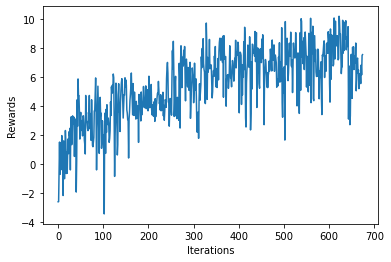

 68%|██████████████████████████████████████████████████▋                        | 67604/100000 [48:02<16:33, 32.62it/s]

Updated Weights
Mean Reward = 6.32
30


 68%|██████████████████████████████████████████████████▊                        | 67705/100000 [48:05<16:15, 33.09it/s]

Updated Weights
Mean Reward = 8.11
38


 68%|██████████████████████████████████████████████████▊                        | 67803/100000 [48:09<18:04, 29.68it/s]

Updated Weights
Mean Reward = 6.57
29


 68%|██████████████████████████████████████████████████▉                        | 67903/100000 [48:12<19:14, 27.80it/s]

Updated Weights
Mean Reward = 5.74
28


 68%|██████████████████████████████████████████████████▉                        | 67999/100000 [48:16<25:25, 20.98it/s]

Updated Weights
Mean Reward = 5.77
19


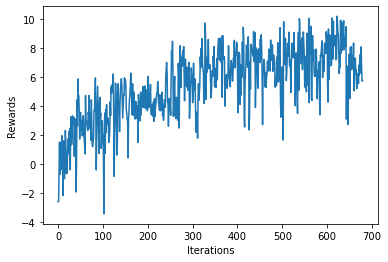

 68%|███████████████████████████████████████████████████                        | 68104/100000 [48:21<19:37, 27.09it/s]

Updated Weights
Mean Reward = 6.7
32


 68%|███████████████████████████████████████████████████▏                       | 68204/100000 [48:24<19:20, 27.40it/s]

Updated Weights
Mean Reward = 7.03
32


 68%|███████████████████████████████████████████████████▏                       | 68304/100000 [48:28<20:46, 25.43it/s]

Updated Weights
Mean Reward = 6.46
29


 68%|███████████████████████████████████████████████████▎                       | 68405/100000 [48:31<17:09, 30.69it/s]

Updated Weights
Mean Reward = 7.03
33


 68%|███████████████████████████████████████████████████▎                       | 68496/100000 [48:34<19:45, 26.58it/s]

Updated Weights
Mean Reward = 6.61
37


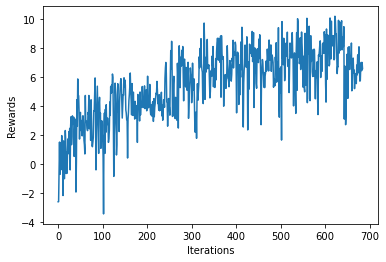

 69%|███████████████████████████████████████████████████▍                       | 68608/100000 [48:38<16:57, 30.86it/s]

Updated Weights
Mean Reward = 6.88
30


 69%|███████████████████████████████████████████████████▌                       | 68704/100000 [48:41<17:25, 29.92it/s]

Updated Weights
Mean Reward = 5.92
27


 69%|███████████████████████████████████████████████████▌                       | 68806/100000 [48:44<15:36, 33.33it/s]

Updated Weights
Mean Reward = 9.35
48


 69%|███████████████████████████████████████████████████▋                       | 68904/100000 [48:47<19:49, 26.14it/s]

Updated Weights
Mean Reward = 4.7
34


 69%|███████████████████████████████████████████████████▋                       | 68997/100000 [48:50<16:06, 32.07it/s]

Updated Weights
Mean Reward = 7.69
41


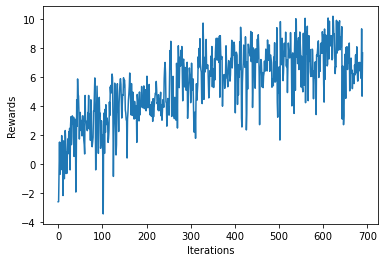

 69%|███████████████████████████████████████████████████▊                       | 69103/100000 [48:54<17:00, 30.29it/s]

Updated Weights
Mean Reward = 8.15
41


 69%|███████████████████████████████████████████████████▉                       | 69206/100000 [48:58<18:19, 28.00it/s]

Updated Weights
Mean Reward = 6.52
31


 69%|███████████████████████████████████████████████████▉                       | 69306/100000 [49:01<19:24, 26.35it/s]

Updated Weights
Mean Reward = 6.17
26


 69%|████████████████████████████████████████████████████                       | 69403/100000 [49:05<15:59, 31.90it/s]

Updated Weights
Mean Reward = 7.37
30


 69%|████████████████████████████████████████████████████                       | 69497/100000 [49:07<16:52, 30.12it/s]

Updated Weights
Mean Reward = 9.47
53


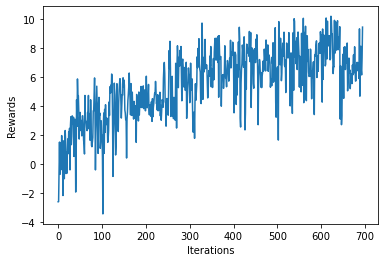

 70%|████████████████████████████████████████████████████▏                      | 69605/100000 [49:11<13:39, 37.11it/s]

Updated Weights
Mean Reward = 8.51
50


 70%|████████████████████████████████████████████████████▎                      | 69706/100000 [49:14<18:38, 27.08it/s]

Updated Weights
Mean Reward = 1.88
28


 70%|████████████████████████████████████████████████████▎                      | 69804/100000 [49:18<20:00, 25.15it/s]

Updated Weights
Mean Reward = 4.16
29


 70%|████████████████████████████████████████████████████▍                      | 69904/100000 [49:22<23:05, 21.73it/s]

Updated Weights
Mean Reward = 5.46
26


 70%|████████████████████████████████████████████████████▍                      | 69999/100000 [49:26<23:07, 21.63it/s]

Updated Weights
Mean Reward = 7.05
34


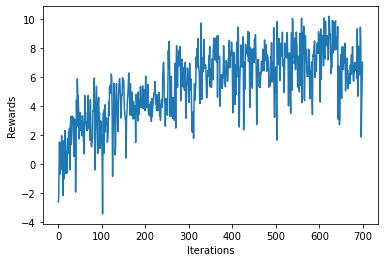

 70%|████████████████████████████████████████████████████▌                      | 70103/100000 [49:31<28:28, 17.50it/s]

Updated Weights
Mean Reward = 9.19
46


 70%|████████████████████████████████████████████████████▋                      | 70203/100000 [49:36<27:39, 17.96it/s]

Updated Weights
Mean Reward = 7.9
37


 70%|████████████████████████████████████████████████████▋                      | 70305/100000 [49:41<20:39, 23.95it/s]

Updated Weights
Mean Reward = 8.17
40


 70%|████████████████████████████████████████████████████▊                      | 70403/100000 [49:46<23:59, 20.56it/s]

Updated Weights
Mean Reward = 6.0
39


 70%|████████████████████████████████████████████████████▊                      | 70498/100000 [49:50<20:31, 23.95it/s]

Updated Weights
Mean Reward = 8.21
45


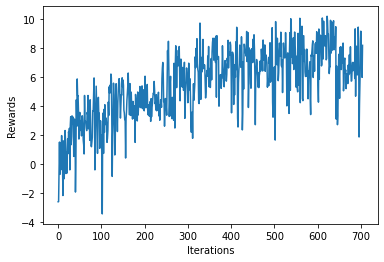

 71%|████████████████████████████████████████████████████▉                      | 70602/100000 [49:55<21:31, 22.76it/s]

Updated Weights
Mean Reward = 8.45
38


 71%|█████████████████████████████████████████████████████                      | 70705/100000 [49:59<21:27, 22.75it/s]

Updated Weights
Mean Reward = 8.72
42


 71%|█████████████████████████████████████████████████████                      | 70802/100000 [50:04<26:08, 18.62it/s]

Updated Weights
Mean Reward = 8.3
41


 71%|█████████████████████████████████████████████████████▏                     | 70903/100000 [50:10<27:05, 17.90it/s]

Updated Weights
Mean Reward = 3.86
30


 71%|█████████████████████████████████████████████████████▏                     | 70998/100000 [50:15<27:50, 17.37it/s]

Updated Weights
Mean Reward = 5.57
29


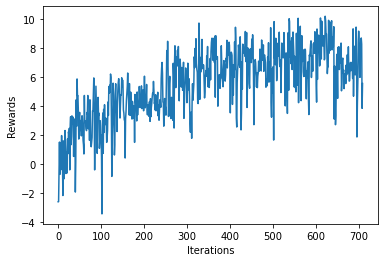

 71%|█████████████████████████████████████████████████████▎                     | 71105/100000 [50:20<22:51, 21.07it/s]

Updated Weights
Mean Reward = 6.85
30


 71%|█████████████████████████████████████████████████████▍                     | 71203/100000 [50:25<23:50, 20.13it/s]

Updated Weights
Mean Reward = 4.28
30


 71%|█████████████████████████████████████████████████████▍                     | 71304/100000 [50:29<18:45, 25.50it/s]

Updated Weights
Mean Reward = 6.44
36


 71%|█████████████████████████████████████████████████████▌                     | 71404/100000 [50:32<23:27, 20.31it/s]

Updated Weights
Mean Reward = 6.35
36


 71%|█████████████████████████████████████████████████████▌                     | 71499/100000 [50:36<17:01, 27.91it/s]

Updated Weights
Mean Reward = 5.4
31


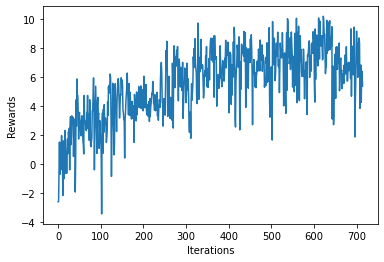

 72%|█████████████████████████████████████████████████████▋                     | 71605/100000 [50:41<17:27, 27.12it/s]

Updated Weights
Mean Reward = 6.7
34


 72%|█████████████████████████████████████████████████████▊                     | 71702/100000 [50:44<15:47, 29.86it/s]

Updated Weights
Mean Reward = 8.35
50


 72%|█████████████████████████████████████████████████████▊                     | 71804/100000 [50:47<20:49, 22.56it/s]

Updated Weights
Mean Reward = 6.96
33


 72%|█████████████████████████████████████████████████████▉                     | 71904/100000 [50:51<15:45, 29.72it/s]

Updated Weights
Mean Reward = 6.31
31


 72%|██████████████████████████████████████████████████████                     | 72000/100000 [50:55<14:32, 32.10it/s]

Updated Weights
Mean Reward = 8.16
40


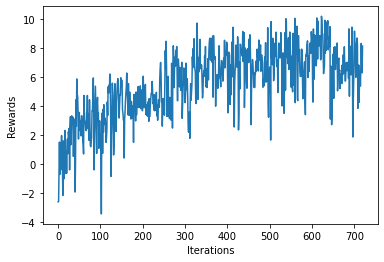

 72%|██████████████████████████████████████████████████████                     | 72102/100000 [50:58<13:21, 34.82it/s]

Updated Weights
Mean Reward = 7.8
36


 72%|██████████████████████████████████████████████████████▏                    | 72203/100000 [51:02<13:37, 33.99it/s]

Updated Weights
Mean Reward = 8.83
43


 72%|██████████████████████████████████████████████████████▏                    | 72305/100000 [51:05<15:19, 30.11it/s]

Updated Weights
Mean Reward = 7.75
38


 72%|██████████████████████████████████████████████████████▎                    | 72408/100000 [51:09<12:49, 35.84it/s]

Updated Weights
Mean Reward = 6.44
37


 72%|██████████████████████████████████████████████████████▎                    | 72497/100000 [51:12<17:23, 26.36it/s]

Updated Weights
Mean Reward = 3.93
28


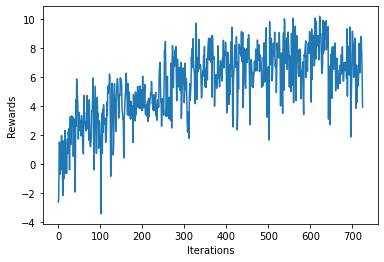

 73%|██████████████████████████████████████████████████████▍                    | 72605/100000 [51:16<15:49, 28.86it/s]

Updated Weights
Mean Reward = 3.82
30


 73%|██████████████████████████████████████████████████████▌                    | 72707/100000 [51:19<11:55, 38.14it/s]

Updated Weights
Mean Reward = 7.47
44


 73%|██████████████████████████████████████████████████████▌                    | 72804/100000 [51:22<14:17, 31.73it/s]

Updated Weights
Mean Reward = 7.18
45


 73%|██████████████████████████████████████████████████████▋                    | 72907/100000 [51:25<12:15, 36.82it/s]

Updated Weights
Mean Reward = 7.41
37


 73%|██████████████████████████████████████████████████████▊                    | 73000/100000 [51:28<15:44, 28.60it/s]

Updated Weights
Mean Reward = 6.58
40


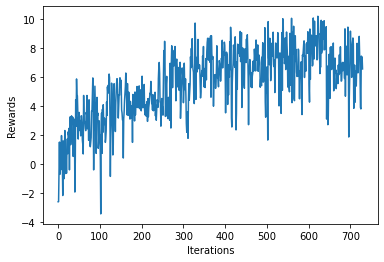

 73%|██████████████████████████████████████████████████████▊                    | 73103/100000 [51:31<11:28, 39.05it/s]

Updated Weights
Mean Reward = 8.39
44


 73%|██████████████████████████████████████████████████████▉                    | 73204/100000 [51:34<12:27, 35.87it/s]

Updated Weights
Mean Reward = 8.48
41


 73%|██████████████████████████████████████████████████████▉                    | 73307/100000 [51:37<12:43, 34.98it/s]

Updated Weights
Mean Reward = 5.38
42


 73%|███████████████████████████████████████████████████████                    | 73404/100000 [51:41<17:30, 25.33it/s]

Updated Weights
Mean Reward = 3.45
14


 73%|███████████████████████████████████████████████████████                    | 73499/100000 [51:45<17:07, 25.80it/s]

Updated Weights
Mean Reward = 2.24
11


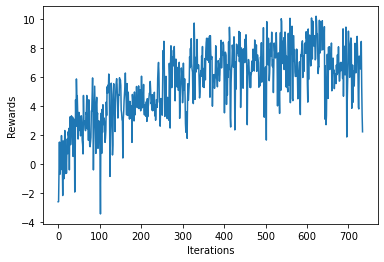

 74%|███████████████████████████████████████████████████████▏                   | 73607/100000 [51:48<12:37, 34.84it/s]

Updated Weights
Mean Reward = 5.63
28


 74%|███████████████████████████████████████████████████████▎                   | 73703/100000 [51:51<14:30, 30.19it/s]

Updated Weights
Mean Reward = 7.02
33


 74%|███████████████████████████████████████████████████████▎                   | 73807/100000 [51:55<13:23, 32.60it/s]

Updated Weights
Mean Reward = 4.76
37


 74%|███████████████████████████████████████████████████████▍                   | 73905/100000 [51:58<16:08, 26.96it/s]

Updated Weights
Mean Reward = 4.81
30


 74%|███████████████████████████████████████████████████████▍                   | 73997/100000 [52:01<13:35, 31.87it/s]

Updated Weights
Mean Reward = 5.33
43


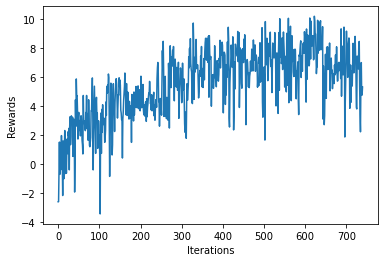

 74%|███████████████████████████████████████████████████████▌                   | 74103/100000 [52:04<12:05, 35.71it/s]

Updated Weights
Mean Reward = 8.32
45


 74%|███████████████████████████████████████████████████████▋                   | 74205/100000 [52:07<12:56, 33.21it/s]

Updated Weights
Mean Reward = 8.37
44


 74%|███████████████████████████████████████████████████████▋                   | 74305/100000 [52:11<17:21, 24.67it/s]

Updated Weights
Mean Reward = 8.11
43


 74%|███████████████████████████████████████████████████████▊                   | 74404/100000 [52:15<14:36, 29.19it/s]

Updated Weights
Mean Reward = 7.79
38


 74%|███████████████████████████████████████████████████████▊                   | 74494/100000 [52:18<14:01, 30.31it/s]

Updated Weights
Mean Reward = 7.37
31


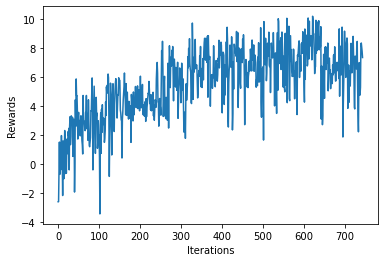

 75%|███████████████████████████████████████████████████████▉                   | 74605/100000 [52:23<17:00, 24.89it/s]

Updated Weights
Mean Reward = 11.03
57


 75%|████████████████████████████████████████████████████████                   | 74704/100000 [52:28<21:35, 19.53it/s]

Updated Weights
Mean Reward = 11.63
63


 75%|████████████████████████████████████████████████████████                   | 74807/100000 [52:32<16:23, 25.62it/s]

Updated Weights
Mean Reward = 8.66
44


 75%|████████████████████████████████████████████████████████▏                  | 74906/100000 [52:37<18:10, 23.02it/s]

Updated Weights
Mean Reward = 7.07
37


 75%|████████████████████████████████████████████████████████▎                  | 75000/100000 [52:41<21:05, 19.76it/s]

Updated Weights
Mean Reward = 7.63
39


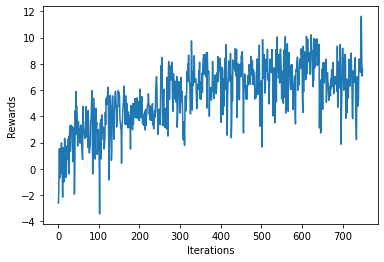

 75%|████████████████████████████████████████████████████████▎                  | 75104/100000 [52:46<18:43, 22.17it/s]

Updated Weights
Mean Reward = 7.66
38


 75%|████████████████████████████████████████████████████████▍                  | 75203/100000 [52:51<20:16, 20.38it/s]

Updated Weights
Mean Reward = 9.22
45


 75%|████████████████████████████████████████████████████████▍                  | 75304/100000 [52:55<17:51, 23.04it/s]

Updated Weights
Mean Reward = 8.17
42


 75%|████████████████████████████████████████████████████████▌                  | 75403/100000 [52:59<14:35, 28.10it/s]

Updated Weights
Mean Reward = 9.12
49


 76%|████████████████████████████████████████████████████████▋                  | 75500/100000 [53:03<18:53, 21.62it/s]

Updated Weights
Mean Reward = 5.84
49


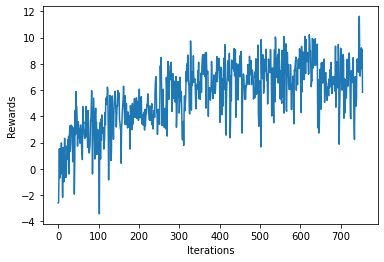

 76%|████████████████████████████████████████████████████████▋                  | 75603/100000 [53:08<18:14, 22.30it/s]

Updated Weights
Mean Reward = 6.32
27


 76%|████████████████████████████████████████████████████████▊                  | 75708/100000 [53:12<10:38, 38.03it/s]

Updated Weights
Mean Reward = 8.64
38


 76%|████████████████████████████████████████████████████████▊                  | 75807/100000 [53:15<12:30, 32.23it/s]

Updated Weights
Mean Reward = 9.41
51


 76%|████████████████████████████████████████████████████████▉                  | 75907/100000 [53:18<12:49, 31.29it/s]

Updated Weights
Mean Reward = 9.03
49


 76%|████████████████████████████████████████████████████████▉                  | 75997/100000 [53:21<15:20, 26.07it/s]

Updated Weights
Mean Reward = 8.14
40


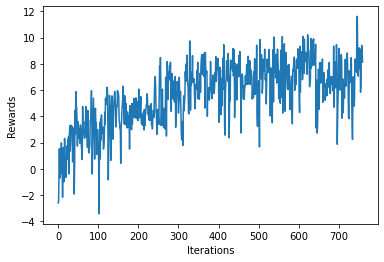

 76%|█████████████████████████████████████████████████████████                  | 76107/100000 [53:24<12:24, 32.07it/s]

Updated Weights
Mean Reward = 8.45
47


 76%|█████████████████████████████████████████████████████████▏                 | 76206/100000 [53:27<11:39, 34.00it/s]

Updated Weights
Mean Reward = 9.19
54


 76%|█████████████████████████████████████████████████████████▏                 | 76304/100000 [53:30<12:55, 30.56it/s]

Updated Weights
Mean Reward = 10.77
59


 76%|█████████████████████████████████████████████████████████▎                 | 76404/100000 [53:34<13:58, 28.13it/s]

Updated Weights
Mean Reward = 8.19
45


 76%|█████████████████████████████████████████████████████████▎                 | 76499/100000 [53:38<13:10, 29.72it/s]

Updated Weights
Mean Reward = 7.82
43


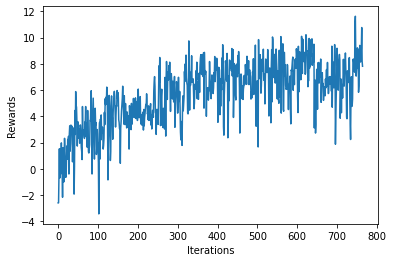

 77%|█████████████████████████████████████████████████████████▍                 | 76605/100000 [53:41<13:20, 29.22it/s]

Updated Weights
Mean Reward = 9.52
56


 77%|█████████████████████████████████████████████████████████▌                 | 76704/100000 [53:44<12:13, 31.75it/s]

Updated Weights
Mean Reward = 9.23
55


 77%|█████████████████████████████████████████████████████████▌                 | 76807/100000 [53:47<10:12, 37.87it/s]

Updated Weights
Mean Reward = 6.72
37


 77%|█████████████████████████████████████████████████████████▋                 | 76902/100000 [53:50<11:17, 34.11it/s]

Updated Weights
Mean Reward = 8.42
48


 77%|█████████████████████████████████████████████████████████▋                 | 76998/100000 [53:54<12:39, 30.28it/s]

Updated Weights
Mean Reward = 7.01
43


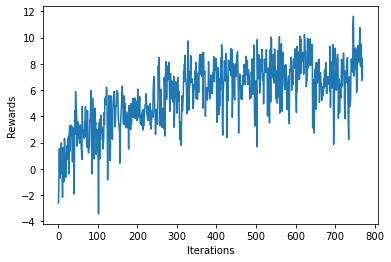

 77%|█████████████████████████████████████████████████████████▊                 | 77104/100000 [53:57<13:53, 27.49it/s]

Updated Weights
Mean Reward = 6.71
42


 77%|█████████████████████████████████████████████████████████▉                 | 77205/100000 [54:01<12:44, 29.82it/s]

Updated Weights
Mean Reward = 6.41
30


 77%|█████████████████████████████████████████████████████████▉                 | 77304/100000 [54:04<11:32, 32.79it/s]

Updated Weights
Mean Reward = 10.1
52


 77%|██████████████████████████████████████████████████████████                 | 77408/100000 [54:07<10:23, 36.22it/s]

Updated Weights
Mean Reward = 9.28
48


 77%|██████████████████████████████████████████████████████████                 | 77499/100000 [54:10<09:24, 39.86it/s]

Updated Weights
Mean Reward = 10.04
57


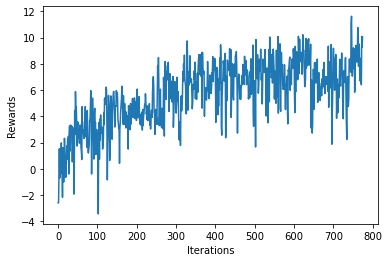

 78%|██████████████████████████████████████████████████████████▏                | 77605/100000 [54:13<12:22, 30.15it/s]

Updated Weights
Mean Reward = 9.67
56


 78%|██████████████████████████████████████████████████████████▎                | 77706/100000 [54:16<13:22, 27.78it/s]

Updated Weights
Mean Reward = 7.83
50


 78%|██████████████████████████████████████████████████████████▎                | 77804/100000 [54:19<11:43, 31.57it/s]

Updated Weights
Mean Reward = 9.98
52


 78%|██████████████████████████████████████████████████████████▍                | 77908/100000 [54:23<10:01, 36.74it/s]

Updated Weights
Mean Reward = 7.33
48


 78%|██████████████████████████████████████████████████████████▍                | 77999/100000 [54:27<14:43, 24.91it/s]

Updated Weights
Mean Reward = 9.12
45


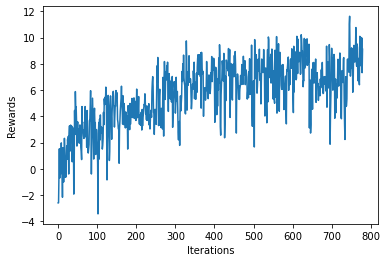

 78%|██████████████████████████████████████████████████████████▌                | 78104/100000 [54:31<13:20, 27.34it/s]

Updated Weights
Mean Reward = 9.66
49


 78%|██████████████████████████████████████████████████████████▋                | 78205/100000 [54:35<15:50, 22.93it/s]

Updated Weights
Mean Reward = 10.06
57


 78%|██████████████████████████████████████████████████████████▋                | 78303/100000 [54:39<18:45, 19.28it/s]

Updated Weights
Mean Reward = 5.79
37


 78%|██████████████████████████████████████████████████████████▊                | 78404/100000 [54:44<16:32, 21.77it/s]

Updated Weights
Mean Reward = 4.54
36


 78%|██████████████████████████████████████████████████████████▊                | 78499/100000 [54:49<17:23, 20.61it/s]

Updated Weights
Mean Reward = -3.0
22


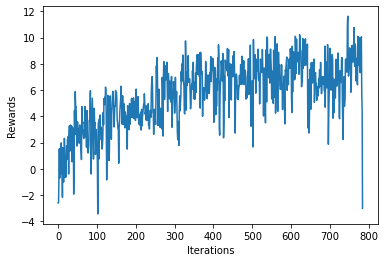

 79%|██████████████████████████████████████████████████████████▉                | 78605/100000 [54:54<18:01, 19.79it/s]

Updated Weights
Mean Reward = 7.45
33


 79%|███████████████████████████████████████████████████████████                | 78703/100000 [54:59<12:49, 27.66it/s]

Updated Weights
Mean Reward = 6.99
32


 79%|███████████████████████████████████████████████████████████                | 78805/100000 [55:04<17:26, 20.26it/s]

Updated Weights
Mean Reward = 7.65
35


 79%|███████████████████████████████████████████████████████████▏               | 78904/100000 [55:08<15:31, 22.64it/s]

Updated Weights
Mean Reward = 8.77
42


 79%|███████████████████████████████████████████████████████████▏               | 78999/100000 [55:12<14:59, 23.34it/s]

Updated Weights
Mean Reward = 9.14
49


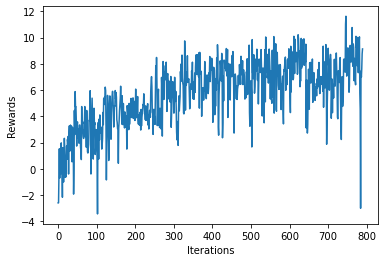

 79%|███████████████████████████████████████████████████████████▎               | 79106/100000 [55:16<12:22, 28.13it/s]

Updated Weights
Mean Reward = 10.48
62


 79%|███████████████████████████████████████████████████████████▍               | 79204/100000 [55:20<14:29, 23.92it/s]

Updated Weights
Mean Reward = 8.21
47


 79%|███████████████████████████████████████████████████████████▍               | 79304/100000 [55:24<12:47, 26.95it/s]

Updated Weights
Mean Reward = 9.46
52


 79%|███████████████████████████████████████████████████████████▌               | 79402/100000 [55:29<11:45, 29.19it/s]

Updated Weights
Mean Reward = 9.5
47


 80%|███████████████████████████████████████████████████████████▋               | 79500/100000 [55:32<09:20, 36.58it/s]

Updated Weights
Mean Reward = 9.95
56


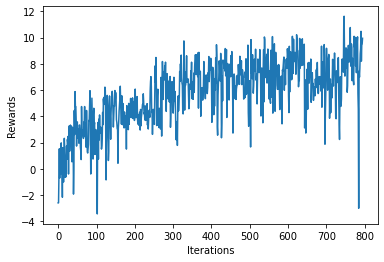

 80%|███████████████████████████████████████████████████████████▋               | 79603/100000 [55:37<19:02, 17.85it/s]

Updated Weights
Mean Reward = 6.24
35


 80%|███████████████████████████████████████████████████████████▊               | 79703/100000 [55:43<19:46, 17.11it/s]

Updated Weights
Mean Reward = 3.23
15


 80%|███████████████████████████████████████████████████████████▊               | 79805/100000 [55:48<17:49, 18.88it/s]

Updated Weights
Mean Reward = 5.48
21


 80%|███████████████████████████████████████████████████████████▉               | 79905/100000 [55:53<12:05, 27.69it/s]

Updated Weights
Mean Reward = 8.42
40


 80%|███████████████████████████████████████████████████████████▉               | 79999/100000 [55:57<14:24, 23.13it/s]

Updated Weights
Mean Reward = 10.04
49


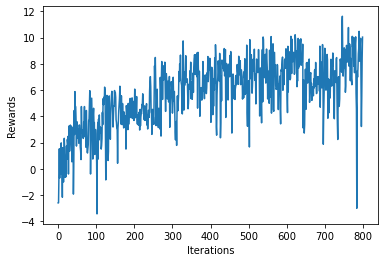

 80%|████████████████████████████████████████████████████████████               | 80105/100000 [56:01<08:40, 38.24it/s]

Updated Weights
Mean Reward = 10.32
50


 80%|████████████████████████████████████████████████████████████▏              | 80203/100000 [56:03<10:49, 30.49it/s]

Updated Weights
Mean Reward = 11.68
66


 80%|████████████████████████████████████████████████████████████▏              | 80306/100000 [56:07<10:39, 30.82it/s]

Updated Weights
Mean Reward = 7.1
35


 80%|████████████████████████████████████████████████████████████▎              | 80406/100000 [56:10<10:02, 32.51it/s]

Updated Weights
Mean Reward = 8.83
47


 80%|████████████████████████████████████████████████████████████▎              | 80498/100000 [56:13<10:41, 30.39it/s]

Updated Weights
Mean Reward = 7.57
42


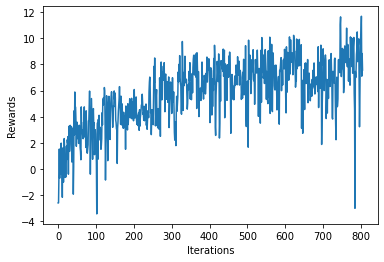

 81%|████████████████████████████████████████████████████████████▍              | 80605/100000 [56:16<09:03, 35.71it/s]

Updated Weights
Mean Reward = 8.75
51


 81%|████████████████████████████████████████████████████████████▌              | 80703/100000 [56:19<10:21, 31.07it/s]

Updated Weights
Mean Reward = 7.73
38


 81%|████████████████████████████████████████████████████████████▌              | 80803/100000 [56:23<11:34, 27.65it/s]

Updated Weights
Mean Reward = 9.04
49


 81%|████████████████████████████████████████████████████████████▋              | 80903/100000 [56:26<13:01, 24.43it/s]

Updated Weights
Mean Reward = 9.22
49


 81%|████████████████████████████████████████████████████████████▋              | 80998/100000 [56:29<11:36, 27.30it/s]

Updated Weights
Mean Reward = 6.15
28


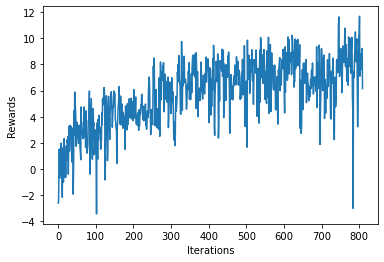

 81%|████████████████████████████████████████████████████████████▊              | 81105/100000 [56:33<09:15, 34.03it/s]

Updated Weights
Mean Reward = 9.01
44


 81%|████████████████████████████████████████████████████████████▉              | 81209/100000 [56:36<07:05, 44.18it/s]

Updated Weights
Mean Reward = 9.62
55


 81%|████████████████████████████████████████████████████████████▉              | 81310/100000 [56:39<08:23, 37.11it/s]

Updated Weights
Mean Reward = 8.42
44


 81%|█████████████████████████████████████████████████████████████              | 81408/100000 [56:41<07:11, 43.08it/s]

Updated Weights
Mean Reward = 9.87
55


 81%|█████████████████████████████████████████████████████████████              | 81497/100000 [56:44<08:44, 35.26it/s]

Updated Weights
Mean Reward = 9.45
51


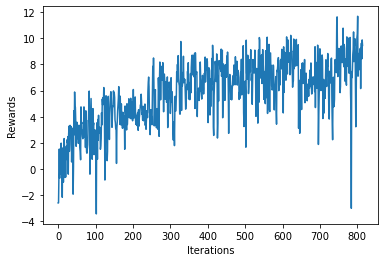

 82%|█████████████████████████████████████████████████████████████▏             | 81603/100000 [56:47<08:10, 37.50it/s]

Updated Weights
Mean Reward = 8.81
48


 82%|█████████████████████████████████████████████████████████████▎             | 81707/100000 [56:50<07:40, 39.72it/s]

Updated Weights
Mean Reward = 9.8
59


 82%|█████████████████████████████████████████████████████████████▎             | 81806/100000 [56:53<11:12, 27.05it/s]

Updated Weights
Mean Reward = 7.89
39


 82%|█████████████████████████████████████████████████████████████▍             | 81909/100000 [56:56<07:31, 40.09it/s]

Updated Weights
Mean Reward = 9.14
49


 82%|█████████████████████████████████████████████████████████████▍             | 82000/100000 [56:58<07:00, 42.80it/s]

Updated Weights
Mean Reward = 9.86
56


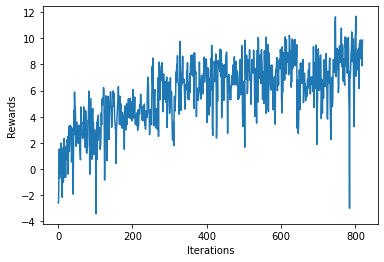

 82%|█████████████████████████████████████████████████████████████▌             | 82105/100000 [57:01<10:00, 29.81it/s]

Updated Weights
Mean Reward = 7.68
43


 82%|█████████████████████████████████████████████████████████████▋             | 82206/100000 [57:04<09:25, 31.46it/s]

Updated Weights
Mean Reward = 8.41
47


 82%|█████████████████████████████████████████████████████████████▋             | 82306/100000 [57:07<09:50, 29.95it/s]

Updated Weights
Mean Reward = 9.45
48


 82%|█████████████████████████████████████████████████████████████▊             | 82407/100000 [57:10<08:43, 33.59it/s]

Updated Weights
Mean Reward = 8.8
41


 82%|█████████████████████████████████████████████████████████████▊             | 82498/100000 [57:13<08:29, 34.36it/s]

Updated Weights
Mean Reward = 8.11
44


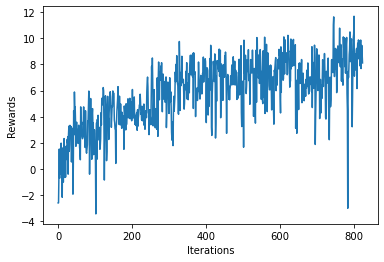

 83%|█████████████████████████████████████████████████████████████▉             | 82607/100000 [57:16<07:21, 39.39it/s]

Updated Weights
Mean Reward = 10.33
57


 83%|██████████████████████████████████████████████████████████████             | 82708/100000 [57:19<07:43, 37.34it/s]

Updated Weights
Mean Reward = 9.29
48


 83%|██████████████████████████████████████████████████████████████             | 82803/100000 [57:22<11:05, 25.86it/s]

Updated Weights
Mean Reward = 9.66
52


 83%|██████████████████████████████████████████████████████████████▏            | 82902/100000 [57:26<11:44, 24.29it/s]

Updated Weights
Mean Reward = 8.74
54


 83%|██████████████████████████████████████████████████████████████▎            | 83000/100000 [57:30<09:45, 29.06it/s]

Updated Weights
Mean Reward = 9.97
56


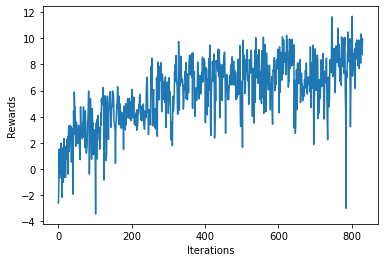

 83%|██████████████████████████████████████████████████████████████▎            | 83103/100000 [57:35<15:40, 17.97it/s]

Updated Weights
Mean Reward = 5.95
29


 83%|██████████████████████████████████████████████████████████████▍            | 83203/100000 [57:40<14:55, 18.76it/s]

Updated Weights
Mean Reward = 7.81
38


 83%|██████████████████████████████████████████████████████████████▍            | 83304/100000 [57:44<11:29, 24.23it/s]

Updated Weights
Mean Reward = 9.51
49


 83%|██████████████████████████████████████████████████████████████▌            | 83403/100000 [57:48<10:48, 25.58it/s]

Updated Weights
Mean Reward = 10.5
57


 83%|██████████████████████████████████████████████████████████████▌            | 83498/100000 [57:52<10:03, 27.32it/s]

Updated Weights
Mean Reward = 10.37
58


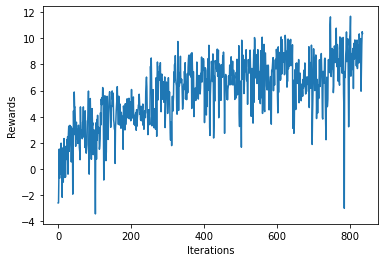

 84%|██████████████████████████████████████████████████████████████▋            | 83605/100000 [57:56<09:05, 30.04it/s]

Updated Weights
Mean Reward = 10.01
56


 84%|██████████████████████████████████████████████████████████████▊            | 83703/100000 [58:01<12:43, 21.34it/s]

Updated Weights
Mean Reward = 9.01
43


 84%|██████████████████████████████████████████████████████████████▊            | 83802/100000 [58:05<10:23, 25.98it/s]

Updated Weights
Mean Reward = 9.27
50


 84%|██████████████████████████████████████████████████████████████▉            | 83905/100000 [58:09<10:36, 25.29it/s]

Updated Weights
Mean Reward = 9.75
52


 84%|██████████████████████████████████████████████████████████████▉            | 83999/100000 [58:13<11:21, 23.48it/s]

Updated Weights
Mean Reward = 10.53
57


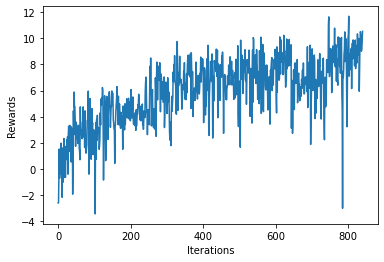

 84%|███████████████████████████████████████████████████████████████            | 84106/100000 [58:17<08:55, 29.69it/s]

Updated Weights
Mean Reward = 8.23
48


 84%|███████████████████████████████████████████████████████████████▏           | 84205/100000 [58:20<08:09, 32.26it/s]

Updated Weights
Mean Reward = 8.91
55


 84%|███████████████████████████████████████████████████████████████▏           | 84305/100000 [58:22<07:30, 34.82it/s]

Updated Weights
Mean Reward = 10.66
57


 84%|███████████████████████████████████████████████████████████████▎           | 84405/100000 [58:25<07:22, 35.25it/s]

Updated Weights
Mean Reward = 10.46
58


 84%|███████████████████████████████████████████████████████████████▎           | 84496/100000 [58:28<06:49, 37.83it/s]

Updated Weights
Mean Reward = 9.58
53


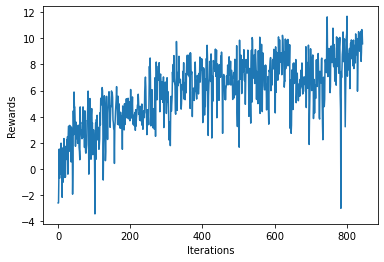

 85%|███████████████████████████████████████████████████████████████▍           | 84609/100000 [58:32<07:32, 34.03it/s]

Updated Weights
Mean Reward = 9.19
49


 85%|███████████████████████████████████████████████████████████████▌           | 84703/100000 [58:34<05:40, 44.86it/s]

Updated Weights
Mean Reward = 10.81
61


 85%|███████████████████████████████████████████████████████████████▌           | 84802/100000 [58:37<07:29, 33.78it/s]

Updated Weights
Mean Reward = 10.66
59


 85%|███████████████████████████████████████████████████████████████▋           | 84905/100000 [58:40<07:40, 32.78it/s]

Updated Weights
Mean Reward = 8.55
46


 85%|███████████████████████████████████████████████████████████████▋           | 84998/100000 [58:43<09:30, 26.29it/s]

Updated Weights
Mean Reward = 7.19
28


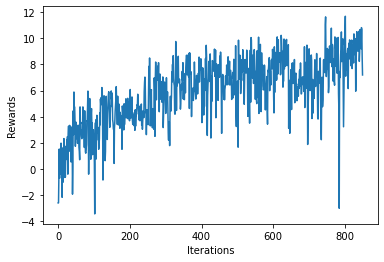

 85%|███████████████████████████████████████████████████████████████▊           | 85103/100000 [58:46<08:32, 29.04it/s]

Updated Weights
Mean Reward = 9.17
51


 85%|███████████████████████████████████████████████████████████████▉           | 85204/100000 [58:49<08:34, 28.76it/s]

Updated Weights
Mean Reward = 9.88
59


 85%|███████████████████████████████████████████████████████████████▉           | 85305/100000 [58:52<09:05, 26.96it/s]

Updated Weights
Mean Reward = 8.28
45


 85%|████████████████████████████████████████████████████████████████           | 85405/100000 [58:55<07:59, 30.42it/s]

Updated Weights
Mean Reward = 6.96
39


 85%|████████████████████████████████████████████████████████████████           | 85499/100000 [58:58<07:27, 32.38it/s]

Updated Weights
Mean Reward = 10.79
56


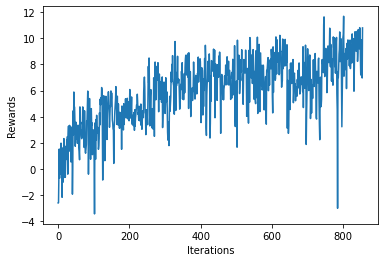

 86%|████████████████████████████████████████████████████████████████▏          | 85604/100000 [59:01<06:13, 38.54it/s]

Updated Weights
Mean Reward = 11.06
62


 86%|████████████████████████████████████████████████████████████████▎          | 85704/100000 [59:03<07:21, 32.36it/s]

Updated Weights
Mean Reward = 11.32
62


 86%|████████████████████████████████████████████████████████████████▎          | 85810/100000 [59:07<06:11, 38.16it/s]

Updated Weights
Mean Reward = 9.26
49


 86%|████████████████████████████████████████████████████████████████▍          | 85906/100000 [59:10<08:42, 26.98it/s]

Updated Weights
Mean Reward = 9.63
55


 86%|████████████████████████████████████████████████████████████████▍          | 85997/100000 [59:12<08:37, 27.05it/s]

Updated Weights
Mean Reward = 9.64
56


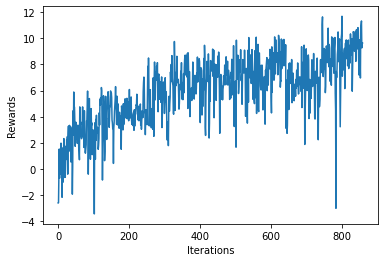

 86%|████████████████████████████████████████████████████████████████▌          | 86105/100000 [59:16<08:26, 27.46it/s]

Updated Weights
Mean Reward = 9.08
52


 86%|████████████████████████████████████████████████████████████████▋          | 86205/100000 [59:19<07:00, 32.84it/s]

Updated Weights
Mean Reward = 6.3
37


 86%|████████████████████████████████████████████████████████████████▋          | 86302/100000 [59:22<10:09, 22.46it/s]

Updated Weights
Mean Reward = 8.33
47


 86%|████████████████████████████████████████████████████████████████▊          | 86402/100000 [59:28<13:25, 16.87it/s]

Updated Weights
Mean Reward = 1.93
20


 86%|████████████████████████████████████████████████████████████████▉          | 86500/100000 [59:32<10:36, 21.20it/s]

Updated Weights
Mean Reward = 5.38
34


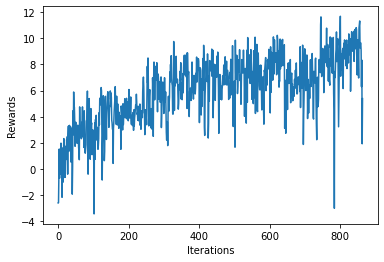

 87%|████████████████████████████████████████████████████████████████▉          | 86602/100000 [59:37<10:05, 22.12it/s]

Updated Weights
Mean Reward = 8.51
44


 87%|█████████████████████████████████████████████████████████████████          | 86704/100000 [59:41<09:46, 22.68it/s]

Updated Weights
Mean Reward = 8.89
48


 87%|█████████████████████████████████████████████████████████████████          | 86803/100000 [59:46<09:48, 22.44it/s]

Updated Weights
Mean Reward = 6.83
33


 87%|█████████████████████████████████████████████████████████████████▏         | 86904/100000 [59:51<09:16, 23.52it/s]

Updated Weights
Mean Reward = 6.42
38


 87%|█████████████████████████████████████████████████████████████████▏         | 86999/100000 [59:55<09:32, 22.71it/s]

Updated Weights
Mean Reward = 8.7
48


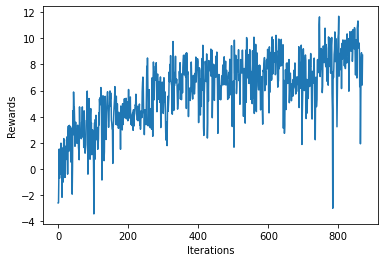

 87%|█████████████████████████████████████████████████████████████████▎         | 87103/100000 [59:59<05:26, 39.52it/s]

Updated Weights
Mean Reward = 10.58
59


 87%|███████████████████████████████████████████████████████████████▋         | 87203/100000 [1:00:03<09:37, 22.15it/s]

Updated Weights
Mean Reward = 6.62
44


 87%|███████████████████████████████████████████████████████████████▋         | 87304/100000 [1:00:07<08:14, 25.69it/s]

Updated Weights
Mean Reward = 7.53
33


 87%|███████████████████████████████████████████████████████████████▊         | 87402/100000 [1:00:10<07:02, 29.79it/s]

Updated Weights
Mean Reward = 6.48
45


 87%|███████████████████████████████████████████████████████████████▊         | 87498/100000 [1:00:13<07:43, 26.99it/s]

Updated Weights
Mean Reward = 8.09
38


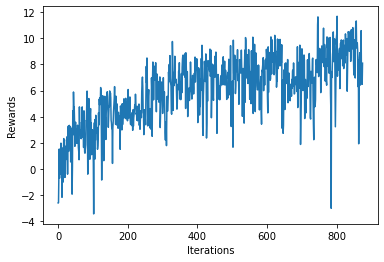

 88%|███████████████████████████████████████████████████████████████▉         | 87605/100000 [1:00:17<07:15, 28.49it/s]

Updated Weights
Mean Reward = 5.94
20


 88%|████████████████████████████████████████████████████████████████         | 87703/100000 [1:00:20<06:25, 31.91it/s]

Updated Weights
Mean Reward = 9.4
44


 88%|████████████████████████████████████████████████████████████████         | 87805/100000 [1:00:23<06:15, 32.50it/s]

Updated Weights
Mean Reward = 7.99
40


 88%|████████████████████████████████████████████████████████████████▏        | 87904/100000 [1:00:27<06:31, 30.91it/s]

Updated Weights
Mean Reward = 7.18
32


 88%|████████████████████████████████████████████████████████████████▏        | 88000/100000 [1:00:29<04:28, 44.71it/s]

Updated Weights
Mean Reward = 11.11
62


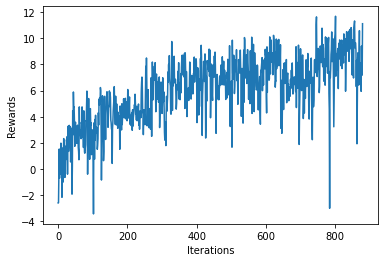

 88%|████████████████████████████████████████████████████████████████▎        | 88107/100000 [1:00:33<06:13, 31.84it/s]

Updated Weights
Mean Reward = 9.21
45


 88%|████████████████████████████████████████████████████████████████▍        | 88207/100000 [1:00:37<06:34, 29.93it/s]

Updated Weights
Mean Reward = 8.8
47


 88%|████████████████████████████████████████████████████████████████▍        | 88305/100000 [1:00:40<07:00, 27.80it/s]

Updated Weights
Mean Reward = 9.65
49


 88%|████████████████████████████████████████████████████████████████▌        | 88404/100000 [1:00:43<06:14, 30.92it/s]

Updated Weights
Mean Reward = 9.77
53


 88%|████████████████████████████████████████████████████████████████▌        | 88497/100000 [1:00:46<07:37, 25.17it/s]

Updated Weights
Mean Reward = 9.53
51


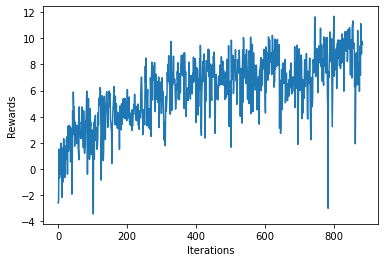

 89%|████████████████████████████████████████████████████████████████▋        | 88607/100000 [1:00:49<04:37, 41.03it/s]

Updated Weights
Mean Reward = 10.12
54


 89%|████████████████████████████████████████████████████████████████▊        | 88706/100000 [1:00:53<05:30, 34.13it/s]

Updated Weights
Mean Reward = 8.22
44


 89%|████████████████████████████████████████████████████████████████▊        | 88803/100000 [1:00:55<05:03, 36.95it/s]

Updated Weights
Mean Reward = 10.52
56


 89%|████████████████████████████████████████████████████████████████▉        | 88904/100000 [1:00:58<05:22, 34.46it/s]

Updated Weights
Mean Reward = 10.06
56


 89%|████████████████████████████████████████████████████████████████▉        | 88998/100000 [1:01:01<05:45, 31.82it/s]

Updated Weights
Mean Reward = 10.62
60


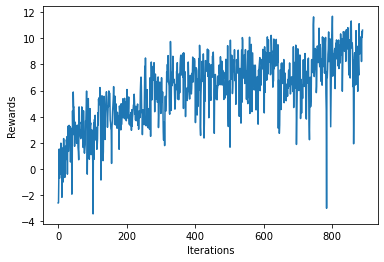

 89%|█████████████████████████████████████████████████████████████████        | 89107/100000 [1:01:04<04:23, 41.30it/s]

Updated Weights
Mean Reward = 9.28
52


 89%|█████████████████████████████████████████████████████████████████        | 89205/100000 [1:01:07<05:27, 32.94it/s]

Updated Weights
Mean Reward = 8.82
48


 89%|█████████████████████████████████████████████████████████████████▏       | 89305/100000 [1:01:10<06:00, 29.66it/s]

Updated Weights
Mean Reward = 5.59
35


 89%|█████████████████████████████████████████████████████████████████▎       | 89404/100000 [1:01:13<06:23, 27.61it/s]

Updated Weights
Mean Reward = 5.78
38


 89%|█████████████████████████████████████████████████████████████████▎       | 89499/100000 [1:01:16<05:02, 34.69it/s]

Updated Weights
Mean Reward = 7.99
46


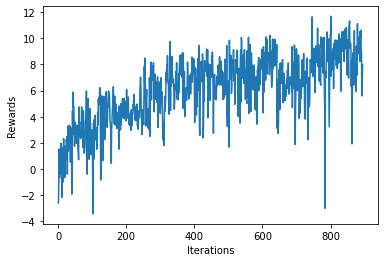

 90%|█████████████████████████████████████████████████████████████████▍       | 89604/100000 [1:01:20<05:57, 29.11it/s]

Updated Weights
Mean Reward = 5.96
40


 90%|█████████████████████████████████████████████████████████████████▍       | 89701/100000 [1:01:24<05:50, 29.42it/s]

Updated Weights
Mean Reward = 9.08
48


 90%|█████████████████████████████████████████████████████████████████▌       | 89803/100000 [1:01:28<07:22, 23.03it/s]

Updated Weights
Mean Reward = 9.69
53


 90%|█████████████████████████████████████████████████████████████████▋       | 89904/100000 [1:01:32<06:18, 26.70it/s]

Updated Weights
Mean Reward = 9.6
54


 90%|█████████████████████████████████████████████████████████████████▋       | 89998/100000 [1:01:36<08:08, 20.47it/s]

Updated Weights
Mean Reward = 7.25
34


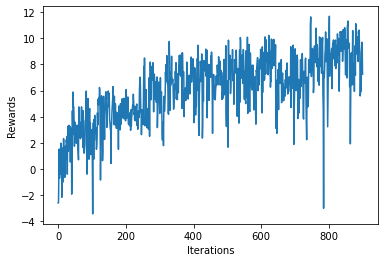

 90%|█████████████████████████████████████████████████████████████████▊       | 90105/100000 [1:01:41<07:00, 23.51it/s]

Updated Weights
Mean Reward = 7.09
32


 90%|█████████████████████████████████████████████████████████████████▊       | 90203/100000 [1:01:45<06:53, 23.71it/s]

Updated Weights
Mean Reward = 9.75
54


 90%|█████████████████████████████████████████████████████████████████▉       | 90306/100000 [1:01:50<07:05, 22.76it/s]

Updated Weights
Mean Reward = 7.98
47


 90%|█████████████████████████████████████████████████████████████████▉       | 90405/100000 [1:01:53<05:10, 30.94it/s]

Updated Weights
Mean Reward = 10.44
61


 90%|██████████████████████████████████████████████████████████████████       | 90498/100000 [1:01:57<07:29, 21.16it/s]

Updated Weights
Mean Reward = 10.26
59


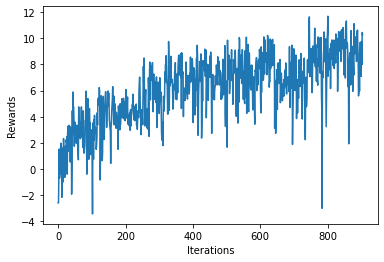

 91%|██████████████████████████████████████████████████████████████████▏      | 90604/100000 [1:02:02<07:52, 19.89it/s]

Updated Weights
Mean Reward = 6.88
40


 91%|██████████████████████████████████████████████████████████████████▏      | 90702/100000 [1:02:06<06:21, 24.36it/s]

Updated Weights
Mean Reward = 9.67
54


 91%|██████████████████████████████████████████████████████████████████▎      | 90802/100000 [1:02:11<07:34, 20.25it/s]

Updated Weights
Mean Reward = 8.1
43


 91%|██████████████████████████████████████████████████████████████████▎      | 90902/100000 [1:02:15<07:32, 20.10it/s]

Updated Weights
Mean Reward = 9.05
48


 91%|██████████████████████████████████████████████████████████████████▍      | 90998/100000 [1:02:19<04:50, 30.95it/s]

Updated Weights
Mean Reward = 9.44
54


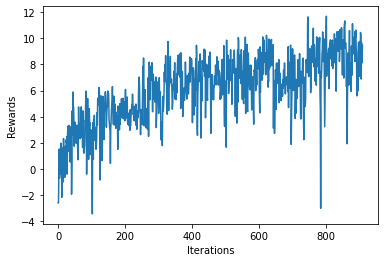

 91%|██████████████████████████████████████████████████████████████████▌      | 91106/100000 [1:02:24<06:01, 24.58it/s]

Updated Weights
Mean Reward = 9.56
49


 91%|██████████████████████████████████████████████████████████████████▌      | 91202/100000 [1:02:29<07:22, 19.90it/s]

Updated Weights
Mean Reward = 9.36
53


 91%|██████████████████████████████████████████████████████████████████▋      | 91306/100000 [1:02:33<06:14, 23.21it/s]

Updated Weights
Mean Reward = 10.3
53


 91%|██████████████████████████████████████████████████████████████████▋      | 91404/100000 [1:02:37<07:28, 19.15it/s]

Updated Weights
Mean Reward = 10.74
61


 92%|██████████████████████████████████████████████████████████████████▊      | 91500/100000 [1:02:41<05:48, 24.42it/s]

Updated Weights
Mean Reward = 9.97
58


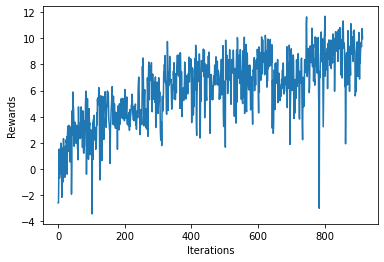

 92%|██████████████████████████████████████████████████████████████████▊      | 91603/100000 [1:02:46<06:25, 21.76it/s]

Updated Weights
Mean Reward = 9.82
54


 92%|██████████████████████████████████████████████████████████████████▉      | 91704/100000 [1:02:50<05:35, 24.73it/s]

Updated Weights
Mean Reward = 8.46
49


 92%|███████████████████████████████████████████████████████████████████      | 91804/100000 [1:02:55<06:54, 19.77it/s]

Updated Weights
Mean Reward = 8.04
38


 92%|███████████████████████████████████████████████████████████████████      | 91905/100000 [1:02:58<03:36, 37.45it/s]

Updated Weights
Mean Reward = 10.91
58


 92%|███████████████████████████████████████████████████████████████████▏     | 91997/100000 [1:03:00<03:26, 38.68it/s]

Updated Weights
Mean Reward = 9.82
54


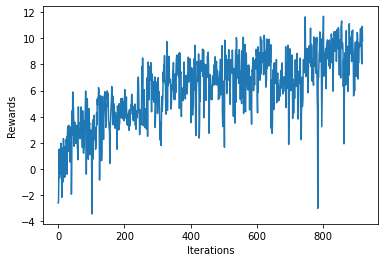

 92%|███████████████████████████████████████████████████████████████████▏     | 92106/100000 [1:03:03<03:23, 38.79it/s]

Updated Weights
Mean Reward = 10.29
60


 92%|███████████████████████████████████████████████████████████████████▎     | 92206/100000 [1:03:06<03:32, 36.70it/s]

Updated Weights
Mean Reward = 9.83
58


 92%|███████████████████████████████████████████████████████████████████▍     | 92303/100000 [1:03:09<03:18, 38.73it/s]

Updated Weights
Mean Reward = 9.91
58


 92%|███████████████████████████████████████████████████████████████████▍     | 92409/100000 [1:03:11<03:03, 41.28it/s]

Updated Weights
Mean Reward = 11.15
63


 92%|███████████████████████████████████████████████████████████████████▌     | 92499/100000 [1:03:14<04:18, 28.98it/s]

Updated Weights
Mean Reward = 8.98
46


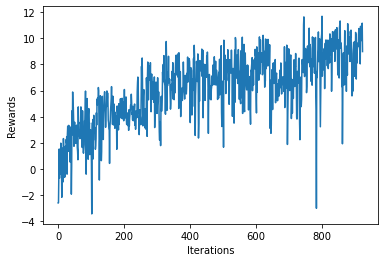

 93%|███████████████████████████████████████████████████████████████████▌     | 92607/100000 [1:03:17<03:10, 38.87it/s]

Updated Weights
Mean Reward = 11.21
64


 93%|███████████████████████████████████████████████████████████████████▋     | 92707/100000 [1:03:19<02:54, 41.75it/s]

Updated Weights
Mean Reward = 11.66
68


 93%|███████████████████████████████████████████████████████████████████▋     | 92807/100000 [1:03:22<03:34, 33.61it/s]

Updated Weights
Mean Reward = 8.21
51


 93%|███████████████████████████████████████████████████████████████████▊     | 92908/100000 [1:03:25<03:11, 37.04it/s]

Updated Weights
Mean Reward = 10.65
61


 93%|███████████████████████████████████████████████████████████████████▉     | 92998/100000 [1:03:27<03:06, 37.51it/s]

Updated Weights
Mean Reward = 10.27
57


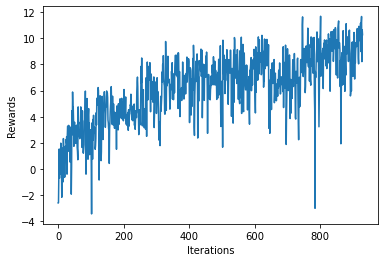

 93%|███████████████████████████████████████████████████████████████████▉     | 93105/100000 [1:03:30<03:23, 33.95it/s]

Updated Weights
Mean Reward = 9.99
57


 93%|████████████████████████████████████████████████████████████████████     | 93208/100000 [1:03:33<02:40, 42.32it/s]

Updated Weights
Mean Reward = 8.36
48


 93%|████████████████████████████████████████████████████████████████████     | 93305/100000 [1:03:36<04:10, 26.70it/s]

Updated Weights
Mean Reward = 8.3
45


 93%|████████████████████████████████████████████████████████████████████▏    | 93406/100000 [1:03:39<03:06, 35.32it/s]

Updated Weights
Mean Reward = 10.25
53


 93%|████████████████████████████████████████████████████████████████████▎    | 93497/100000 [1:03:41<03:13, 33.61it/s]

Updated Weights
Mean Reward = 9.85
55


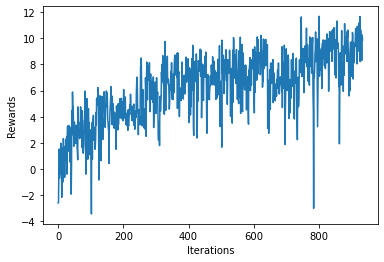

 94%|████████████████████████████████████████████████████████████████████▎    | 93608/100000 [1:03:44<02:39, 40.12it/s]

Updated Weights
Mean Reward = 9.78
52


 94%|████████████████████████████████████████████████████████████████████▍    | 93705/100000 [1:03:47<03:01, 34.63it/s]

Updated Weights
Mean Reward = 11.07
59


 94%|████████████████████████████████████████████████████████████████████▍    | 93803/100000 [1:03:49<02:56, 35.15it/s]

Updated Weights
Mean Reward = 12.01
67


 94%|████████████████████████████████████████████████████████████████████▌    | 93905/100000 [1:03:52<03:17, 30.93it/s]

Updated Weights
Mean Reward = 9.54
53


 94%|████████████████████████████████████████████████████████████████████▌    | 93996/100000 [1:03:54<02:49, 35.43it/s]

Updated Weights
Mean Reward = 8.96
55


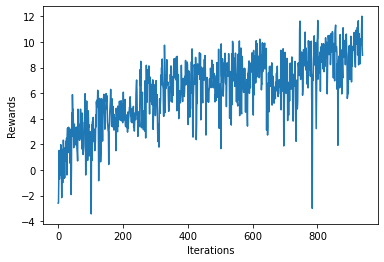

 94%|████████████████████████████████████████████████████████████████████▋    | 94107/100000 [1:03:58<02:48, 34.91it/s]

Updated Weights
Mean Reward = 10.4
58


 94%|████████████████████████████████████████████████████████████████████▊    | 94209/100000 [1:04:00<02:36, 37.09it/s]

Updated Weights
Mean Reward = 9.89
55


 94%|████████████████████████████████████████████████████████████████████▊    | 94304/100000 [1:04:03<02:38, 35.98it/s]

Updated Weights
Mean Reward = 10.75
61


 94%|████████████████████████████████████████████████████████████████████▉    | 94405/100000 [1:04:05<02:26, 38.28it/s]

Updated Weights
Mean Reward = 11.62
68


 94%|████████████████████████████████████████████████████████████████████▉    | 94497/100000 [1:04:08<02:32, 36.18it/s]

Updated Weights
Mean Reward = 8.79
46


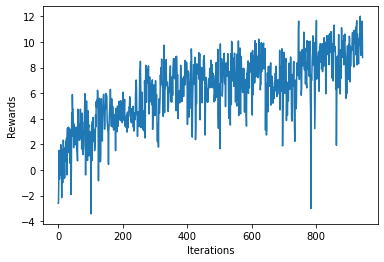

 95%|█████████████████████████████████████████████████████████████████████    | 94606/100000 [1:04:11<02:13, 40.41it/s]

Updated Weights
Mean Reward = 8.71
51


 95%|█████████████████████████████████████████████████████████████████████▏   | 94709/100000 [1:04:14<02:19, 37.98it/s]

Updated Weights
Mean Reward = 10.07
56


 95%|█████████████████████████████████████████████████████████████████████▏   | 94803/100000 [1:04:16<02:22, 36.54it/s]

Updated Weights
Mean Reward = 12.27
67


 95%|█████████████████████████████████████████████████████████████████████▎   | 94907/100000 [1:04:19<02:21, 36.09it/s]

Updated Weights
Mean Reward = 9.03
47


 95%|█████████████████████████████████████████████████████████████████████▎   | 95000/100000 [1:04:22<02:46, 29.96it/s]

Updated Weights
Mean Reward = 9.28
53


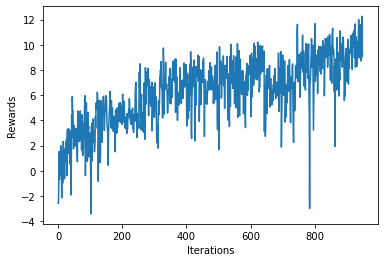

 95%|█████████████████████████████████████████████████████████████████████▍   | 95106/100000 [1:04:25<02:05, 39.07it/s]

Updated Weights
Mean Reward = 9.28
52


 95%|█████████████████████████████████████████████████████████████████████▍   | 95202/100000 [1:04:29<04:57, 16.12it/s]

Updated Weights
Mean Reward = 9.84
55


 95%|█████████████████████████████████████████████████████████████████████▌   | 95307/100000 [1:04:33<02:43, 28.62it/s]

Updated Weights
Mean Reward = 10.9
62


 95%|█████████████████████████████████████████████████████████████████████▋   | 95402/100000 [1:04:38<03:49, 20.04it/s]

Updated Weights
Mean Reward = 12.12
69


 95%|█████████████████████████████████████████████████████████████████████▋   | 95499/100000 [1:04:43<03:07, 24.03it/s]

Updated Weights
Mean Reward = 8.55
42


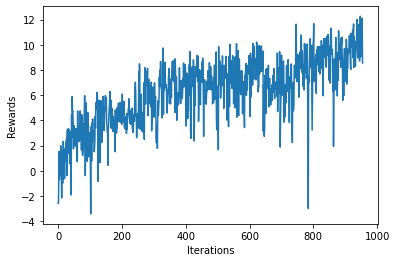

 96%|█████████████████████████████████████████████████████████████████████▊   | 95605/100000 [1:04:48<03:02, 24.08it/s]

Updated Weights
Mean Reward = 8.34
48


 96%|█████████████████████████████████████████████████████████████████████▊   | 95703/100000 [1:04:51<02:40, 26.71it/s]

Updated Weights
Mean Reward = 10.37
55


 96%|█████████████████████████████████████████████████████████████████████▉   | 95803/100000 [1:04:55<02:45, 25.41it/s]

Updated Weights
Mean Reward = 10.84
63


 96%|██████████████████████████████████████████████████████████████████████   | 95906/100000 [1:04:59<02:29, 27.39it/s]

Updated Weights
Mean Reward = 10.24
56


 96%|██████████████████████████████████████████████████████████████████████   | 95997/100000 [1:05:02<03:43, 17.93it/s]

Updated Weights
Mean Reward = 12.44
74


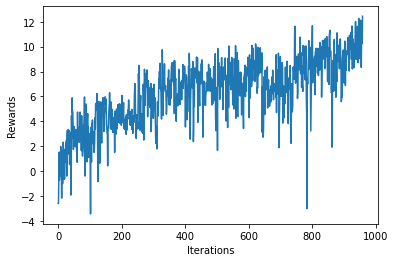

 96%|██████████████████████████████████████████████████████████████████████▏  | 96102/100000 [1:05:08<03:23, 19.20it/s]

Updated Weights
Mean Reward = 7.72
41


 96%|██████████████████████████████████████████████████████████████████████▏  | 96204/100000 [1:05:12<02:51, 22.16it/s]

Updated Weights
Mean Reward = 11.02
59


 96%|██████████████████████████████████████████████████████████████████████▎  | 96303/100000 [1:05:17<03:07, 19.69it/s]

Updated Weights
Mean Reward = 5.68
35


 96%|██████████████████████████████████████████████████████████████████████▍  | 96407/100000 [1:05:21<02:22, 25.23it/s]

Updated Weights
Mean Reward = 10.5
60


 96%|██████████████████████████████████████████████████████████████████████▍  | 96498/100000 [1:05:25<02:41, 21.63it/s]

Updated Weights
Mean Reward = 10.46
58


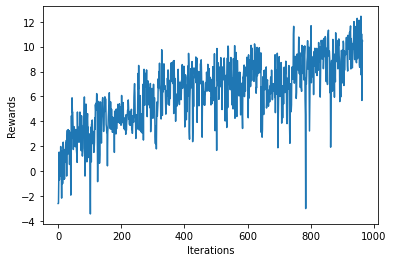

 97%|██████████████████████████████████████████████████████████████████████▌  | 96604/100000 [1:05:30<02:17, 24.79it/s]

Updated Weights
Mean Reward = 9.81
61


 97%|██████████████████████████████████████████████████████████████████████▌  | 96703/100000 [1:05:34<01:48, 30.47it/s]

Updated Weights
Mean Reward = 10.01
62


 97%|██████████████████████████████████████████████████████████████████████▋  | 96803/100000 [1:05:39<03:03, 17.42it/s]

Updated Weights
Mean Reward = 7.11
46


 97%|██████████████████████████████████████████████████████████████████████▋  | 96902/100000 [1:05:43<02:02, 25.26it/s]

Updated Weights
Mean Reward = 8.05
55


 97%|██████████████████████████████████████████████████████████████████████▊  | 97000/100000 [1:05:48<02:55, 17.13it/s]

Updated Weights
Mean Reward = 6.88
45


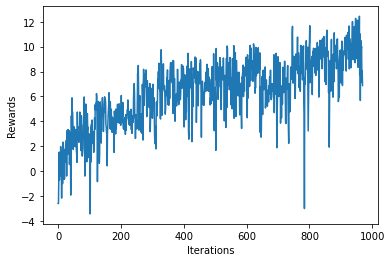

 97%|██████████████████████████████████████████████████████████████████████▉  | 97105/100000 [1:05:52<02:01, 23.84it/s]

Updated Weights
Mean Reward = 11.36
63


 97%|██████████████████████████████████████████████████████████████████████▉  | 97203/100000 [1:05:56<01:44, 26.80it/s]

Updated Weights
Mean Reward = 7.8
50


 97%|███████████████████████████████████████████████████████████████████████  | 97304/100000 [1:06:01<02:23, 18.77it/s]

Updated Weights
Mean Reward = 5.8
35


 97%|███████████████████████████████████████████████████████████████████████  | 97406/100000 [1:06:05<01:34, 27.46it/s]

Updated Weights
Mean Reward = 10.26
57


 97%|███████████████████████████████████████████████████████████████████████▏ | 97498/100000 [1:06:09<01:33, 26.73it/s]

Updated Weights
Mean Reward = 11.94
68


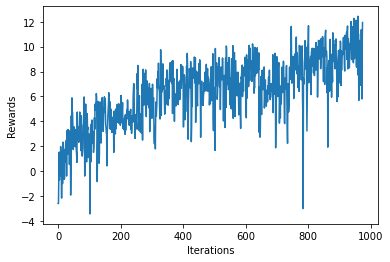

 98%|███████████████████████████████████████████████████████████████████████▎ | 97604/100000 [1:06:14<01:50, 21.66it/s]

Updated Weights
Mean Reward = 7.66
41


 98%|███████████████████████████████████████████████████████████████████████▎ | 97706/100000 [1:06:18<01:09, 32.90it/s]

Updated Weights
Mean Reward = 9.28
50


 98%|███████████████████████████████████████████████████████████████████████▍ | 97805/100000 [1:06:22<01:32, 23.75it/s]

Updated Weights
Mean Reward = 9.77
50


 98%|███████████████████████████████████████████████████████████████████████▍ | 97903/100000 [1:06:26<01:45, 19.82it/s]

Updated Weights
Mean Reward = 7.7
43


 98%|███████████████████████████████████████████████████████████████████████▌ | 97999/100000 [1:06:30<01:20, 24.84it/s]

Updated Weights
Mean Reward = 9.23
54


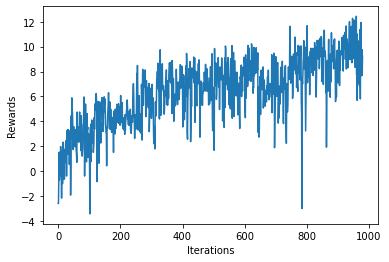

 98%|███████████████████████████████████████████████████████████████████████▌ | 98104/100000 [1:06:35<01:22, 23.09it/s]

Updated Weights
Mean Reward = 10.67
57


 98%|███████████████████████████████████████████████████████████████████████▋ | 98205/100000 [1:06:38<01:00, 29.74it/s]

Updated Weights
Mean Reward = 11.24
62


 98%|███████████████████████████████████████████████████████████████████████▊ | 98304/100000 [1:06:42<00:50, 33.55it/s]

Updated Weights
Mean Reward = 11.48
67


 98%|███████████████████████████████████████████████████████████████████████▊ | 98401/100000 [1:06:46<00:57, 27.97it/s]

Updated Weights
Mean Reward = 11.76
63


 98%|███████████████████████████████████████████████████████████████████████▉ | 98498/100000 [1:06:50<01:07, 22.31it/s]

Updated Weights
Mean Reward = 10.13
56


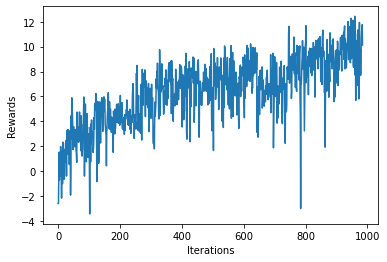

 99%|███████████████████████████████████████████████████████████████████████▉ | 98603/100000 [1:06:54<01:08, 20.45it/s]

Updated Weights
Mean Reward = 10.09
57


 99%|████████████████████████████████████████████████████████████████████████ | 98704/100000 [1:06:59<01:02, 20.80it/s]

Updated Weights
Mean Reward = 5.08
30


 99%|████████████████████████████████████████████████████████████████████████▏| 98804/100000 [1:07:03<00:34, 34.73it/s]

Updated Weights
Mean Reward = 11.09
67


 99%|████████████████████████████████████████████████████████████████████████▏| 98905/100000 [1:07:06<00:41, 26.21it/s]

Updated Weights
Mean Reward = 7.9
52


 99%|████████████████████████████████████████████████████████████████████████▎| 99000/100000 [1:07:09<00:21, 46.95it/s]

Updated Weights
Mean Reward = 9.79
56


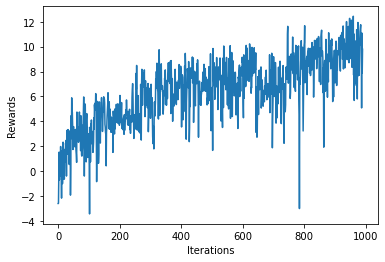

 99%|████████████████████████████████████████████████████████████████████████▎| 99104/100000 [1:07:12<00:26, 34.36it/s]

Updated Weights
Mean Reward = 10.34
56


 99%|████████████████████████████████████████████████████████████████████████▍| 99207/100000 [1:07:14<00:17, 44.70it/s]

Updated Weights
Mean Reward = 9.98
57


 99%|████████████████████████████████████████████████████████████████████████▍| 99309/100000 [1:07:17<00:16, 41.18it/s]

Updated Weights
Mean Reward = 11.22
64


 99%|████████████████████████████████████████████████████████████████████████▌| 99407/100000 [1:07:19<00:14, 39.64it/s]

Updated Weights
Mean Reward = 9.2
60


 99%|████████████████████████████████████████████████████████████████████████▋| 99498/100000 [1:07:22<00:12, 40.64it/s]

Updated Weights
Mean Reward = 10.02
63


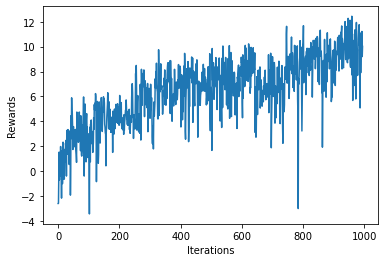

100%|████████████████████████████████████████████████████████████████████████▋| 99606/100000 [1:07:24<00:10, 38.31it/s]

Updated Weights
Mean Reward = 9.25
65


100%|████████████████████████████████████████████████████████████████████████▊| 99710/100000 [1:07:27<00:05, 53.00it/s]

Updated Weights
Mean Reward = 10.76
63


100%|████████████████████████████████████████████████████████████████████████▊| 99810/100000 [1:07:29<00:04, 44.36it/s]

Updated Weights
Mean Reward = 8.51
54


100%|████████████████████████████████████████████████████████████████████████▉| 99901/100000 [1:07:32<00:03, 29.73it/s]

Updated Weights
Mean Reward = 11.44
66


100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [1:07:35<00:00, 24.66it/s]


In [6]:
rewards = []
mean_rewards = []
max_steps = 40
reached = 0
for epoch in tqdm(range(100000)):
    done = False
    episode_reward = 0
    step = 0
    start, dest = env.give_start_dest()
    state = [start[0], start[1], dest[0], dest[1]]
    while not done and step<max_steps:
        state = np.array(state)
        next_state, reward, done = user_agent.play_one_step(env, state, mod_agent)
        state = next_state
        episode_reward+=reward
        step+=1
        if done:
            reached+=1
            
    if epoch>50:
        user_agent.train()

    if epoch>50 and epoch%100==0:
        user_agent.target_model.set_weights(user_agent.model.get_weights())
        print('Updated Weights')

       
    if epoch>50 and epoch%250==0:
        user_agent.epsilon*=0.9
        user_agent.epsilon = max(user_agent.epsilon, 0.1)

    mean_rewards.append(episode_reward)
    if epoch%100==0 and epoch:
        rewards.append(np.mean(mean_rewards))
        mean_rewards = []
        print(f'Mean Reward = {rewards[-1]}')
        print(reached)
        reached = 0
        
    if epoch%500==0 and epoch:
        plt.plot(rewards)
        plt.xlabel('Iterations')
        plt.ylabel('Rewards')
        plt.show()
    

In [7]:
user_agent.epsilon = 0
done = False
episode_reward = 0
step = 0
start, dest = env.give_start_dest()
state = [start[0], start[1], dest[0], dest[1]]
while not done and step<max_steps:
    print(state)
    state = np.array(state)
    next_state, reward, done = user_agent.play_one_step(env, state, mod_agent)
    state = next_state
    episode_reward+=reward
    step+=1
    if done:
        reached+=1


[0.0, 0.8, 0.1, 0.7]
[0.0, 0.7, 0.1, 0.7]


In [8]:
print(done)

1


In [9]:
user_agent.model.save_weights('user_agent.h5')